In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy

from tqdm import tqdm
import yaml

from scipy.stats import binned_statistic_2d
from scipy.stats import norm
from scipy import stats
# import shap

from flash_ansr import get_path, ExpressionSpace
from flash_ansr.eval.utils import bootstrapped_metric_ci

In [2]:
def nan_false_statistic(X, statistic):
    X_copy = np.array(X)
    # Where X is nan, replace with False
    X_copy[np.isnan(X_copy)] = False
    return statistic(X_copy)

In [3]:
MODELS = [os.path.join('analysis_noise', m) for m in os.listdir(get_path('results', 'evaluation', 'analysis_noise'))]

In [4]:
MODELS_DESCRIPTION = {k: k.replace('v6.0_', '') for k in MODELS}

In [5]:
TEST_SETS = ['train', 'val', 'feynman', 'soose_nc', 'nguyen', 'pool_15']
TEST_SET_TITLES = {
    'train': 'Train',
    'val': 'Val',
    'feynman': 'Feynman',
    'soose_nc': 'S.-NC',
    'nguyen': 'Nguyen',
    'pool_15': 'Pool 15',
}

In [6]:
configs = {}

for model in MODELS:
    with open(get_path(f'configs/{model}/evaluation.yaml'), 'r') as f:
        configs[model] = yaml.safe_load(f)

In [7]:
test_sets = {model: [path.replace('.pickle', '') for path in os.listdir(get_path(f'results/evaluation/{model}'))] for model in MODELS}

for model, model_test_sets in test_sets.items():
    # Reorder the test sets as follows: train, val, feynman, soose_nc, nguyen
    for i, s in enumerate(TEST_SETS):
        if s in model_test_sets:
            model_test_sets.remove(s)
            model_test_sets.insert(i, s)

In [8]:
results = {}

for model, model_test_sets in test_sets.items():
    results[model] = {test_set: {'path': get_path(f'results/evaluation/{model}/{test_set}.pickle')} for test_set in model_test_sets}

# Sort the results by configs[model]['noise_level']
results = dict(sorted(results.items(), key=lambda x: configs[x[0]]['noise_level']))

In [9]:
remove_invalid = []

for model, model_results in results.items():
    for test_set, test_set_results in tqdm(model_results.items(), desc=f'Loading {model} results'):
        with open(test_set_results['path'], 'rb') as f:
            test_set_results['data'] = pickle.load(f)

            columns_to_rename = set()
            for k, v in test_set_results['data'].items():
                try:
                    test_set_results['data'][k] = np.array(v)
                except ValueError:
                    pass

                if '_free_' in k:
                    columns_to_rename.add(k)

            for k in columns_to_rename:
                test_set_results['data'][k.replace('_free_', '_')] = test_set_results['data'][k]
                del test_set_results['data'][k]

            # keys_to_remove = [k for k in test_set_results['data'].keys() if 'residuals' in k]
            # keys_to_remove = []
            # keys_to_remove.extend(['x', 'y'])

            # for k in keys_to_remove:
            #     del test_set_results['data'][k]

Loading analysis_noise/v6.0_1-noise results: 100%|██████████| 4/4 [00:15<00:00,  3.89s/it]


In [10]:
for model, model_results in results.items():
    for test_set, test_set_results in tqdm(model_results.items(), desc=f'Filtering {model} results'):
        for k in test_set_results['data'].keys():
            test_set_results['data'][k] = test_set_results['data'][k][1:]

Filtering analysis_noise/v6.0_1-noise results: 100%|██████████| 4/4 [00:00<00:00, 1022.81it/s]


In [11]:
for model, model_results in results.items():
    for test_set, test_set_results in tqdm(model_results.items(), desc=f'Filtering {model} results'):
        for k in test_set_results['data'].keys():
            if 'residuals' in k:
                for i, residuals in enumerate(test_set_results['data'][k]):
                    if residuals is None:
                        test_set_results['data'][k][i] = np.full((configs[model]['n_support'], 1), np.nan)

Filtering analysis_noise/v6.0_1-noise results: 100%|██████████| 4/4 [00:00<00:00, 591.37it/s]


In [12]:
for model, model_results in results.items():
    beam_width = configs[model].get('beam_width', 1)
    n_restarts = configs[model].get('n_restarts', 1)
    # Pad the beams to their maximum length
    for test_set, test_set_results in tqdm(model_results.items()):
        data = test_set_results['data']

        if model == 'pysr':
            results[model][test_set]['data']['wall_time'] = data['fit_time']
            results[model][test_set]['data']['sys_time'] = data['fit_time'] * 32  # 32 cores
        
        elif model == 'nesymres-100M':
            results[model][test_set]['data']['wall_time'] = data['fit_time']
            results[model][test_set]['data']['sys_time'] = data['fit_time']

        else:
            results[model][test_set]['data']['wall_time'] = data['beam_search_time'] + sum(data[f'refiner_time_beam_{j + 1}'] for j in range(beam_width))
            results[model][test_set]['data']['sys_time'] = data['beam_search_time'] + sum(data[f'refiner_time_beam_{j + 1}'] for j in range(beam_width))

100%|██████████| 4/4 [00:00<00:00, 10381.94it/s]


In [13]:
for model, model_results in results.items():
    beam_width = configs[model].get('beam_width', 1)
    # Pad the beams to their maximum length
    for test_set, test_set_results in tqdm(model_results.items()):
        data = test_set_results['data']

        results[model][test_set]['data']['length_target'] = np.array([len(data['input_ids'][i]) for i in range(len(data['input_ids']))])
        
        for j in range(beam_width):
            results[model][test_set]['data'][f'length_beam_{j + 1}'] = np.array([len(data[f'free_beam_{j + 1}'][i]) for i in range(len(data[f'free_beam_{j + 1}']))])

            if f'residuals_beam_{j + 1}' not in data:
                continue
            results[model][test_set]['data'][f'L_inf_beam_{j + 1}'] = np.array([(np.nanmax(np.abs(data[f'residuals_beam_{j + 1}'][i])) if data[f'residuals_beam_{j + 1}'][i] is not None else np.nan) for i in range(len(data[f'residuals_beam_{j + 1}']))])
        
        if '_beam_1' in data:
            max_length = max(max([len(beam) for beam in data[f'_beam_{j + 1}']]) for j in range(beam_width))

            for j in range(beam_width):
                padded_beam = [beam + [0] * (max_length - len(beam)) for beam in data[f'_beam_{j + 1}']]
                data[f'_beam_{j + 1}'] = np.array(padded_beam)


  0%|          | 0/4 [00:00<?, ?it/s]/tmp/ipykernel_3637/1962314347.py:14: RuntimeWarning: All-NaN slice encountered
  results[model][test_set]['data'][f'L_inf_beam_{j + 1}'] = np.array([(np.nanmax(np.abs(data[f'residuals_beam_{j + 1}'][i])) if data[f'residuals_beam_{j + 1}'][i] is not None else np.nan) for i in range(len(data[f'residuals_beam_{j + 1}']))])
100%|██████████| 4/4 [00:00<00:00,  9.18it/s]


In [14]:
for model, model_results in results.items():
    beam_width = configs[model].get('beam_width', 1)
    for test_set, test_set_results in tqdm(model_results.items()):
        data = test_set_results['data']

        beam_columns = [k.replace('_beam_1', '') for k in data.keys() if k.endswith(f'beam_1') and not 'free' in k]

        # Create new columns with metrics of the best beam (by mse_{generation_type}_beam_{i}) and store it as {metric}_{generation_type}_best_beam
        # Create new columns
        for column in beam_columns:
            if isinstance(data[column + '_beam_1'][0], np.ndarray):
                data[column + '_best_beam'] = np.nan * np.ones_like(data[column + '_beam_1'])
            else:
                data[column + '_best_beam'] = np.nan * np.ones(len(data[column + '_beam_1']))

        data['best_beam'] = np.nan * np.ones(len(data['mse_beam_1']))

        # For each instance, find the best beam by mse
        for i in range(len(data['mse_beam_1'])):
            mse_list = np.array([data[f'mse_beam_{j}'][i] for j in range(1, beam_width+1) if f'mse_beam_{j}' in data.keys()])
            if np.all(np.isnan(mse_list)):
                continue
            best_beam = np.nanargmin([data[f'mse_beam_{j}'][i] for j in range(1, beam_width+1) if f'mse_beam_{j}' in data.keys()]) + 1
            data['best_beam'][i] = best_beam
            for column in beam_columns:
                data[column + '_best_beam'][i] = data[column + f'_beam_{best_beam}'][i]

100%|██████████| 4/4 [00:00<00:00, 27.90it/s]


In [15]:
# Design features
for model, model_results in results.items():
    for test_set, test_set_results in model_results.items():
        test_set_results['data']['FVU-eps_accuracy'] = np.array([(1 - r2) <= np.finfo(np.float32).eps for r2 in test_set_results['data']['r2_best_beam']])
        test_set_results['data']['log_fvu'] = np.array([np.log10(1 - r2 + np.finfo(np.float32).eps) for r2 in test_set_results['data']['r2_best_beam']])
        test_set_results['data']['fvu'] = np.array([1 - r2 for r2 in test_set_results['data']['r2_best_beam']])
        test_set_results['data']['is_finite'] = np.array([np.isfinite(r2) for r2 in test_set_results['data']['r2_best_beam']])
        test_set_results['data']['y_std'] = np.array([np.std(y) for y in test_set_results['data']['y']])
        test_set_results['data']['noise'] = np.array([y_noisy - y for y_noisy, y in zip(test_set_results['data']['y_noisy'], test_set_results['data']['y'])])
        test_set_results['data']['noise_std'] = np.array([np.std(noise) for noise in test_set_results['data']['noise']])
        test_set_results['data']['residuals_std'] = np.array([np.std(residuals) for residuals in test_set_results['data']['residuals_best_beam']])
        test_set_results['data']['residuals_scaled'] = np.array([residuals / y_std for residuals, y_std in zip(test_set_results['data']['residuals_best_beam'], test_set_results['data']['y_std'])])
        test_set_results['data']['is_overfit'] = np.array([residuals_std < noise_std for residuals_std, noise_std in zip(test_set_results['data']['residuals_std'], test_set_results['data']['noise_std'])])

        if 'perplexity' in test_set_results['data']:
            test_set_results['data']['log_ppl'] = np.array([np.log10(ppl) for ppl in test_set_results['data']['perplexity']])
        else:
            test_set_results['data']['log_ppl'] = [np.nan] * len(test_set_results['data']['r2_best_beam'])

/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/_core/_methods.py:197: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/tmp/ipykernel_3637/927759427.py:12: RuntimeWarning: invalid value encountered in divide
  test_set_results['data']['residuals_scaled'] = np.array([residuals / y_std for residuals, y_std in zip(test_set_results['data']['residuals_best_beam'], test_set_results['data']['y_std'])])
/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/_core/_methods.py:208: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/tmp/ipykernel_3637/927759427.py:12: RuntimeWarning: divide by zero encountered in divide
  test_set_results['data']['residuals_scaled'] = np.array([residuals / y_std for residuals, y_std in zip(test_set_results['data']['residuals_best_beam'], test_set_results['data']['y_std'])])


In [108]:
def get_quantiles(data):
    sorted_data = np.sort(data[np.isfinite(data)])

    n = len(sorted_data)
    p = (np.arange(1, n + 1) - 0.5) / n
    theoretical_quantiles = norm.ppf(p)
    empirical_quantiles = sorted_data
    
    # 4. Scale both to [0, 1]
    # For theoretical quantiles
    theo_scaled = (theoretical_quantiles - np.min(theoretical_quantiles)) / \
                 (np.max(theoretical_quantiles) - np.min(theoretical_quantiles))

    # For empirical quantiles
    emp_scaled = (sorted_data - np.min(sorted_data)) / (np.max(sorted_data) - np.min(sorted_data))

    return theo_scaled, emp_scaled

In [138]:
def sci_to_latex(num):
    if num == 0:
        return '0'
    if num == 1:
        return '1'
    # if num % 10 == 0 or 10 % num == 0:
    frac = ""
    # else:
    #     frac = f"{num:.0f}\\times "
    return f"{frac}10^{{{int(np.log10(abs(num))):+}}}"

In [194]:
# QQ
for model, model_results in results.items():
    for test_set, test_set_results in model_results.items():
        theoretical_quantiles_all, emperical_quantiles_all = get_quantiles(np.concatenate(test_set_results['data']['residuals_scaled']))
        test_set_results['data']['theoretical_quantiles_all'] = theoretical_quantiles_all
        test_set_results['data']['emperical_quantiles_all'] = emperical_quantiles_all

        test_set_results['data']['theoretical_quantiles'] = []
        test_set_results['data']['emperical_quantiles'] = []

        for residuals in test_set_results['data']['residuals_scaled']:
            if not np.isfinite(residuals).any():
                test_set_results['data']['theoretical_quantiles'].append(np.full((configs[model]['n_support']), np.nan))
                test_set_results['data']['emperical_quantiles'].append(np.full((configs[model]['n_support']), np.nan))
            else:
                theoretical_quantiles, emperical_quantiles = get_quantiles(residuals)
                test_set_results['data']['theoretical_quantiles'].append(theoretical_quantiles)
                test_set_results['data']['emperical_quantiles'].append(emperical_quantiles)

        test_set_results['data']['emperical_quantiles_median'] = np.nanmedian(np.array(test_set_results['data']['emperical_quantiles']), axis=0)
        test_set_results['data']['emperical_quantiles_mean'] = np.nanmean(np.array(test_set_results['data']['emperical_quantiles']), axis=0)
        test_set_results['data']['emperical_quantiles_p75'] = np.nanpercentile(np.array(test_set_results['data']['emperical_quantiles']), 75, axis=0)
        test_set_results['data']['emperical_quantiles_p25'] = np.nanpercentile(np.array(test_set_results['data']['emperical_quantiles']), 25, axis=0)
        test_set_results['data']['emperical_quantiles_p95'] = np.nanpercentile(np.array(test_set_results['data']['emperical_quantiles']), 95, axis=0)
        test_set_results['data']['emperical_quantiles_p5'] = np.nanpercentile(np.array(test_set_results['data']['emperical_quantiles']), 5, axis=0)

/tmp/ipykernel_3637/2015365698.py:15: RuntimeWarning: invalid value encountered in divide
  emp_scaled = (sorted_data - np.min(sorted_data)) / (np.max(sorted_data) - np.min(sorted_data))


/tmp/ipykernel_3637/1752946822.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right', ncol=1)


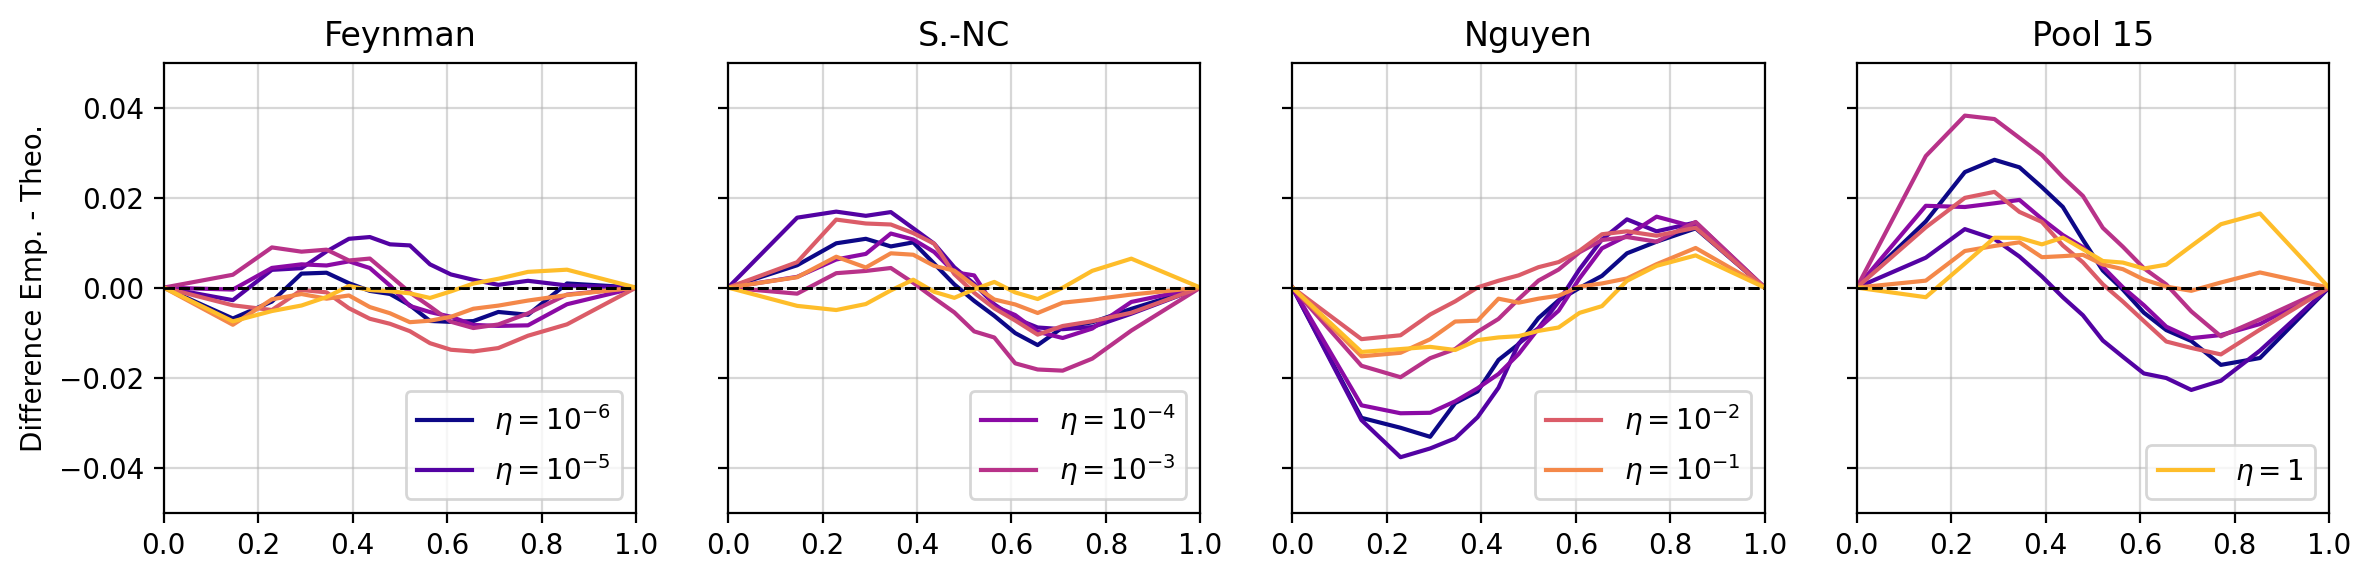

In [215]:
COLS = 4
ROWS = 1

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 3, ROWS * 3), dpi=200, sharex=True, sharey=True)

for i, (model, model_results) in enumerate(list(results.items())[1:]):
    for j, (test_set, test_set_results) in enumerate(model_results.items()):
        ax = axes[j]
        color = plt.get_cmap('plasma')(i / (len(results) - 1))
        theoretical_quantiles = test_set_results['data']['theoretical_quantiles'][0]
        empirical_quantiles = test_set_results['data']['emperical_quantiles_mean']

        ax.plot(theoretical_quantiles, empirical_quantiles - theoretical_quantiles, color=color, label=("$\\eta = " + sci_to_latex(configs[model]['noise_level']) + "$") if i // 2 == j else None)
        ax.grid(alpha=0.5)
        ax.axhline(0, color='k', linestyle='--', linewidth=1)
        ax.set_xlim(0, 1)
        ax.set_ylim(-0.05, 0.05)

        if i == 0:
            ax.set_title(TEST_SET_TITLES[test_set])

        if i == len(results) - 1:
            ax.set_xlabel('Theoretical Quantile')

        if j == 0:
            ax.set_ylabel('Difference Emp. - Theo.')

        ax.legend(loc='lower right', ncol=1)

fig.tight_layout()

plt.savefig(get_path('results', 'analysis_noise', create=True, filename='noise_qq_plot.svg'))

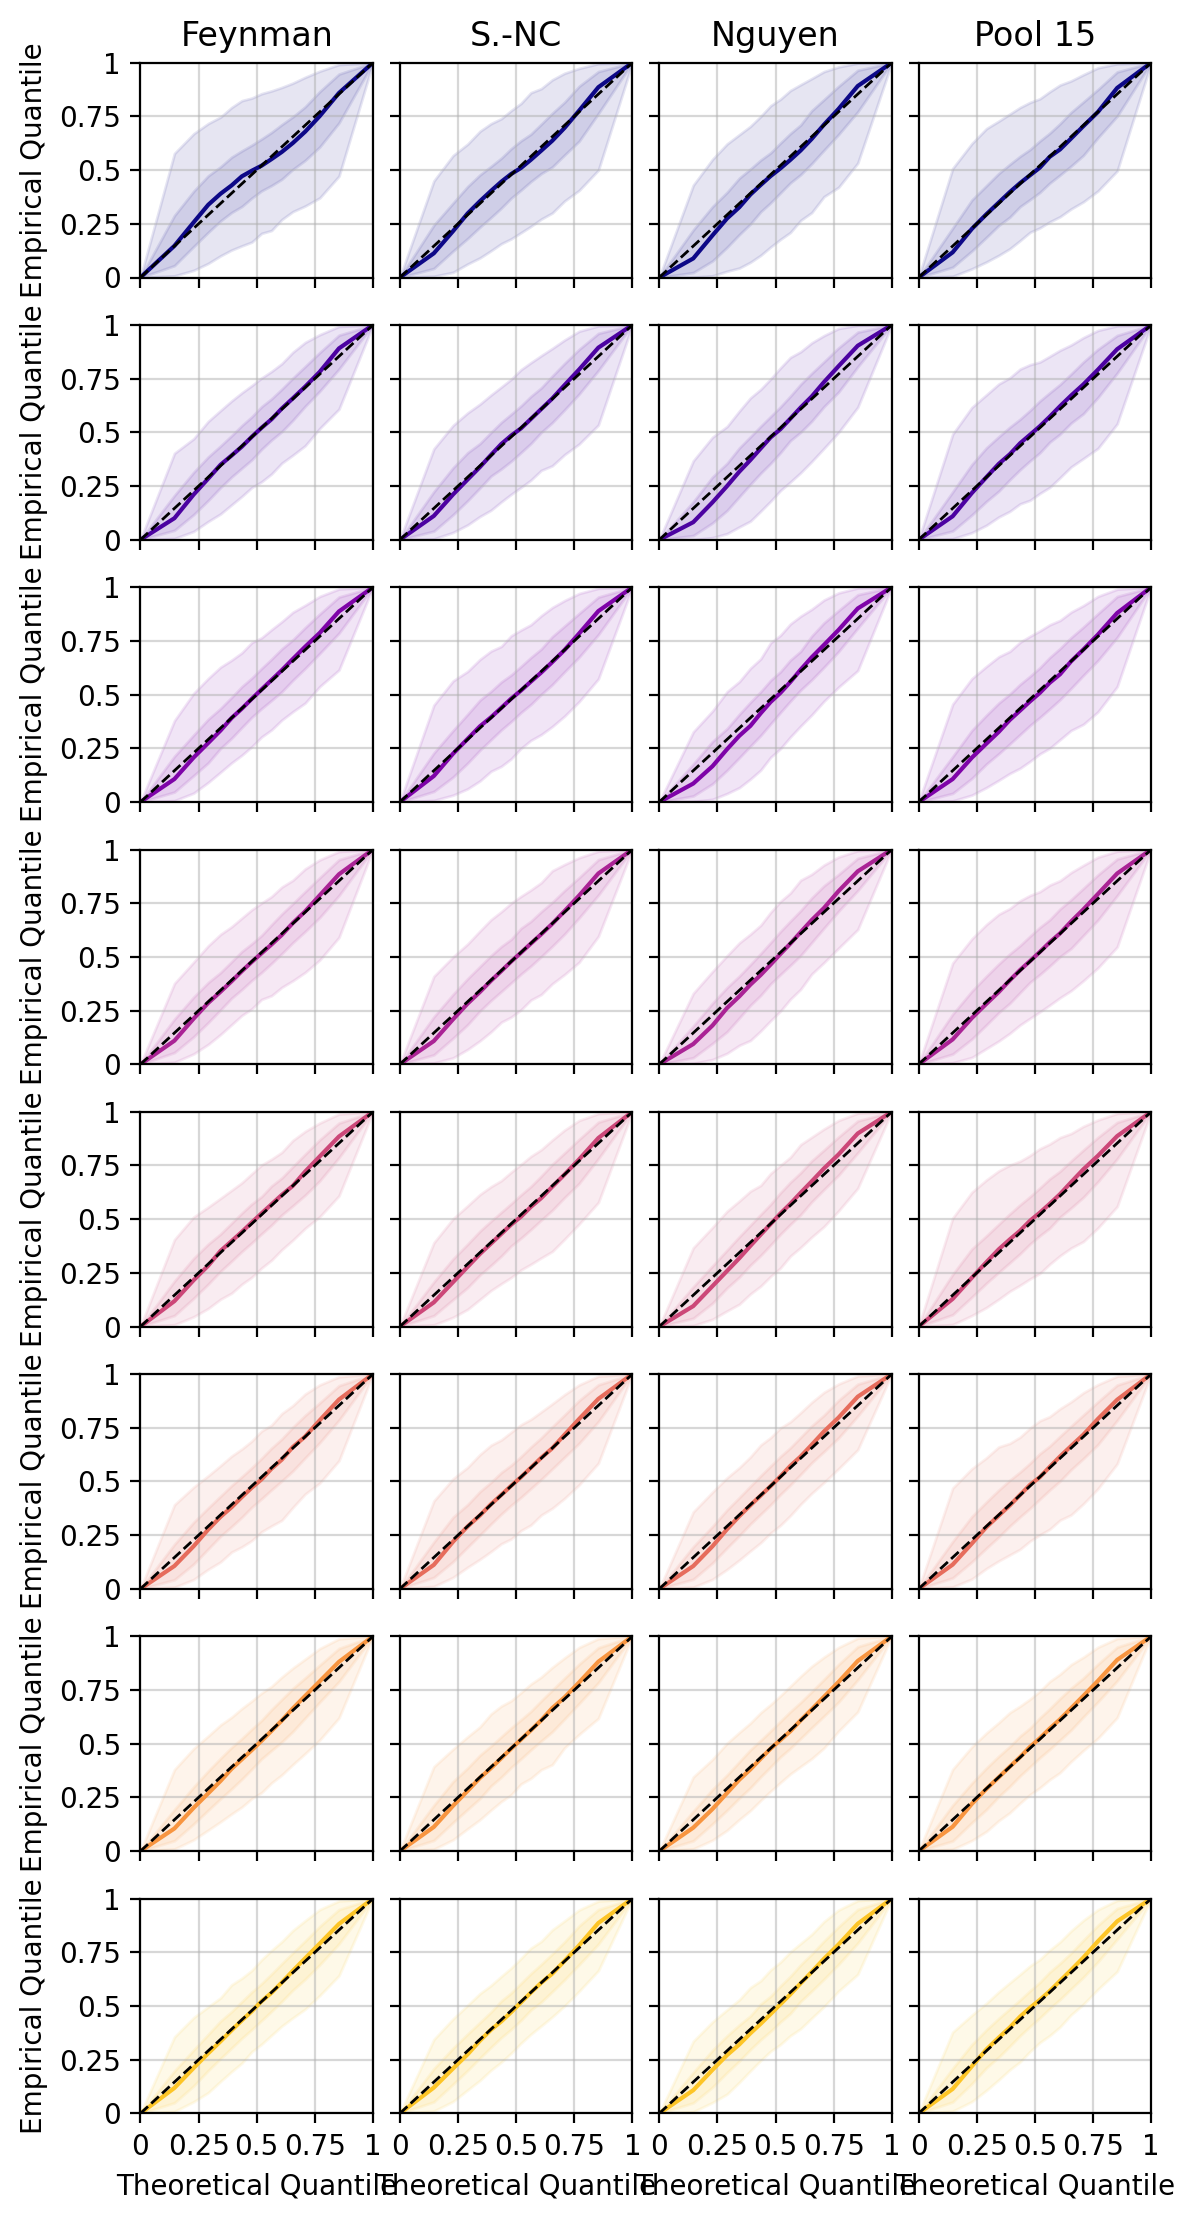

In [ ]:
COLS = 4
ROWS = len(results)

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 1.5, ROWS * 1.4), dpi=200, sharex=True, sharey=True)

for i, (model, model_results) in enumerate(results.items()):
    for j, (test_set, test_set_results) in enumerate(model_results.items()):
        ax = axes[i, j]
        color = plt.get_cmap('plasma')(i / len(results))
        theoretical_quantiles = test_set_results['data']['theoretical_quantiles'][0]
        empirical_quantiles = test_set_results['data']['emperical_quantiles_median']
        ax.plot(theoretical_quantiles, empirical_quantiles, color=color)
        ax.fill_between(theoretical_quantiles, test_set_results['data']['emperical_quantiles_p25'], test_set_results['data']['emperical_quantiles_p75'], alpha=0.1, color=color)
        ax.fill_between(theoretical_quantiles, test_set_results['data']['emperical_quantiles_p5'], test_set_results['data']['emperical_quantiles_p95'], alpha=0.1, color=color)
        ax.grid(alpha=0.5)
        ax.plot([0, 1], [0, 1], 'k', linestyle='--', linewidth=1)
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])

        ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
        ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
        ax.set_xticklabels(["0", "0.25", "0.5", "0.75", "1"])
        ax.set_yticklabels(["0", "0.25", "0.5", "0.75", "1"])

        if i == 0:
            ax.set_title(TEST_SET_TITLES[test_set])

        if i == len(results) - 1:
            ax.set_xlabel('Theoretical Quantile')

        if j == 0:
            ax.set_ylabel('Empirical Quantile')
            # ax.legend(loc='upper left')


fig.tight_layout(w_pad=0.3, h_pad=0.7)

plt.savefig(get_path('results', 'analysis_noise', create=True, filename='noise_qq_plot.svg'))

/tmp/ipykernel_3637/1288271432.py:2: RuntimeWarning: divide by zero encountered in log10
  ax.hist2d(np.log10(results['analysis_noise/v6.0_1e-3-noise']['feynman']['data']['residuals_std']), np.log10(results['analysis_noise/v6.0_1e-3-noise']['feynman']['data']['noise_std']), bins=np.linspace(-6, 2, 50));


Text(0, 0.5, 'log10(Noise Std)')

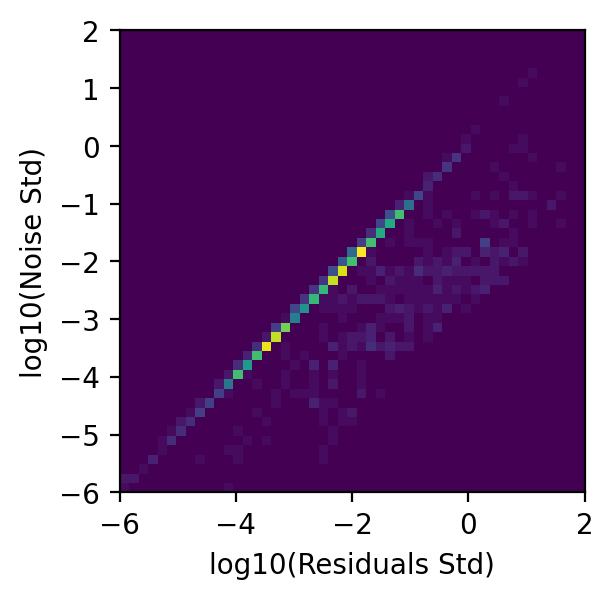

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=200)
ax.hist2d(np.log10(results['analysis_noise/v6.0_1e-3-noise']['feynman']['data']['residuals_std']), np.log10(results['analysis_noise/v6.0_1e-3-noise']['feynman']['data']['noise_std']), bins=np.linspace(-6, 2, 50));
ax.set_xlabel('log10(Residuals Std)')
ax.set_ylabel('log10(Noise Std)')

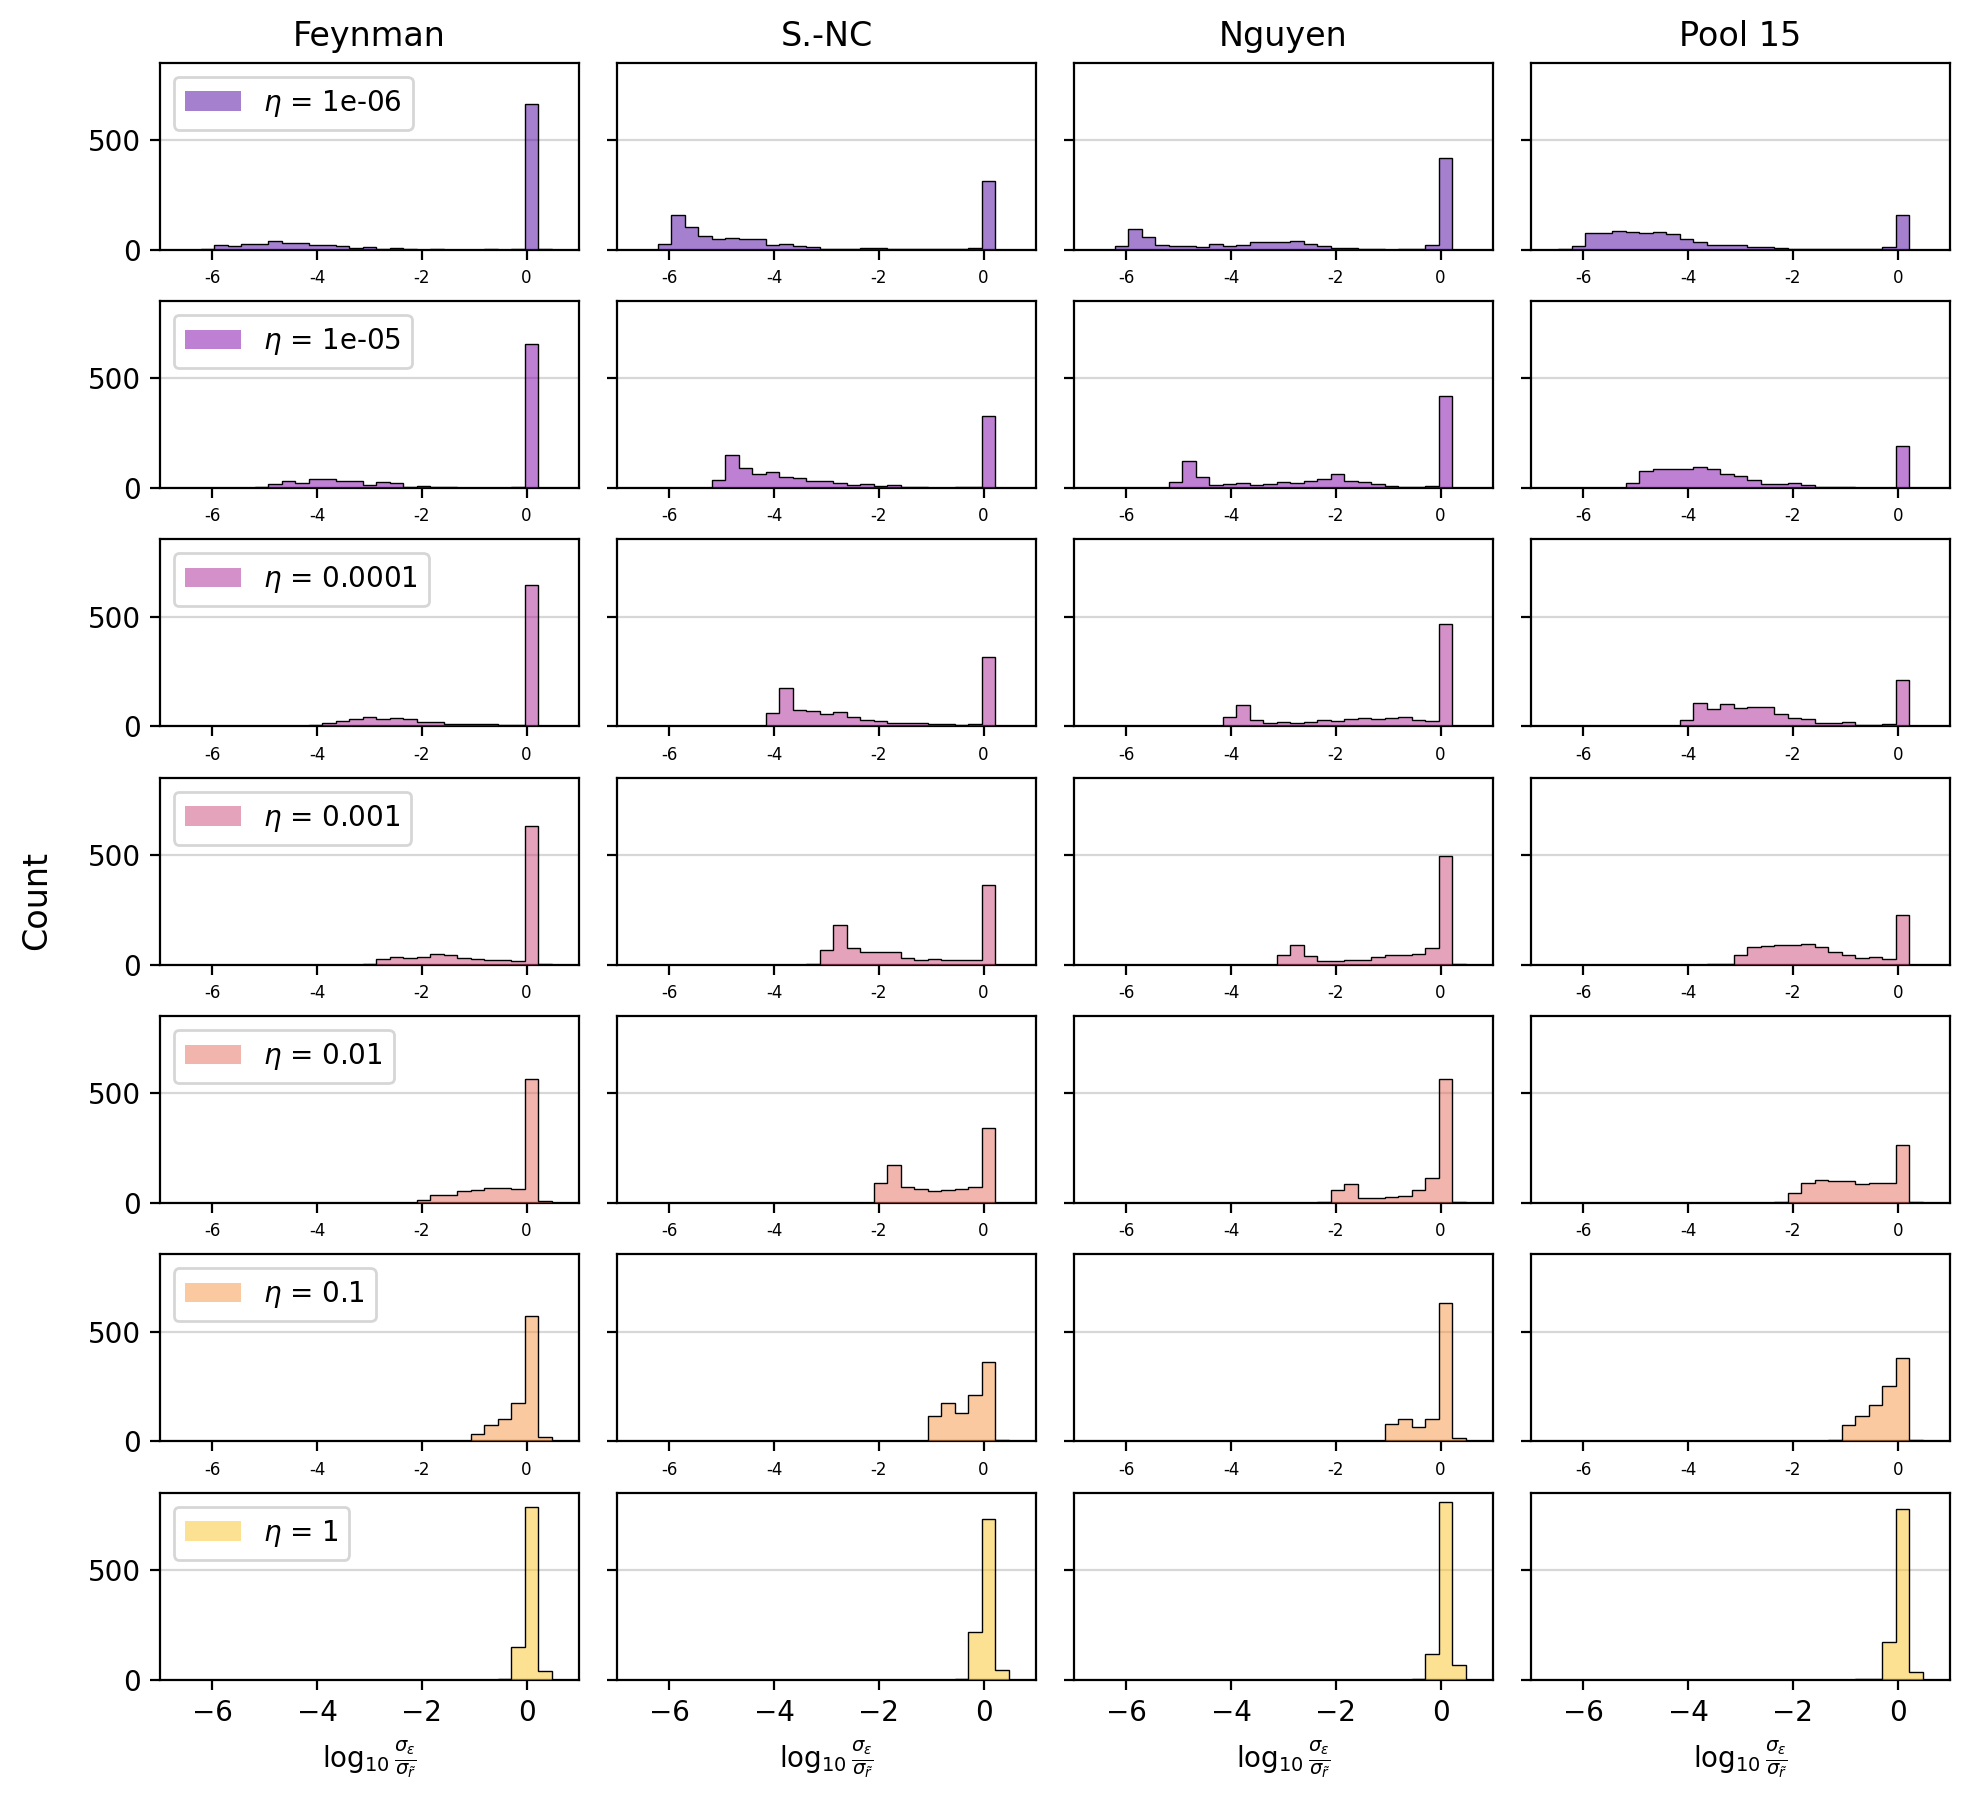

In [30]:
COLS = 4
ROWS = len(results) - 1

xlim = (-7, 1)
bins = 32

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 2.5, ROWS * 1.3), dpi=200, sharey=True)

for i, (model, model_results) in enumerate(list(results.items())[1:]):
    for j, (test_set, test_set_results) in enumerate(list(model_results.items())):

        ax = axes[i, j]
        color = plt.get_cmap('plasma')((i + 1) / len(results))

        valid_residuals_std = test_set_results['data']['residuals_std']
        valid_residuals_std_mask = np.isfinite(valid_residuals_std) & (valid_residuals_std > 0)

        valid_noise_std = test_set_results['data']['noise_std']
        valid_noise_std_mask =np.isfinite(valid_noise_std) & (valid_noise_std > 0)

        both_valid_mask = valid_residuals_std_mask & valid_noise_std_mask

        valid_residuals_std = valid_residuals_std[both_valid_mask]
        valid_noise_std = valid_noise_std[both_valid_mask]

        ax.hist(np.log10(valid_noise_std) - np.log10(valid_residuals_std) , bins=np.linspace(*xlim, bins), color=color, alpha=0.5, label=f"$\\eta$ = {configs[model]['noise_level']}", zorder=3, rasterized=True)
        ax.hist(np.log10(valid_noise_std) - np.log10(valid_residuals_std), bins=np.linspace(*xlim, bins), color='k', histtype='step', zorder=4, linewidth=0.5)
        ax.set_xlim(xlim)

        if i == 0:
            ax.set_title(TEST_SET_TITLES[test_set])

        if i == len(results) - 2:
            ax.set_xlabel('$\\log_{10} \\frac{\\sigma_{\\epsilon}}{ \\sigma_{\\tilde r}}$')
            ax.set_xticks(np.arange(-8, 2, 2))
        else:
            ax.set_xticks(np.arange(-8, 2, 2))
            ax.set_xticklabels(np.arange(-8, 2, 2), fontsize=6)

        ax.set_xlim(xlim)

        if j == 0:
            # ax.set_ylabel('Count')
            ax.legend(loc='upper left')
            # ax.set_yticks([0, 50, 100, 150, 200])

        ax.grid(alpha=0.5, zorder=0, axis='y')

fig.tight_layout(h_pad=0.5)
fig.supylabel('Count')
fig.subplots_adjust(left=0.09)

plt.savefig(get_path('results', 'analysis_noise', create=True, filename='noise_residuals_std_histogram.svg'))

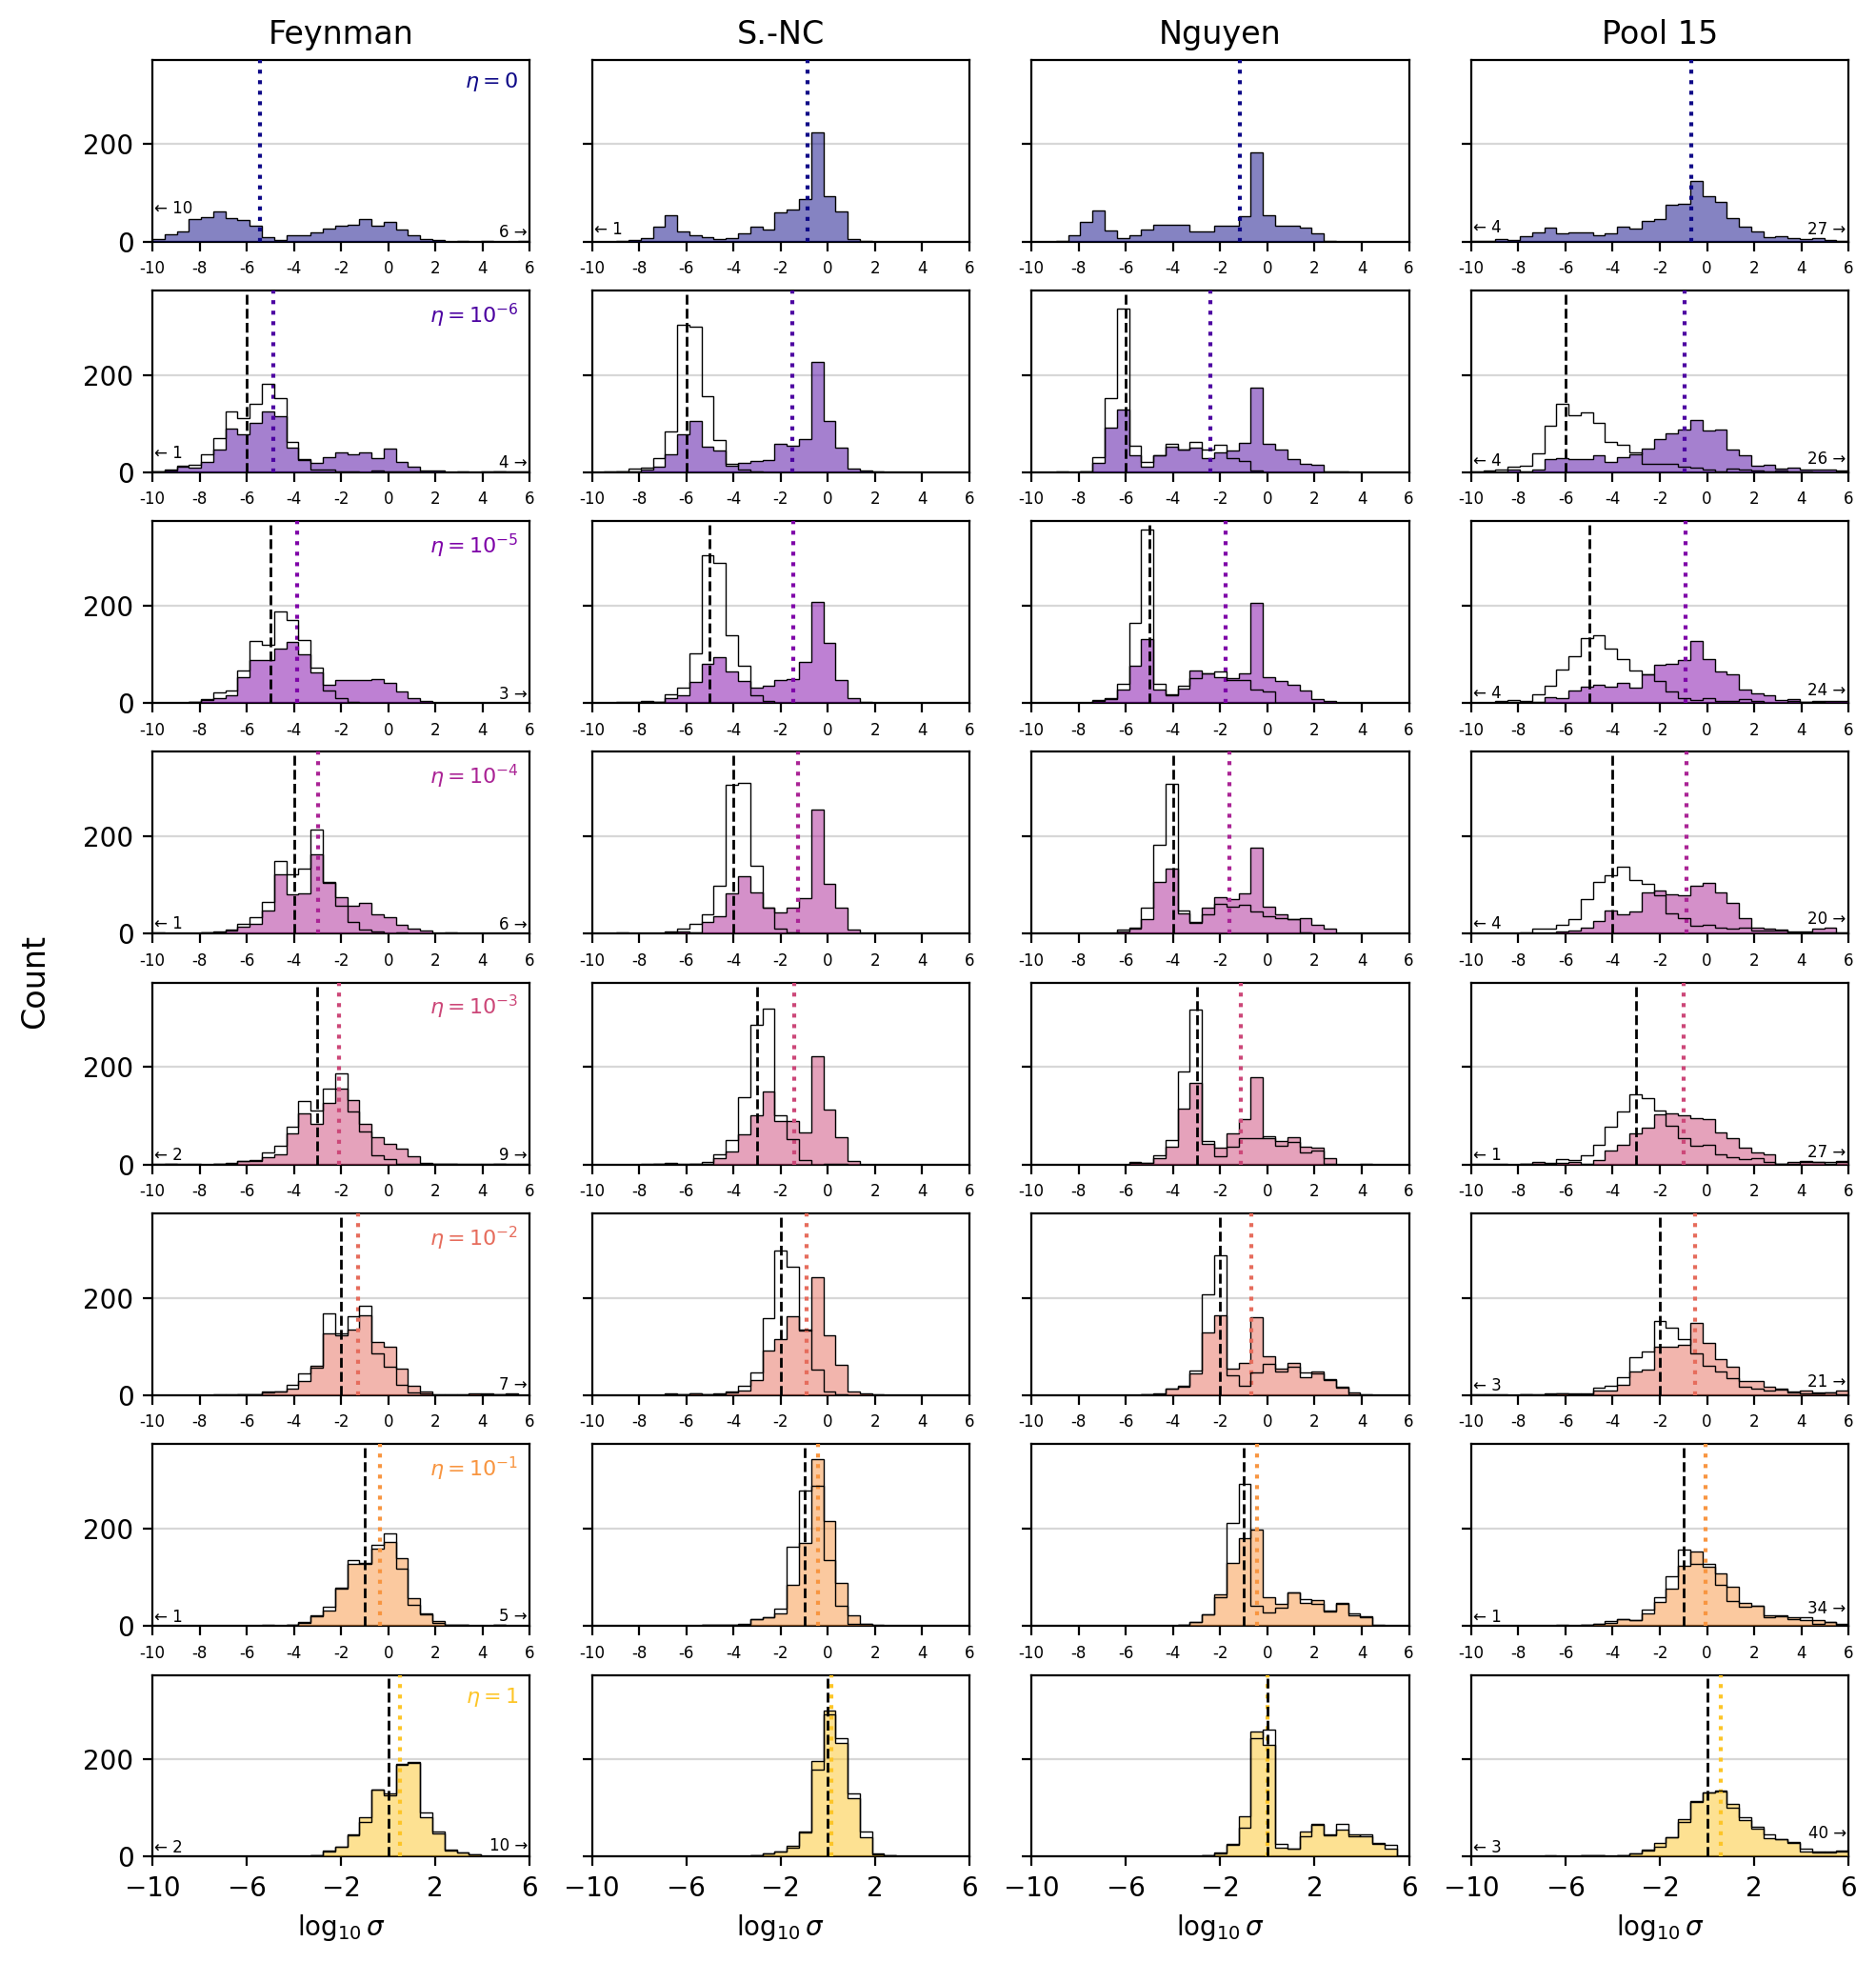

In [84]:
COLS = 4
ROWS = len(results)

xlim = (-10, 6)
bins = 32

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 2.5, ROWS * 1.3), dpi=200, sharey=True)

for i, (model, model_results) in enumerate(results.items()):
    for j, (test_set, test_set_results) in enumerate(model_results.items()):
        ax = axes[i, j]
        color = plt.get_cmap('plasma')(i / len(results))
        valid_data = test_set_results['data']['residuals_std']
        valid_data = valid_data[np.isfinite(valid_data) & (valid_data > 0)]
        ax.hist(np.log10(valid_data), bins=np.linspace(*xlim, bins), color=color, alpha=0.5, zorder=3, rasterized=True);
        ax.hist(np.log10(valid_data), bins=np.linspace(*xlim, bins), color='k', histtype='step', zorder=4, linewidth=0.5);

        if configs[model]['noise_level'] > 0:
            ax.axvline(np.log10(configs[model]['noise_level']), color='k', linestyle='--', zorder=5, linewidth=1)

        ax.axvline(np.log10(np.median(valid_data)), color=color, linestyle=':', zorder=4)

        values, edges = np.histogram(np.log10(valid_data), bins=np.linspace(*xlim, bins))
        
        valid_gt_data = test_set_results['data']['noise_std']
        valid_gt_data = valid_gt_data[np.isfinite(valid_gt_data) & (valid_gt_data > 0)]
        ax.hist(np.log10(valid_gt_data), bins=np.linspace(*xlim, bins), color='k', histtype='step', zorder=4, linewidth=0.5);

        # Annotate on the left and right edges of the axis the number less than and greater than the xlim
        if np.sum(valid_data < 10**xlim[0]) > 0:
            ax.text(xlim[0] + 0.1, np.max(values[:5]), f"← {np.sum(valid_data < 10**xlim[0])}", ha='left', va='bottom', fontsize=6)
        if np.sum(valid_data > 10**xlim[1]) > 0:
            ax.text(xlim[1] - 0.1, np.max(values[-5:]), f"{np.sum(valid_data > 10**xlim[1])} →", ha='right', va='bottom', fontsize=6)

        if i == 0:
            ax.set_title(TEST_SET_TITLES[test_set])

        if i == len(results) - 1:
            ax.set_xlabel('$\\log_{10} \\sigma$')
            ax.set_xticks(np.arange(-10, 8, 4))
        else:
            ax.set_xticks(np.arange(-10, 8, 2))
            ax.set_xticklabels(np.arange(-10, 8, 2), fontsize=6)

        ax.set_xlim(xlim)

        if j == 0:
            # ax.set_ylabel('Count')
            # ax.legend(loc='upper right')
            ax.annotate(f"$\\eta = {sci_to_latex(configs[model]['noise_level'])}$", xy=(0.97, 0.94), xycoords='axes fraction', fontsize=8, ha='right', va='top', color=color)

        ax.grid(alpha=0.5, zorder=0, axis='y')

fig.tight_layout(h_pad=0.5)
fig.supylabel('Count')
fig.subplots_adjust(left=0.09)

plt.savefig(get_path('results', 'analysis_noise', create=True, filename='noise_residuals_std_histogram.svg'))

/tmp/ipykernel_14259/925004002.py:14: RuntimeWarning: divide by zero encountered in log10
  counts, edges = np.histogram(np.log10(test_set_results['data']['residuals_std']), bins=np.linspace(*xlim, bins))
/tmp/ipykernel_14259/925004002.py:15: RuntimeWarning: divide by zero encountered in log10
  counts_background, edges_background = np.histogram(np.log10(results['analysis_noise/v6.0_0.0-noise'][test_set]['data']['residuals_std']), bins=np.linspace(*xlim, bins))


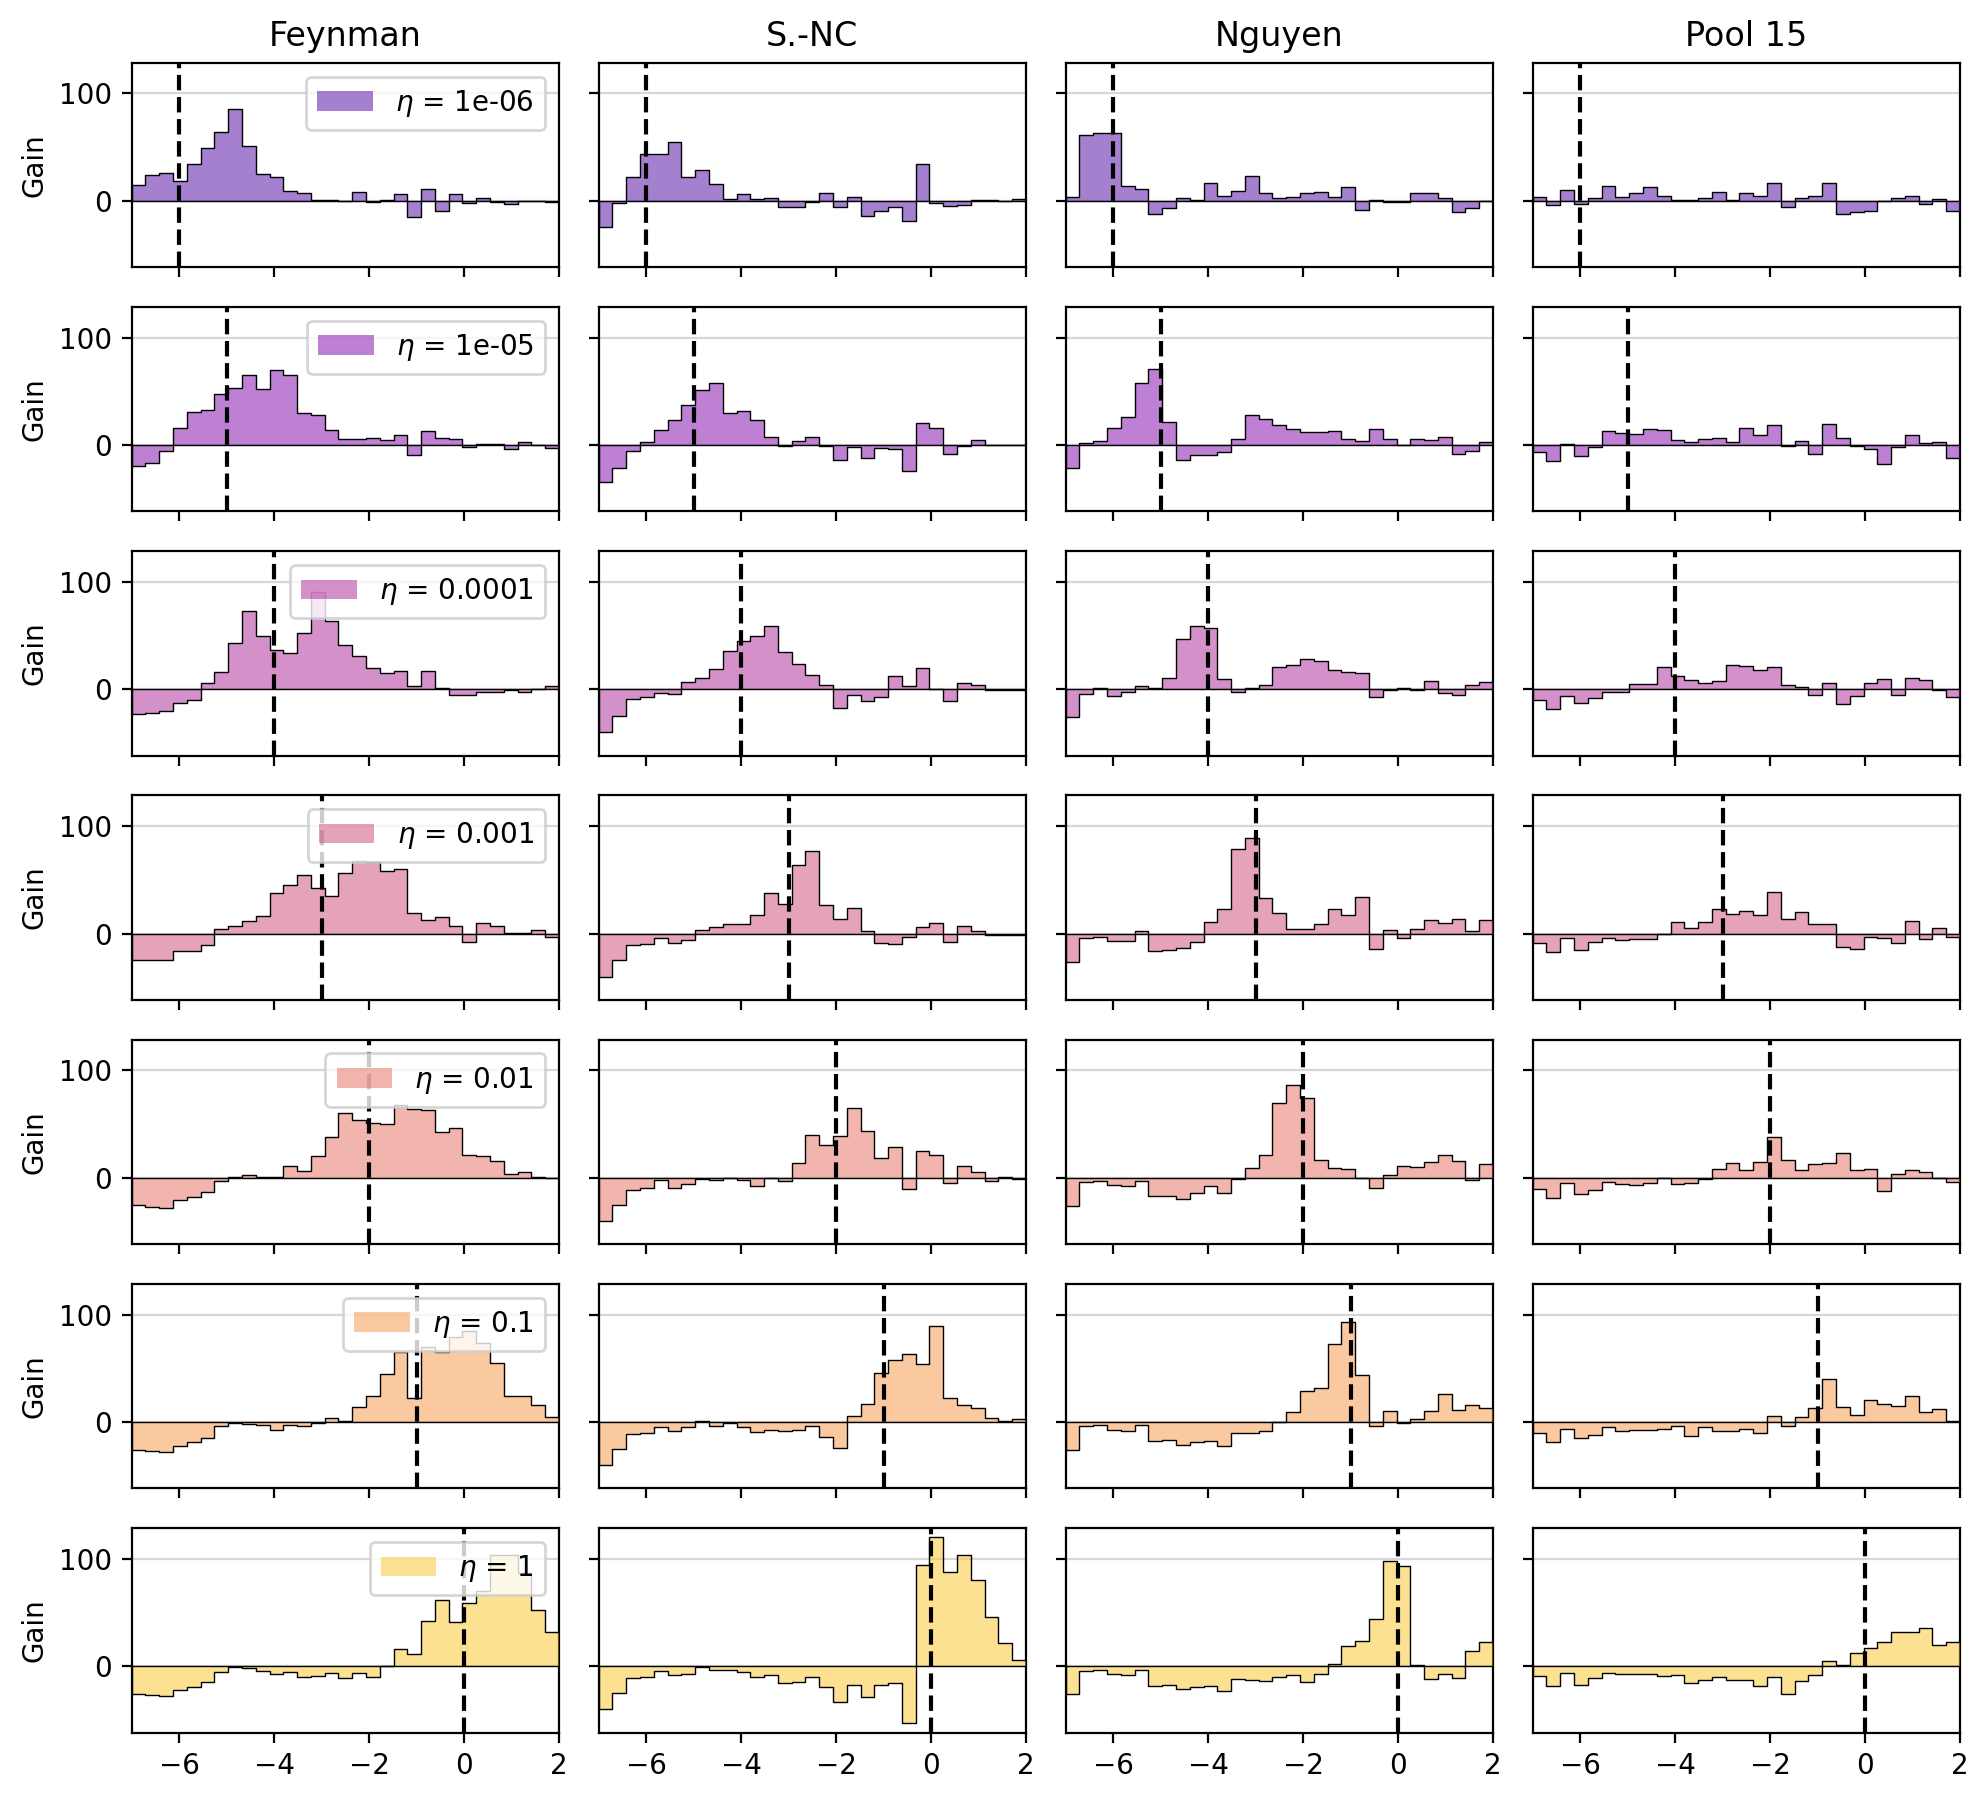

In [28]:
COLS = 4
ROWS = len(results) - 1


xlim = (-7, 2)
bins = 32

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 2.5, ROWS * 1.3), dpi=200, sharex=True, sharey=True)

for i, (model, model_results) in enumerate(list(results.items())[1:]):
    for j, (test_set, test_set_results) in enumerate(model_results.items()):
        ax = axes[i, j]
        color = plt.get_cmap('plasma')((i + 1) / len(results))
        counts, edges = np.histogram(np.log10(test_set_results['data']['residuals_std']), bins=np.linspace(*xlim, bins))
        counts_background, edges_background = np.histogram(np.log10(results['analysis_noise/v6.0_0.0-noise'][test_set]['data']['residuals_std']), bins=np.linspace(*xlim, bins))

        ax.bar(edges[:-1], counts - counts_background, width=np.diff(edges), color=color, alpha=0.5, label=f"$\\eta$ = {configs[model]['noise_level']}", align='edge', zorder=3, rasterized=True);

        # Outline
        x_list = [edges[0]]
        y_list = [0]

        for ledge, redge, value in zip(edges[:-1], edges[1:], counts - counts_background):
            x_list.extend([ledge, redge])
            y_list.extend([value, value])

        x_list.append(edges[-1])
        y_list.append(0)

        ax.plot(x_list, y_list, color='k', zorder=4, linewidth=0.5)

        ax.axhline(0, color='k', linewidth=0.5, zorder=4)

        # difference_error = np.sqrt(counts + counts_background)
        # centers = (edges[:-1] + edges[1:]) / 2
        # ax.errorbar(centers, counts - counts_background, yerr=difference_error, fmt='.', color=color, zorder=5, markersize=0, elinewidth=1, alpha=0.5)

        ax.set_xlim(xlim)
        ax.axvline(np.log10(configs[model]['noise_level']), color='k', linestyle='--', zorder=4)

        if i == 0:
            ax.set_title(TEST_SET_TITLES[test_set])

        if i == len(results) - 1:
            ax.set_xlabel('$log_{10}$(std(scaled residuals))')
            ax.set_xticks(np.arange(xlim[0], xlim[1] + 1, 1))

        if j == 0:
            ax.set_ylabel('Gain')
            ax.legend(loc='upper right')

        ax.grid(alpha=0.5, zorder=0, axis='y')

fig.tight_layout()

plt.savefig(get_path('results', 'analysis_noise', create=True, filename='noise_residuals_std_gain.svg'))

In [152]:
# Find the intersection of the columns of all the dataframes
compare_columns = set.union(*[set(test_set_results['data'].keys()) for model_results in results.values() for test_set_results in model_results.values()])
compare_columns = compare_columns - {'x', 'y', 'y_noisy', 'constants', 'input_ids', 'labels', 'residuals_beam_1', 'n_support', 'free_best_beam'}
compare_columns = compare_columns - {c for c in compare_columns if any(c.endswith(f'_{i}') or 'free' in c or 'quantiles' in c or 'residuals' in c or 'noise' in c for i in range(1, 1024))}
# compare_columns = compare_columns.union({'perplexity', 'precision_best_beam', 'recall_best_beam', 'meteor_best_beam', 'edit_distance'})
compare_columns

{'FVU-eps_accuracy',
 'L_inf_best_beam',
 'NSRTS_accuracy_close_best_beam',
 'NSRTS_accuracy_r2_best_beam',
 'accuracy_best_beam',
 'beam_search_time',
 'best_beam',
 'bleu_best_beam',
 'edit_distance_best_beam',
 'f1_score_best_beam',
 'fvu',
 'id_overfit',
 'is_finite',
 'is_overfit',
 'length_best_beam',
 'length_target',
 'log_fvu',
 'log_ppl',
 'meteor_best_beam',
 'mse_best_beam',
 'perplexity',
 'precision_best_beam',
 'r2_best_beam',
 'recall_best_beam',
 'reciprocal_rank',
 'refiner_time_best_beam',
 'rouge1_fmeasure_best_beam',
 'rouge1_precision_best_beam',
 'rouge1_recall_best_beam',
 'rouge2_fmeasure_best_beam',
 'rouge2_precision_best_beam',
 'rouge2_recall_best_beam',
 'rougeL_fmeasure_best_beam',
 'rougeL_precision_best_beam',
 'rougeL_recall_best_beam',
 'structural_accuracy_best_beam',
 'sys_time',
 'tree_edit_distance_best_beam',
 'wall_time',
 'y_std'}

In [153]:
array_dfs = {
    model: {
        test_set:
        pd.DataFrame({k: v for k, v in test_set_results['data'].items() if k in compare_columns}).astype(float)
            for test_set, test_set_results in model_results.items()}
            for model, model_results in results.items()}

In [154]:
compare_columns_defaults = {
    'FVU-eps_accuracy': 0,
    'perplexity': np.inf,
    'log_ppl': np.inf,
    'precision_best_beam': 0,
    'recall_best_beam': 0,
    'L_inf_best_beam': np.inf,
    'NSRTS_accuracy_close_best_beam': 0,
    'NSRTS_accuracy_r2_best_beam': 0,
    'accuracy_best_beam': 0,
    'bleu_best_beam': 0,
    'edit_distance_best_beam': np.inf,
    'f1_score_best_beam': 0,
    'log_fvu': np.inf,
    'log_ppl': np.inf,
    'meteor_best_beam': 0,
    'mse_best_beam': np.inf,
    'perplexity': np.inf,
    'precision_best_beam': 0,
    'r2_best_beam': -np.inf,
    'recall_best_beam': 0,
    'reciprocal_rank': 0,
    'rouge1_fmeasure_best_beam': 0,
    'rouge1_precision_best_beam': 0,
    'rouge1_recall_best_beam': 0,
    'rouge2_fmeasure_best_beam': 0,
    'rouge2_precision_best_beam': 0,
    'rouge2_recall_best_beam': 0,
    'rougeL_fmeasure_best_beam': 0,
    'rougeL_precision_best_beam': 0,
    'rougeL_recall_best_beam': 0,
    'structural_accuracy_best_beam': 0,
    'tree_edit_distance_best_beam': np.inf,
    'wall_time': np.inf,
    'sys_time': np.inf,
    'is_finite': 0,
}

In [155]:
from functools import partial

In [156]:
def naninfmean(x):
    return np.nanmean(np.array(x)[np.isfinite(x)])

# Per Dataset

In [157]:
summaries = {model: {test_set: {column: {} for column in compare_columns} for test_set, df in model_dfs.items()} for model, model_dfs in array_dfs.items()}
metrics = None

N_BOOTSTRAPS = 1_000

for model, model_dfs in array_dfs.items():
    for test_set, df in model_dfs.items():
        for column in tqdm(compare_columns, desc=f'{model} {test_set}'):
            sub_metrics = ['mean', 'median', '2.5p', '97.5p']
            sub_metrics_functions = [naninfmean, np.nanmedian, partial(np.nanpercentile, q=2.5), partial(np.nanpercentile, q=97.5)]
            if column in df.columns:
                data = df[column].replace({np.nan: compare_columns_defaults.get(column, np.nan)}).values
                summaries[model][test_set][column] = {m: bootstrapped_metric_ci(data, f, n=N_BOOTSTRAPS) for m, f in zip(sub_metrics, sub_metrics_functions)}
            else:
                summaries[model][test_set][column] = {k: (np.nan, ) * 3 for k in sub_metrics}

            if metrics is None:
                metrics = summaries[model][test_set][column].keys()

analysis_noise/v6.0_0.0-noise feynman:  18%|█▊        | 7/40 [00:00<00:03, 10.10it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
analysis_noise/v6.0_1-noise pool_15: 100%|██████████| 40/40 [00:04<00:00,  9.46it/s]


In [158]:
# Show a summary table for each metric
# In each table, the rows are the models and the columns are the test sets
# For columns with 'accuracy' in the name, show the mean. For other columns show the median.

summary_tables = {
    column: {
        metric: {
            percentile:
                pd.DataFrame({
                model: {
                    test_set: summaries[model][test_set][column][metric][k]
                    for test_set in summaries[model].keys()}
                    for model in summaries.keys()}).T.round(3)
                    for k, percentile in enumerate(['median', 'lower', 'upper'])}
                    for metric in metrics}
                    for column in compare_columns}

#### Validity

In [159]:
m = 'is_finite'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_noise/v6.0_0.0-noise,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_noise/v6.0_1e-6-noise,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_noise/v6.0_1e-5-noise,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_noise/v6.0_1e-4-noise,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_noise/v6.0_1e-3-noise,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_noise/v6.0_1e-2-noise,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","0.999 (0.997, 1.0)"
analysis_noise/v6.0_1e-1-noise,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"
analysis_noise/v6.0_1-noise,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)"


#### Recovery Rate

In [160]:
m = 'NSRTS_accuracy_close_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_noise/v6.0_0.0-noise,"0.805 (0.782, 0.83)","0.473 (0.438, 0.503)","0.668 (0.637, 0.697)","0.504 (0.472, 0.534)"
analysis_noise/v6.0_1e-6-noise,"0.817 (0.793, 0.839)","0.491 (0.462, 0.525)","0.635 (0.605, 0.664)","0.508 (0.474, 0.536)"
analysis_noise/v6.0_1e-5-noise,"0.8 (0.774, 0.824)","0.483 (0.452, 0.514)","0.604 (0.575, 0.634)","0.512 (0.48, 0.543)"
analysis_noise/v6.0_1e-4-noise,"0.766 (0.739, 0.791)","0.468 (0.438, 0.501)","0.573 (0.543, 0.604)","0.507 (0.473, 0.537)"
analysis_noise/v6.0_1e-3-noise,"0.632 (0.603, 0.662)","0.457 (0.425, 0.487)","0.527 (0.496, 0.559)","0.505 (0.474, 0.538)"
analysis_noise/v6.0_1e-2-noise,"0.292 (0.265, 0.32)","0.311 (0.283, 0.337)","0.362 (0.332, 0.388)","0.386 (0.356, 0.416)"
analysis_noise/v6.0_1e-1-noise,"0.099 (0.081, 0.118)","0.124 (0.104, 0.146)","0.211 (0.186, 0.237)","0.253 (0.226, 0.279)"
analysis_noise/v6.0_1-noise,"0.026 (0.016, 0.036)","0.021 (0.013, 0.03)","0.043 (0.03, 0.056)","0.08 (0.063, 0.096)"


In [161]:
m = 'NSRTS_accuracy_r2_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_noise/v6.0_0.0-noise,"0.944 (0.929, 0.958)","0.681 (0.65, 0.709)","0.82 (0.796, 0.845)","0.784 (0.758, 0.808)"
analysis_noise/v6.0_1e-6-noise,"0.945 (0.931, 0.959)","0.688 (0.658, 0.716)","0.817 (0.793, 0.841)","0.792 (0.768, 0.817)"
analysis_noise/v6.0_1e-5-noise,"0.941 (0.924, 0.956)","0.695 (0.665, 0.724)","0.789 (0.762, 0.813)","0.8 (0.776, 0.824)"
analysis_noise/v6.0_1e-4-noise,"0.951 (0.937, 0.964)","0.685 (0.656, 0.712)","0.829 (0.804, 0.85)","0.77 (0.744, 0.796)"
analysis_noise/v6.0_1e-3-noise,"0.934 (0.918, 0.95)","0.669 (0.641, 0.7)","0.82 (0.794, 0.842)","0.792 (0.768, 0.817)"
analysis_noise/v6.0_1e-2-noise,"0.919 (0.901, 0.935)","0.668 (0.64, 0.697)","0.828 (0.804, 0.851)","0.768 (0.742, 0.794)"
analysis_noise/v6.0_1e-1-noise,"0.812 (0.788, 0.834)","0.607 (0.579, 0.637)","0.762 (0.736, 0.787)","0.683 (0.652, 0.71)"
analysis_noise/v6.0_1-noise,"0.02 (0.012, 0.029)","0.002 (0.0, 0.005)","0.002 (0.0, 0.005)","0.017 (0.009, 0.025)"


In [162]:
m = 'FVU-eps_accuracy'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_noise/v6.0_0.0-noise,"0.714 (0.685, 0.742)","0.333 (0.302, 0.362)","0.537 (0.507, 0.57)","0.24 (0.213, 0.265)"
analysis_noise/v6.0_1e-6-noise,"0.706 (0.679, 0.733)","0.362 (0.332, 0.391)","0.513 (0.481, 0.542)","0.227 (0.202, 0.251)"
analysis_noise/v6.0_1e-5-noise,"0.693 (0.664, 0.722)","0.352 (0.323, 0.382)","0.483 (0.45, 0.516)","0.217 (0.194, 0.243)"
analysis_noise/v6.0_1e-4-noise,"0.69 (0.664, 0.718)","0.334 (0.305, 0.364)","0.518 (0.486, 0.548)","0.235 (0.209, 0.263)"
analysis_noise/v6.0_1e-3-noise,"0.028 (0.018, 0.039)","0.0 (0.0, 0.0)","0.0 (0.0, 0.0)","0.006 (0.002, 0.011)"
analysis_noise/v6.0_1e-2-noise,"0.024 (0.014, 0.034)","0.0 (0.0, 0.0)","0.0 (0.0, 0.0)","0.013 (0.006, 0.02)"
analysis_noise/v6.0_1e-1-noise,"0.022 (0.013, 0.031)","0.0 (0.0, 0.0)","0.0 (0.0, 0.0)","0.005 (0.001, 0.01)"
analysis_noise/v6.0_1-noise,"0.019 (0.011, 0.028)","0.0 (0.0, 0.0)","0.0 (0.0, 0.0)","0.008 (0.003, 0.014)"


#### Numeric Error

In [163]:
m = 'fvu'
sm = '97.5p'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_noise/v6.0_0.0-noise,"0.205 (0.11, 0.286)","0.695 (0.62, 0.77)","0.565 (0.524, 0.609)","0.59 (0.519, 0.672)"
analysis_noise/v6.0_1e-6-noise,"0.26 (0.118, 0.361)","0.654 (0.607, 0.707)","0.593 (0.547, 0.651)","0.599 (0.532, 0.721)"
analysis_noise/v6.0_1e-5-noise,"0.201 (0.17, 0.307)","0.716 (0.659, 0.768)","0.637 (0.566, 0.714)","0.587 (0.518, 0.65)"
analysis_noise/v6.0_1e-4-noise,"0.22 (0.106, 0.302)","0.672 (0.623, 0.735)","0.627 (0.583, 0.687)","0.593 (0.543, 0.727)"
analysis_noise/v6.0_1e-3-noise,"0.194 (0.117, 0.276)","0.701 (0.659, 0.751)","0.6 (0.539, 0.664)","0.682 (0.562, 0.83)"
analysis_noise/v6.0_1e-2-noise,"0.319 (0.255, 0.432)","0.711 (0.651, 0.742)","0.592 (0.551, 0.667)","0.587 (0.496, 0.692)"
analysis_noise/v6.0_1e-1-noise,"0.427 (0.379, 0.574)","0.737 (0.675, 0.798)","0.589 (0.547, 0.633)","0.67 (0.595, 0.751)"
analysis_noise/v6.0_1-noise,"0.994 (0.921, 1.031)","1.005 (0.965, 1.067)","0.897 (0.853, 0.966)","0.995 (0.909, 1.085)"


In [164]:
m = 'is_overfit'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_noise/v6.0_0.0-noise,"0.0 (0.0, 0.0)","0.0 (0.0, 0.0)","0.0 (0.0, 0.0)","0.0 (0.0, 0.0)"
analysis_noise/v6.0_1e-6-noise,"0.549 (0.518, 0.581)","0.205 (0.181, 0.231)","0.294 (0.267, 0.326)","0.118 (0.101, 0.14)"
analysis_noise/v6.0_1e-5-noise,"0.558 (0.526, 0.586)","0.25 (0.223, 0.278)","0.346 (0.319, 0.374)","0.151 (0.129, 0.174)"
analysis_noise/v6.0_1e-4-noise,"0.544 (0.513, 0.576)","0.256 (0.229, 0.283)","0.39 (0.359, 0.419)","0.179 (0.154, 0.204)"
analysis_noise/v6.0_1e-3-noise,"0.58 (0.55, 0.609)","0.29 (0.261, 0.317)","0.407 (0.377, 0.439)","0.198 (0.175, 0.224)"
analysis_noise/v6.0_1e-2-noise,"0.516 (0.484, 0.547)","0.272 (0.246, 0.303)","0.495 (0.463, 0.526)","0.243 (0.217, 0.269)"
analysis_noise/v6.0_1e-1-noise,"0.535 (0.503, 0.565)","0.304 (0.275, 0.333)","0.581 (0.552, 0.612)","0.334 (0.305, 0.364)"
analysis_noise/v6.0_1-noise,"0.762 (0.734, 0.788)","0.694 (0.666, 0.721)","0.812 (0.789, 0.835)","0.742 (0.717, 0.77)"


#### Time

In [60]:
m = 'wall_time'
sm = 'median'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_noise/v6.0_0.0-noise,"1.769 (1.739, 1.815)","1.721 (1.703, 1.736)","1.656 (1.641, 1.682)","1.828 (1.781, 1.919)"
analysis_noise/v6.0_1e-5-noise,"1.724 (1.708, 1.755)","1.717 (1.701, 1.738)","1.701 (1.689, 1.724)","1.901 (1.872, 1.928)"
analysis_noise/v6.0_1e-4-noise,"1.746 (1.709, 1.777)","1.491 (1.472, 1.51)","1.754 (1.736, 1.778)","1.742 (1.728, 1.759)"
analysis_noise/v6.0_1e-3-noise,"2.79 (2.537, 3.023)","1.65 (1.641, 1.659)","1.739 (1.706, 1.769)","1.86 (1.821, 1.927)"
analysis_noise/v6.0_1e-2-noise,"1.775 (1.75, 1.793)","1.717 (1.702, 1.743)","1.791 (1.752, 1.823)","1.809 (1.777, 1.839)"


In [61]:
m = 'sys_time'
sm = 'median'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_noise/v6.0_0.0-noise,"1.769 (1.739, 1.815)","1.722 (1.706, 1.734)","1.657 (1.641, 1.683)","1.828 (1.779, 1.933)"
analysis_noise/v6.0_1e-5-noise,"1.724 (1.709, 1.757)","1.717 (1.702, 1.736)","1.701 (1.688, 1.721)","1.901 (1.872, 1.929)"
analysis_noise/v6.0_1e-4-noise,"1.746 (1.708, 1.774)","1.491 (1.472, 1.51)","1.754 (1.735, 1.776)","1.742 (1.728, 1.759)"
analysis_noise/v6.0_1e-3-noise,"2.79 (2.578, 3.033)","1.65 (1.641, 1.659)","1.738 (1.705, 1.78)","1.862 (1.823, 1.927)"
analysis_noise/v6.0_1e-2-noise,"1.775 (1.75, 1.793)","1.718 (1.702, 1.743)","1.792 (1.753, 1.824)","1.809 (1.777, 1.839)"


#### Text Metrics

In [62]:
m = 'perplexity'
sm = 'median'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_noise/v6.0_0.0-noise,"4.879 (4.159, 5.748)","4.726 (4.356, 5.001)","7.129 (6.41, 8.112)","19.924 (16.843, 23.443)"
analysis_noise/v6.0_1e-5-noise,"4.546 (3.823, 5.624)","4.595 (4.272, 4.816)","6.983 (6.2, 8.218)","23.466 (20.257, 28.161)"
analysis_noise/v6.0_1e-4-noise,"5.324 (4.427, 6.58)","4.668 (4.355, 5.062)","7.678 (6.77, 8.595)","23.822 (20.872, 28.773)"
analysis_noise/v6.0_1e-3-noise,"7.189 (6.419, 8.38)","5.095 (4.686, 5.442)","8.42 (7.466, 10.027)","24.763 (20.693, 30.595)"
analysis_noise/v6.0_1e-2-noise,"12.191 (10.23, 13.884)","5.563 (5.122, 5.88)","14.798 (12.154, 16.825)","24.446 (21.744, 28.945)"


In [63]:
m = 'tree_edit_distance_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_noise/v6.0_0.0-noise,"11.225 (10.606, 11.823)","13.052 (12.539, 13.545)","15.684 (14.99, 16.347)","23.698 (23.022, 24.419)"
analysis_noise/v6.0_1e-5-noise,"14.097 (13.578, 14.585)","14.388 (13.921, 14.842)","18.237 (17.675, 18.808)","25.235 (24.622, 25.84)"
analysis_noise/v6.0_1e-4-noise,"14.51 (13.968, 15.043)","14.34 (13.882, 14.794)","17.676 (17.052, 18.297)","25.092 (24.467, 25.784)"
analysis_noise/v6.0_1e-3-noise,"14.765 (14.214, 15.285)","14.654 (14.215, 15.085)","18.671 (18.042, 19.288)","25.057 (24.432, 25.681)"
analysis_noise/v6.0_1e-2-noise,"17.584 (17.014, 18.111)","15.685 (15.195, 16.102)","20.239 (19.576, 20.866)","25.557 (24.936, 26.2)"


In [64]:
m = 'f1_score_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_noise/v6.0_0.0-noise,"0.891 (0.884, 0.897)","0.823 (0.814, 0.832)","0.778 (0.769, 0.789)","0.825 (0.819, 0.832)"
analysis_noise/v6.0_1e-5-noise,"0.843 (0.837, 0.85)","0.801 (0.792, 0.81)","0.733 (0.725, 0.741)","0.807 (0.801, 0.814)"
analysis_noise/v6.0_1e-4-noise,"0.834 (0.826, 0.841)","0.804 (0.794, 0.812)","0.734 (0.726, 0.743)","0.806 (0.799, 0.813)"
analysis_noise/v6.0_1e-3-noise,"0.834 (0.827, 0.84)","0.799 (0.791, 0.808)","0.728 (0.719, 0.736)","0.81 (0.803, 0.816)"
analysis_noise/v6.0_1e-2-noise,"0.817 (0.81, 0.824)","0.784 (0.775, 0.792)","0.704 (0.694, 0.713)","0.796 (0.79, 0.804)"


In [65]:
m = 'meteor_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_noise/v6.0_0.0-noise,"0.667 (0.651, 0.683)","0.582 (0.566, 0.599)","0.507 (0.49, 0.525)","0.448 (0.435, 0.463)"
analysis_noise/v6.0_1e-5-noise,"0.578 (0.564, 0.591)","0.555 (0.539, 0.57)","0.44 (0.426, 0.455)","0.415 (0.404, 0.427)"
analysis_noise/v6.0_1e-4-noise,"0.574 (0.56, 0.588)","0.552 (0.537, 0.567)","0.452 (0.437, 0.468)","0.417 (0.406, 0.428)"
analysis_noise/v6.0_1e-3-noise,"0.577 (0.564, 0.591)","0.546 (0.532, 0.56)","0.457 (0.444, 0.473)","0.416 (0.404, 0.427)"
analysis_noise/v6.0_1e-2-noise,"0.541 (0.528, 0.555)","0.517 (0.501, 0.532)","0.46 (0.445, 0.474)","0.405 (0.394, 0.416)"


In [66]:
m = 'edit_distance_best_beam'
sm = 'mean'
summary_tables[m][sm]['median'].astype(str) + ' (' + summary_tables[m][sm]['lower'].astype(str) + ', ' + summary_tables[m][sm]['upper'].astype(str) + ')'

,feynman,soose_nc,nguyen,pool_15
analysis_noise/v6.0_0.0-noise,"4.293 (4.078, 4.522)","4.949 (4.755, 5.137)","5.109 (4.886, 5.34)","9.674 (9.367, 10.006)"
analysis_noise/v6.0_1e-5-noise,"5.445 (5.284, 5.635)","5.357 (5.188, 5.522)","5.927 (5.739, 6.104)","10.278 (10.019, 10.547)"
analysis_noise/v6.0_1e-4-noise,"5.547 (5.357, 5.733)","5.443 (5.266, 5.608)","5.747 (5.559, 5.946)","10.201 (9.941, 10.468)"
analysis_noise/v6.0_1e-3-noise,"5.784 (5.596, 5.972)","5.483 (5.307, 5.658)","6.043 (5.857, 6.234)","10.117 (9.867, 10.372)"
analysis_noise/v6.0_1e-2-noise,"7.001 (6.806, 7.189)","5.903 (5.728, 6.065)","6.651 (6.451, 6.84)","10.333 (10.07, 10.592)"


In [67]:
def table_to_typst(tables, column, metric, caption, test_set_titles, tag, negate=False, objective='max', font_size=9, ci_font_size=7, fmt_fn=None, factor=1):
    if fmt_fn is None:
        fmt_fn = lambda x: f'{x:.2f}'

    main_df = tables[column][metric]['median'] * (-1 if negate else 1)
    lower_df = tables[column][metric]['lower'] * (-1 if negate else 1)
    upper_df = tables[column][metric]['upper'] * (-1 if negate else 1)

    # Determine the best model for each test set
    best_model = main_df.idxmax(axis=0) if objective == 'max' else main_df.idxmin(axis=0)

    if objective == 'max':
        equal_mask = pd.DataFrame({test_set: upper_df[test_set] >= lower_df.loc[best_model[test_set], test_set] for test_set in test_set_titles.keys() if test_set in upper_df})
    else:
        equal_mask = pd.DataFrame({test_set: lower_df[test_set] <= upper_df.loc[best_model[test_set], test_set] for test_set in test_set_titles.keys() if test_set in lower_df})

    # print(equal_mask)

    output = f'''
#figure(
  [
    #show <table_CI>: set text({ci_font_size}pt)
    #text(
    size:{font_size}pt,
    table(
    stroke: (x, y) => if x == 0 or x == 2 {{
      (right: (
      thickness: 0.5pt,
      ))
    }},
    inset: 6.5pt,
    columns: (auto, auto, auto, auto, auto, auto, auto),
    align: center + horizon,
    table.hline(),
'''

    output += f"  [*Model*], "
    for test_set in test_set_titles.values():
        output += f"[*{test_set}*], "
    output += "\n  table.hline(stroke: 0.5pt),\n"

    for main_row, lower_row, upper_row, equal_best_row in zip(main_df.iterrows(), lower_df.iterrows(), upper_df.iterrows(), equal_mask.iterrows()):
        flash = '#emoji.lightning ' if main_row[0].startswith('v') else ''
        output += f"  [{flash + MODELS_DESCRIPTION[main_row[0]]}], "
        output += ", ".join([
            '[' + ("*" if equal_best_row[1].get(test_set, False) else '') + f"{fmt_fn(main_row[1].get(test_set, np.nan) * factor)}\ ({fmt_fn(lower_row[1].get(test_set, np.nan) * factor)}, {fmt_fn(upper_row[1].get(test_set, np.nan) * factor)}) <table_CI>" + ("*" if equal_best_row[1].get(test_set, False) else '') + ']'
            for test_set in test_set_titles.keys()
        ]) + ",\n"

    output = output.replace('nan', '---')

    output += f'''
    table.hline(),
  ))],
  caption: [{caption}],
  gap: 1.2em,
) <{tag}>
'''

    return output

def fmt_fn_100(x):
    if np.isnan(x):
        return '---'
    if np.isinf(x):
        return 'oo'
    sign = '' if x > 0 else ''
    if np.abs(x) < 10:
        return f'{sign}{x:.2f}'
    if np.abs(x) < 100:
        return f'{sign}{x:.1f}'
    if np.abs(x) < 1_000:
        return f'{sign}{int(x)}'
    if np.abs(x) < 10_000:
        return f'{sign}{np.round(x / 1_000, 2)}k'
    if np.abs(x) < 100_000:
        return f'{sign}{np.round(x / 1_000, 1)}k'
    if np.abs(x) < 1_000_000:
        return f'{sign}{int(x / 1_000)}k'
    return f'{sign}{np.round(x / 1_000_000, 2)}M'

In [68]:
print(table_to_typst(summary_tables, 'FVU-eps_accuracy', 'mean', caption='*Recovery Rate in $bold("%"_("FVU" <= space epsilon) attach(arrow.t, tr:[0, 100]))$.* Bootstrapped Median (P#sub[2.5], P#sub[97.5])', test_set_titles=TEST_SET_TITLES, tag='tab:results_fvu_eps_rate', factor=100, fmt_fn=fmt_fn_100))


#figure(
  [
    #show <table_CI>: set text(7pt)
    #text(
    size:9pt,
    table(
    stroke: (x, y) => if x == 0 or x == 2 {
      (right: (
      thickness: 0.5pt,
      ))
    },
    inset: 6.5pt,
    columns: (auto, auto, auto, auto, auto, auto, auto),
    align: center + horizon,
    table.hline(),
  [*Model*], [*Train*], [*Val*], [*Feynman*], [*S.-NC*], [*Nguyen*], [*Pool 15*], 
  table.hline(stroke: 0.5pt),
  [analysis_noise/0.0-noise], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [*71.4\ (68.5, 74.1) <table_CI>*], [*33.2\ (30.4, 36.1) <table_CI>*], [*53.7\ (50.9, 57.1) <table_CI>*], [*23.8\ (21.2, 26.5) <table_CI>*],
  [analysis_noise/1e-5-noise], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [*69.3\ (66.3, 72.2) <table_CI>*], [*35.2\ (32.2, 38.1) <table_CI>*], [*48.4\ (45.5, 51.6) <table_CI>*], [*21.8\ (19.3, 24.4) <table_CI>*],
  [analysis_noise/1e-4-noise], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [*69.2\ (66.2, 71.9) <tabl

In [69]:
print(table_to_typst(summary_tables, 'NSRTS_accuracy_r2_best_beam', 'mean', caption='*Recovery Rate in $bold("%"_(R^2 space > space 0.95) attach(arrow.t, tr:[0, 100]))$.* Bootstrapped Median (P#sub[2.5], P#sub[97.5])', test_set_titles=TEST_SET_TITLES, tag='tab:results_r2_rate', factor=100, fmt_fn=fmt_fn_100))


#figure(
  [
    #show <table_CI>: set text(7pt)
    #text(
    size:9pt,
    table(
    stroke: (x, y) => if x == 0 or x == 2 {
      (right: (
      thickness: 0.5pt,
      ))
    },
    inset: 6.5pt,
    columns: (auto, auto, auto, auto, auto, auto, auto),
    align: center + horizon,
    table.hline(),
  [*Model*], [*Train*], [*Val*], [*Feynman*], [*S.-NC*], [*Nguyen*], [*Pool 15*], 
  table.hline(stroke: 0.5pt),
  [analysis_noise/0.0-noise], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [*94.5\ (93.0, 95.8) <table_CI>*], [*68.0\ (65.3, 70.9) <table_CI>*], [*82.1\ (79.5, 84.4) <table_CI>*], [*78.4\ (75.9, 80.8) <table_CI>*],
  [analysis_noise/1e-5-noise], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [*94.1\ (92.6, 95.4) <table_CI>*], [*69.5\ (66.6, 72.4) <table_CI>*], [*78.9\ (76.4, 81.4) <table_CI>*], [*80.1\ (77.4, 82.4) <table_CI>*],
  [analysis_noise/1e-4-noise], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [*95.1\ (93.7, 96.3) <tabl

In [70]:
print(table_to_typst(summary_tables, 'edit_distance_best_beam', 'mean', caption='*Levenshtein Edit Distance $bold(attach(arrow.b, tr:[0, oo]))$.* Bootstrapped Median (P#sub[2.5], P#sub[97.5])', test_set_titles=TEST_SET_TITLES, tag='tab:results_edit_distance', objective='min'))


#figure(
  [
    #show <table_CI>: set text(7pt)
    #text(
    size:9pt,
    table(
    stroke: (x, y) => if x == 0 or x == 2 {
      (right: (
      thickness: 0.5pt,
      ))
    },
    inset: 6.5pt,
    columns: (auto, auto, auto, auto, auto, auto, auto),
    align: center + horizon,
    table.hline(),
  [*Model*], [*Train*], [*Val*], [*Feynman*], [*S.-NC*], [*Nguyen*], [*Pool 15*], 
  table.hline(stroke: 0.5pt),
  [analysis_noise/0.0-noise], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [*4.29\ (4.08, 4.52) <table_CI>*], [*4.95\ (4.75, 5.14) <table_CI>*], [*5.11\ (4.89, 5.34) <table_CI>*], [*9.67\ (9.37, 10.01) <table_CI>*],
  [analysis_noise/1e-5-noise], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [5.45\ (5.28, 5.63) <table_CI>], [5.36\ (5.19, 5.52) <table_CI>], [5.93\ (5.74, 6.10) <table_CI>], [10.28\ (10.02, 10.55) <table_CI>],
  [analysis_noise/1e-4-noise], [---\ (---, ---) <table_CI>], [---\ (---, ---) <table_CI>], [5.55\ (5.36, 5.73) <table_CI>

# Aggregated

In [71]:
def fmt_fn_100(x):
    if np.isnan(x):
        return '---'
    if np.isinf(x):
        return 'oo'
    sign = '' if x > 0 else ''
    if np.abs(x) < 10:
        return f'{sign}{x:.2f}'
    if np.abs(x) < 100:
        return f'{sign}{x:.1f}'
    if np.abs(x) < 1_000:
        return f'{sign}{int(x)}'
    if np.abs(x) < 10_000:
        return f'{sign}{np.round(x / 1_000, 2)}k'
    if np.abs(x) < 100_000:
        return f'{sign}{np.round(x / 1_000, 1)}k'
    if np.abs(x) < 1_000_000:
        return f'{sign}{int(x / 1_000)}k'
    return f'{sign}{np.round(x / 1_000_000, 2)}M'

In [72]:
sub_metrics = ['mean', 'median', '2.5p', '97.5p']
sub_metrics_functions = [naninfmean, np.nanmedian, partial(np.nanpercentile, q=2.5), partial(np.nanpercentile, q=97.5)]

total_summary = {model: {column: {k: (np.nan, ) * 3 for k in sub_metrics} for column in compare_columns} for model in array_dfs.keys()}
aggregate_sets = ['feynman', 'soose_nc', 'nguyen', 'pool_15']
metrics = None

N_BOOTSTRAPS = 1_000

for model, model_dfs in array_dfs.items():
    if len(model_dfs) == 0:
        continue
    aggregated_data = pd.concat([df for test_set, df in model_dfs.items() if test_set in aggregate_sets])

    for column in tqdm(compare_columns, desc=f'{model}'):
        if column in aggregated_data.columns:
            data = aggregated_data[column].replace({np.nan: compare_columns_defaults.get(column, np.nan)}).values
            total_summary[model][column] = {m: bootstrapped_metric_ci(data, f, n=N_BOOTSTRAPS) for m, f in zip(sub_metrics, sub_metrics_functions)}

    if metrics is None:
        metrics = total_summary[model][column].keys()

analysis_noise/v6.0_0.0-noise:   5%|▌         | 2/38 [00:00<00:08,  4.44it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
analysis_noise/v6.0_1e-2-noise: 100%|██████████| 38/38 [00:08<00:00,  4.31it/s]


In [73]:
total_summary_tables = {
    metric: {
        percentile:
            pd.DataFrame({
            model: {
                column: total_summary[model][column][metric][k]
                for column in compare_columns}
                for model in total_summary.keys()}).T.round(3)
                for k, percentile in enumerate(['median', 'lower', 'upper'])}
                for metric in metrics}

In [74]:
columns = [c for c in total_summary_tables['mean']['median'].T.index if 'accuracy' in c]
total_summary_tables['mean']['median'].T.loc[columns].sort_index().astype(str) + ' (' + total_summary_tables['mean']['lower'].T.loc[columns].sort_index().astype(str) + ', ' + total_summary_tables['mean']['upper'].T.loc[columns].sort_index().astype(str) + ')'

,analysis_noise/v6.0_0.0-noise,analysis_noise/v6.0_1e-5-noise,analysis_noise/v6.0_1e-4-noise,analysis_noise/v6.0_1e-3-noise,analysis_noise/v6.0_1e-2-noise
FVU-eps_accuracy,"0.456 (0.44, 0.471)","0.436 (0.42, 0.451)","0.444 (0.428, 0.461)","0.009 (0.006, 0.011)","0.009 (0.006, 0.012)"
NSRTS_accuracy_close_best_beam,"0.612 (0.598, 0.628)","0.6 (0.585, 0.616)","0.578 (0.563, 0.593)","0.53 (0.514, 0.544)","0.339 (0.324, 0.353)"
NSRTS_accuracy_r2_best_beam,"0.807 (0.795, 0.82)","0.806 (0.795, 0.819)","0.808 (0.797, 0.82)","0.803 (0.791, 0.815)","0.795 (0.783, 0.808)"
accuracy_best_beam,"0.163 (0.152, 0.175)","0.045 (0.039, 0.052)","0.055 (0.048, 0.062)","0.044 (0.037, 0.05)","0.037 (0.031, 0.043)"
structural_accuracy_best_beam,"1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (1.0, 1.0)","1.0 (0.999, 1.0)"


In [75]:
columns = ['edit_distance_best_beam', 'tree_edit_distance_best_beam', 'f1_score_best_beam', 'meteor_best_beam', 'precision_best_beam', 'bleu_best_beam', 'recall_best_beam', 'rougeL_recall_best_beam', 'reciprocal_rank', 'perplexity', 'log_ppl', 'fvu', 'log_fvu',  'sys_time', 'wall_time']
total_summary_tables['mean']['median'].T.loc[columns].astype(str) + ' (' + total_summary_tables['mean']['lower'].T.loc[columns].astype(str) + ', ' + total_summary_tables['mean']['upper'].T.loc[columns].astype(str) + ')'

,analysis_noise/v6.0_0.0-noise,analysis_noise/v6.0_1e-5-noise,analysis_noise/v6.0_1e-4-noise,analysis_noise/v6.0_1e-3-noise,analysis_noise/v6.0_1e-2-noise
edit_distance_best_beam,"6.009 (5.875, 6.149)","6.748 (6.633, 6.863)","6.729 (6.605, 6.847)","6.863 (6.739, 6.979)","7.476 (7.352, 7.587)"
tree_edit_distance_best_beam,"15.906 (15.549, 16.251)","17.99 (17.682, 18.306)","17.888 (17.586, 18.204)","18.292 (17.992, 18.624)","19.755 (19.462, 20.057)"
f1_score_best_beam,"0.83 (0.825, 0.834)","0.796 (0.792, 0.799)","0.794 (0.79, 0.798)","0.793 (0.789, 0.797)","0.775 (0.771, 0.779)"
meteor_best_beam,"0.551 (0.543, 0.56)","0.497 (0.49, 0.504)","0.499 (0.492, 0.506)","0.498 (0.491, 0.506)","0.48 (0.474, 0.486)"
precision_best_beam,"0.852 (0.848, 0.857)","0.81 (0.805, 0.814)","0.806 (0.801, 0.811)","0.8 (0.795, 0.805)","0.776 (0.771, 0.782)"
bleu_best_beam,"0.293 (0.282, 0.303)","0.192 (0.185, 0.199)","0.199 (0.191, 0.206)","0.196 (0.189, 0.203)","0.179 (0.172, 0.186)"
recall_best_beam,"0.822 (0.817, 0.827)","0.803 (0.799, 0.808)","0.805 (0.8, 0.81)","0.808 (0.803, 0.813)","0.801 (0.796, 0.806)"
rougeL_recall_best_beam,"0.641 (0.634, 0.648)","0.568 (0.562, 0.573)","0.572 (0.566, 0.577)","0.559 (0.553, 0.565)","0.527 (0.521, 0.532)"
reciprocal_rank,"0.764 (0.76, 0.768)","0.764 (0.759, 0.768)","0.758 (0.754, 0.762)","0.748 (0.744, 0.752)","0.72 (0.715, 0.724)"
perplexity,"31952.663 (12397.383, 71332.97)","8757.61 (6080.115, 12183.867)","38760.824 (8003.247, 113344.582)","44767.07 (15983.735, 86711.398)","15471.91 (6218.97, 28482.46)"


In [76]:
def summary_table_to_typst(summary_tables, metrics, metric_submetrics, default_submetric, caption,
                           tag, objectives=None, font_size=9, ci_font_size=7, fmt_fn=None, metric_factors=None,
                           metric_aliases=None, hline_after=None):
    if fmt_fn is None:
        fmt_fn = lambda x: f'{x:.2f}'

    if objectives is None:
        objectives = {m: 'max' for m in metrics}

    if metric_factors is None:
        metric_factors = {m: 1 for m in metrics}

    if metric_aliases is None:
        metric_aliases = {m: m.replace('_', ' ').replace(' best beam', '') for m in metrics}

    main_df = pd.DataFrame({m: summary_tables[metric_submetrics.get(m, default_submetric)]['median'].T.loc[m] for m in metrics}).T
    lower_df = pd.DataFrame({m: summary_tables[metric_submetrics.get(m, default_submetric)]['lower'].T.loc[m] for m in metrics}).T
    upper_df = pd.DataFrame({m: summary_tables[metric_submetrics.get(m, default_submetric)]['upper'].T.loc[m] for m in metrics}).T
    # Determine the best model for each test set
    best_model = {m: main_df.loc[m].idxmax() if objectives[m] == 'max' else main_df.loc[m].idxmin() for m in metrics}
    equal_mask = pd.concat([upper_df.loc[m] >= lower_df.loc[m, best_model[m]] if objectives[m] == 'max' else lower_df.loc[m] <= upper_df.loc[m, best_model[m]] for m in metrics], axis=1).T


    output = f'''
#figure(
    [
        #show <table_CI>: set text({ci_font_size}pt)
        #text(
        size:{font_size}pt,
        table(
        stroke: (x, y) => if x == 0 {{
        (right: (
        thickness: 0.5pt,
        ))
        }},
        inset: 6.5pt,
        columns: ({', '.join(['auto' for _ in range(main_df.shape[1] + 1)])}),
        align: center + horizon,
        table.hline(),
    '''
    
    output += f"  [*Metric*], "
    for model in main_df.columns:
        flash = '#emoji.lightning ' if model.startswith('v') else ''
        output += f"[*{flash + model}*], "
    output += "\n  table.hline(stroke: 0.5pt),\n"
    
    for main_row, lower_row, upper_row, equal_best_row in zip(main_df.iterrows(), lower_df.iterrows(), upper_df.iterrows(), equal_mask.iterrows()):
        factor = metric_factors.get(main_row[0], 1)
        alias = metric_aliases.get(main_row[0], main_row[0])
        output += f"  [{alias}], \n"
        output += ", ".join([
            '['
                + ("*" if equal_best_row[1].get(m, False) else '')
                    + f"${fmt_fn(main_row[1].get(m, np.nan) * factor)}$\ #[(${fmt_fn(lower_row[1].get(m, np.nan) * factor)}$, ${fmt_fn(upper_row[1].get(m, np.nan) * factor)}$)] <table_CI>"
                + ("*" if equal_best_row[1].get(m, False) else '')
            + ']'
            for m in main_row[1].keys()
        ]) + ",\n"
        if hline_after is not None and main_row[0] in hline_after:
            output += f'  table.hline(stroke: (thickness:0.5pt, dash:"dotted")),\n'

    output = output.replace('$---$', '---').replace('nesymres-100M', 'N100').replace('pysr', 'PySR')

    output += f'''
    table.hline(),
    ))],
    caption: [{caption}],
    gap: 1.2em,
) <{tag}>
'''

    return output

In [77]:
columns = ['is_finite', 'FVU-eps_accuracy', 'NSRTS_accuracy_close_best_beam', 'NSRTS_accuracy_r2_best_beam', 'accuracy_best_beam']
columns += ['edit_distance_best_beam', 'tree_edit_distance_best_beam', 'f1_score_best_beam', 'precision_best_beam', 'recall_best_beam', 'reciprocal_rank', 'perplexity', 'log_fvu', 'sys_time', 'wall_time']

metric_aliases = {
    "FVU-eps_accuracy": '$"%"_("FVU" <= space epsilon) attach(arrow.t, tr:[0, 100])$',
    "NSRTS_accuracy_close_best_beam": '$"%"_(hat(f)(X) approx Y) attach(arrow.t, tr:[0, 100])$',
    "NSRTS_accuracy_r2_best_beam": '$"%"_(R^2 space > space 0.95) attach(arrow.t, tr:[0, 100])$',
    "accuracy_best_beam": '$%_(hat(Z) = Z) attach(arrow.t, tr:[0, 100])$',
    "is_finite": '$"%"_("valid") attach(arrow.t, tr:[0, 100])$',
    "edit_distance_best_beam": 'LEV $attach(arrow.b, tr:[0, oo])$ \ Levenshtein Distance<table_CI>',
    "tree_edit_distance_best_beam":	'ZSS $attach(arrow.b, tr:[0, oo])$ \ Tree-Edit Distance<table_CI>',
    "f1_score_best_beam": 'F1 $attach(arrow.t, tr:[0, 1])$',
    "meteor_best_beam":	'METEOR $attach(arrow.t, tr:[0, 1])$',
    "precision_best_beam":	'Precision $attach(arrow.t, tr:[0, 1])$',
    "bleu_best_beam": 'BLEU $attach(arrow.t, tr:[0, 1])$',
    "recall_best_beam":	'Recall $attach(arrow.t, tr:[0, 1])$',
    "rougeL_recall_best_beam": 'Rouge-L Recall $attach(arrow.t, tr:[0, 1])$',
    "reciprocal_rank": 'RR $attach(arrow.t, tr:[0, 1])$ \ Reciprocal Rank<table_CI>',
    "perplexity": 'PPL\* $attach(arrow.b, tr:[0, oo])$ \ Perplexity<table_CI>',
    "log_ppl": 'log PPL $attach(arrow.b, tr:[0, oo])$',
    "fvu": 'FVU $attach(arrow.b, tr:[0, oo])$ \ Unexplained Variance<table_CI>',
    "log_fvu": 'log FVU $attach(arrow.b, tr:[0, oo])$',
    "sys_time": 'T#sub("sys") $attach(arrow.b, tr:[0, oo])$ \ System Time<table_CI>',
    "wall_time": 'T#sub("wall") $attach(arrow.b, tr:[0, oo])$ \ Wall Time<table_CI>',
}

metric_objectives = {
    "FVU-eps_accuracy": 'max',
    "NSRTS_accuracy_close_best_beam": 'max',
    "NSRTS_accuracy_r2_best_beam": 'max',
    "accuracy_best_beam": 'max',
    "is_finite": 'max',
    "edit_distance_best_beam":	'min',
    "tree_edit_distance_best_beam":	'min',
    "f1_score_best_beam": 'max',
    "meteor_best_beam":	'max',
    "precision_best_beam":	'max',
    "bleu_best_beam": 'max',
    "recall_best_beam":	'max',
    "rougeL_recall_best_beam": 'max',
    "reciprocal_rank": 'max',
    "perplexity": 'min',
    "log_ppl": 'min',
    "fvu": 'min',
    "log_fvu": 'min',
    "sys_time": 'min',
    "wall_time": 'min',
}

metric_factors = {
    "FVU-eps_accuracy": 100,
    "NSRTS_accuracy_close_best_beam": 100,
    "NSRTS_accuracy_r2_best_beam": 100,
    "accuracy_best_beam": 100,
    "is_finite": 100,
}

metric_submetrics = {
    "FVU-eps_accuracy": 'mean',
    "NSRTS_accuracy_close_best_beam": 'mean',
    "NSRTS_accuracy_r2_best_beam": 'mean',
    "accuracy_best_beam": 'mean',
    "perplexity": 'median',
}


print(summary_table_to_typst(
    total_summary_tables,
    columns,
    metric_submetrics=metric_submetrics,
    default_submetric='mean',
    caption='*Metric Means across all Test Sets for all Models.* Bootstrapped Median (P#sub[2.5], P#sub[97.5]). \*Median Perplexity.',
    tag='tab:results_aggregated',
    objectives=metric_objectives,
    fmt_fn=fmt_fn_100,
    metric_aliases=metric_aliases,
    metric_factors=metric_factors,
    hline_after=['is_finite', 'accuracy_best_beam', 'log_fvu', 'perplexity'],
))


#figure(
    [
        #show <table_CI>: set text(7pt)
        #text(
        size:9pt,
        table(
        stroke: (x, y) => if x == 0 {
        (right: (
        thickness: 0.5pt,
        ))
        },
        inset: 6.5pt,
        columns: (auto, auto, auto, auto, auto, auto),
        align: center + horizon,
        table.hline(),
      [*Metric*], [*analysis_noise/v6.0_0.0-noise*], [*analysis_noise/v6.0_1e-5-noise*], [*analysis_noise/v6.0_1e-4-noise*], [*analysis_noise/v6.0_1e-3-noise*], [*analysis_noise/v6.0_1e-2-noise*], 
  table.hline(stroke: 0.5pt),
  [$"%"_("valid") attach(arrow.t, tr:[0, 100])$], 
[*$100$\ #[($100$, $100$)] <table_CI>*], [*$100$\ #[($100$, $100$)] <table_CI>*], [*$100$\ #[($100$, $100$)] <table_CI>*], [*$100$\ #[($100$, $100$)] <table_CI>*], [*$100$\ #[($99.9$, $100$)] <table_CI>*],
  table.hline(stroke: (thickness:0.5pt, dash:"dotted")),
  [$"%"_("FVU" <= space epsilon) attach(arrow.t, tr:[0, 100])$], 
[*$45.6$\ #[($44.0$, $47.1$)] <table_CI>*], [*$43.6

In [ ]:
summary_tables[m][sm]['median']

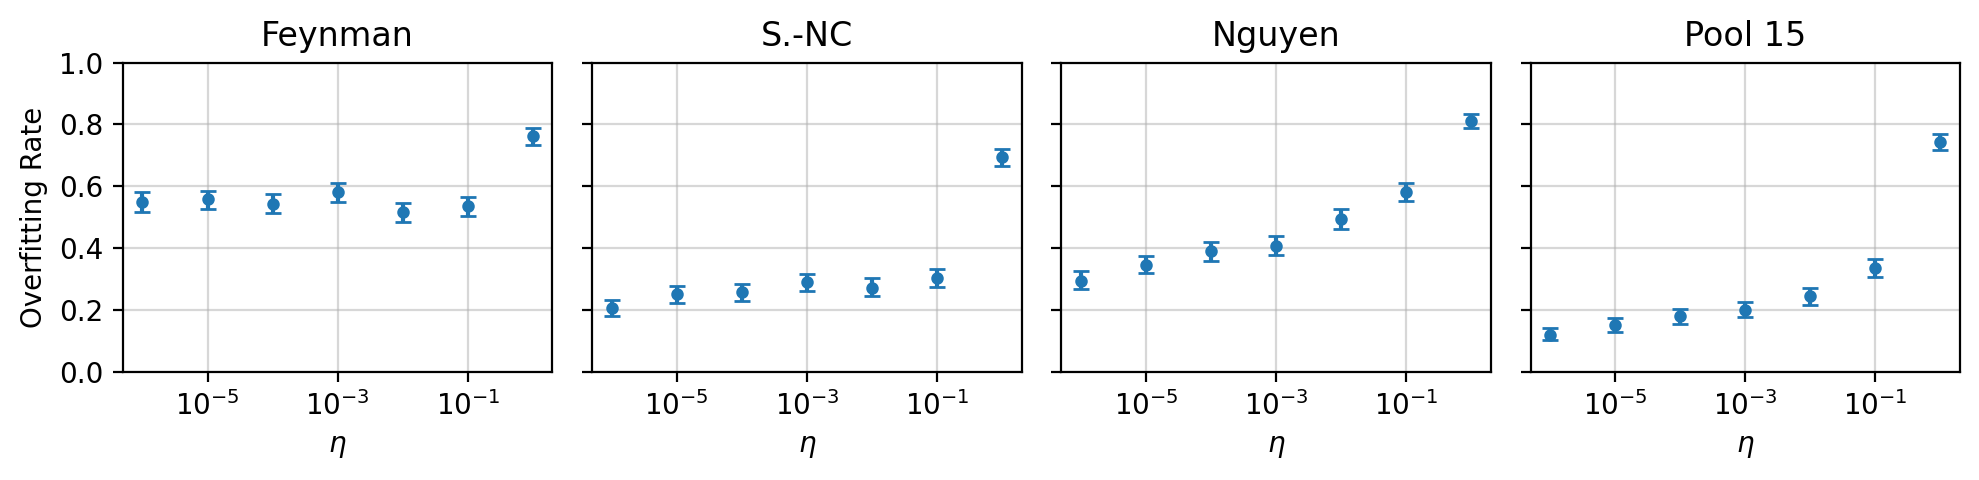

In [191]:
metric = "is_overfit"
noise_levels = [configs[model]['noise_level'] for model in array_dfs.keys()]

fig, axes = plt.subplots(1, 4, figsize=(10, 2.5), dpi=200, sharey=True)

for i, test_set in enumerate(summary_tables[metric]['mean']['median'].columns):
    ax = axes[i]
    data = summary_tables[metric]['mean']['median'][test_set]
    lower = summary_tables[metric]['mean']['lower'][test_set]
    upper = summary_tables[metric]['mean']['upper'][test_set]
    ax.errorbar(noise_levels, data, yerr=[data - lower, upper - data], fmt='.', markersize=7, capsize=3)
    ax.set_xscale('log')
    ax.set_xlabel('$\\eta$')
    ax.set_title(TEST_SET_TITLES[test_set])
    ax.grid(alpha=0.5)
    ax.set_ylim(0, 1)
    
axes[0].set_ylabel('Overfitting Rate')
fig.tight_layout()

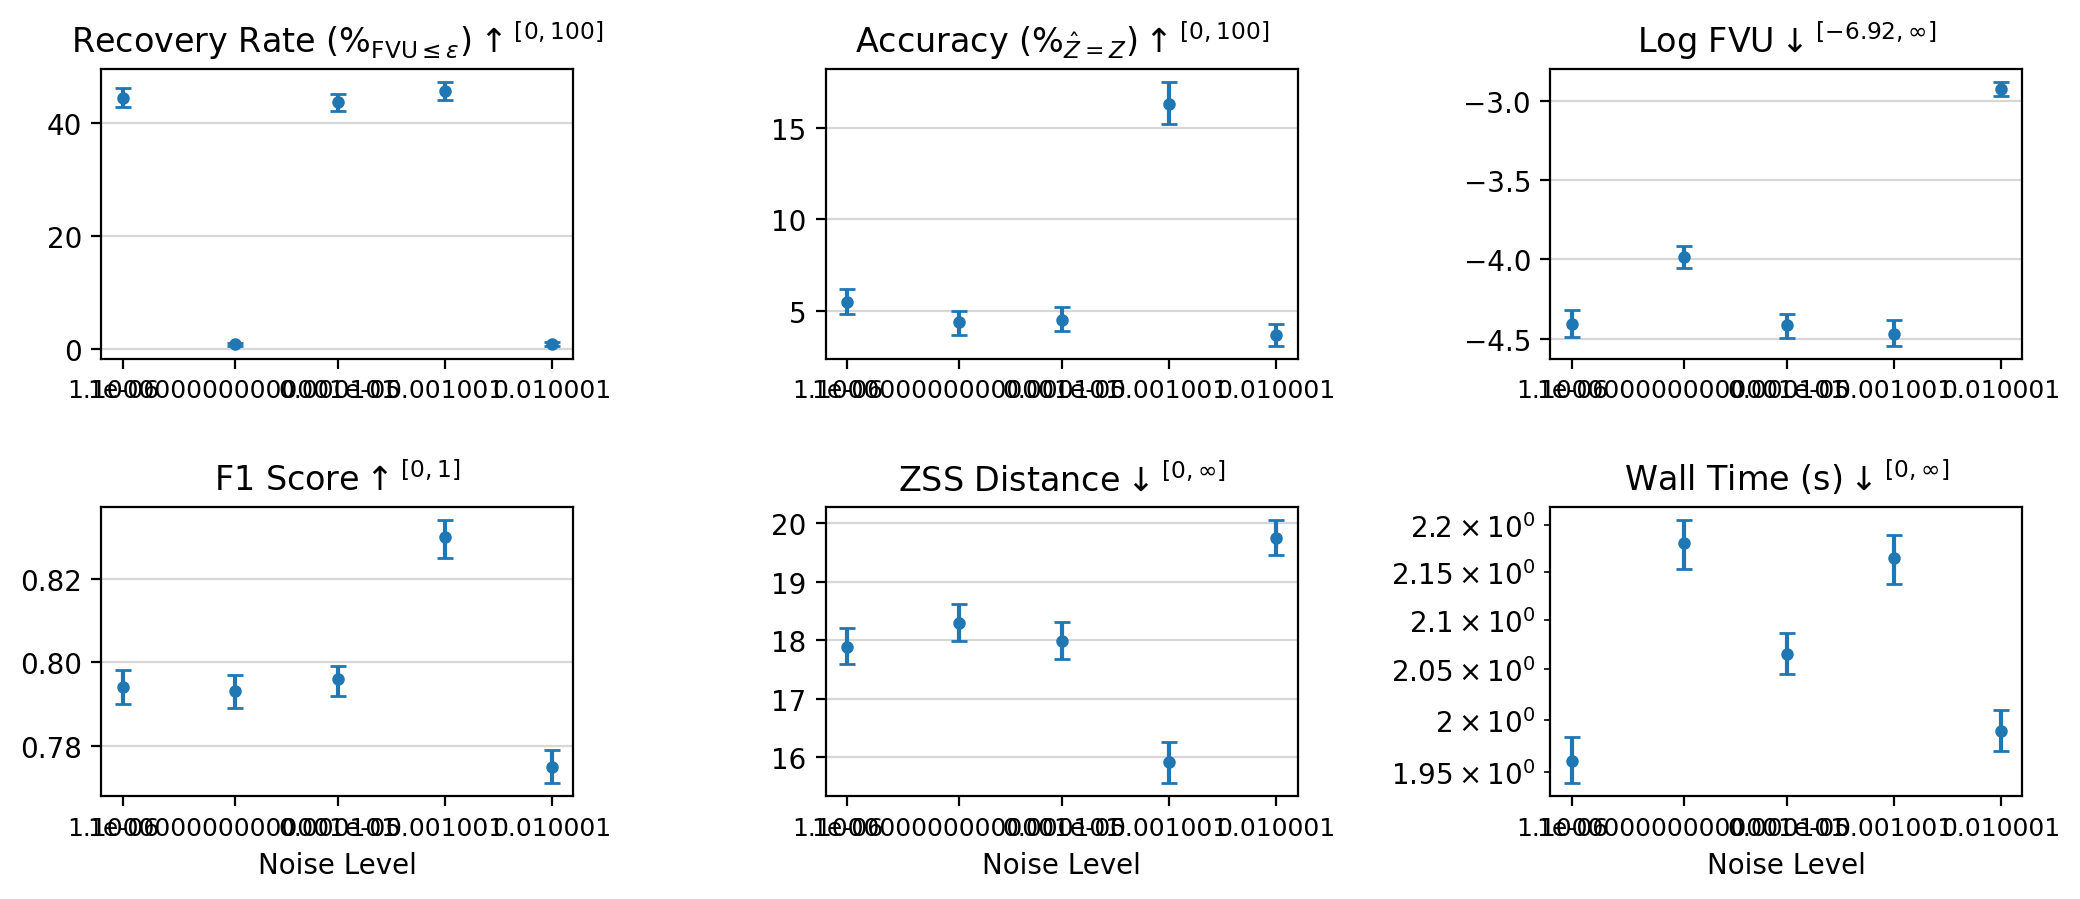

In [82]:
show_metric_list = ['FVU-eps_accuracy', 'accuracy_best_beam', 'log_fvu', 'f1_score_best_beam', 'tree_edit_distance_best_beam', 'wall_time']
objective_list = ['max', 'max', 'min', 'max', 'min', 'min']
y_label_list = ['Recovery Rate ($\%_{\\text{FVU} \leq \\epsilon}$)', 'Accuracy ($\%_{\hat{Z} = Z}$)', 'Log FVU', 'F1 Score', 'ZSS Distance', 'Wall Time (s)']
bounds_list = [(0, 100), (0, 100), (np.log10(np.finfo(np.float32).eps).round(2), None), (0, 1), (0, None), (0, None)]
sub_metric_list = ['mean', 'mean', 'mean', 'mean', 'mean', 'mean']
factor_list = [100, 100, 1, 1, 1, 1]
yscale_list = ['linear', 'linear', 'linear', 'linear', 'linear', 'log']
# ylim_list = [(0, 100), (np.log10(np.finfo(np.float32).eps), None), (0, None), (0, 1), (0, None)]
ylim_list = [None] * len(show_metric_list)

x = np.array([configs[model]['noise_level'] for model in MODELS])
x += 1e-6

COLS = min(3, len(show_metric_list))
ROWS = np.ceil(len(show_metric_list) / COLS).astype(int)

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 3.5, ROWS * 2.3), dpi=200)

for i, (show_metric, sub_metric, ax, y_label, factor, ylim, objective, bounds, yscale) in enumerate(
    zip(show_metric_list, sub_metric_list, axes.flatten(), y_label_list, factor_list, ylim_list, objective_list, bounds_list, yscale_list)):
    y = total_summary_tables[sub_metric]['median'].T.loc[show_metric] * factor
    y_lower = total_summary_tables[sub_metric]['lower'].T.loc[show_metric] * factor
    y_upper = total_summary_tables[sub_metric]['upper'].T.loc[show_metric] * factor

    ax.errorbar(x, y, yerr=[y - y_lower, y_upper - y], fmt='.', markersize=7, capsize=3)
    ax.set_xscale('log', base=2)
    arrow = ('$\\uparrow' if objective == 'max' else '$\\downarrow') + '^{[' + str(bounds[0]) + ', ' + (str(bounds[1]) if bounds[1] is not None else '\\infty') + ']}$'
    ax.set_title(y_label + f'{arrow}')
    ax.set_xticks(x)
    ax.set_xticklabels(x, fontsize=9)

    if i // COLS == ROWS - 1:
        ax.set_xlabel('Noise Level')
    # ax.set_xlabel('Beam Width')
    ax.grid(alpha=0.5, axis='y')

    ax.set_yscale(yscale)

    ax.set_ylim(ylim)

for ax in axes.flatten()[len(show_metric_list):]:
    ax.axis('off')

fig.tight_layout(w_pad=2, h_pad=2)

plt.savefig(get_path('results', 'analysis_beams', create=True, filename='analysis_beams_errorbars.svg'))

In [83]:
sub_metrics = ['mean', 'median', '2.5p', '97.5p']
sub_metrics_functions = [naninfmean, np.nanmedian, partial(np.nanpercentile, q=2.5), partial(np.nanpercentile, q=97.5)]

total_summary_lengths = {length: {model: {column: {k: (np.nan, ) * 3 for k in sub_metrics} for column in compare_columns} for model in array_dfs.keys()} for length in range(32)}
aggregate_sets = ['feynman', 'soose_nc', 'nguyen', 'pool_15']
metrics = None

N_BOOTSTRAPS = 100

for model, model_dfs in array_dfs.items():
    if len(model_dfs) == 0:
        continue
    aggregated_data_lengths = {length: pd.concat([df[df['length_target'] == length] for test_set, df in model_dfs.items() if test_set in aggregate_sets]) for length in range(32)}

    for length in tqdm(range(32)):
        for column in compare_columns:
            if column in aggregated_data_lengths[length].columns:
                data = aggregated_data_lengths[length][column].replace({np.nan: compare_columns_defaults.get(column, np.nan)}).values
                total_summary_lengths[length][model][column] = {m: bootstrapped_metric_ci(data, f, n=N_BOOTSTRAPS) for m, f in zip(sub_metrics, sub_metrics_functions)}

    if metrics is None:
        metrics = total_summary_lengths[length][model][column].keys()

  0%|          | 0/32 [00:00<?, ?it/s]/tmp/ipykernel_29678/3880369273.py:2: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.array(x)[np.isfinite(x)])
/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1649: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
  9%|▉         | 3/32 [00:00<00:04,  6.50it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
 12%|█▎        | 4/32 [00:00<00:05,  4.96it/s]/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4622: RuntimeWarning: invalid value encountered

In [84]:
total_summary_tables_length = {
    length: {
        metric: {
            percentile:
                pd.DataFrame({
                model: {
                    column: total_summary_lengths[length][model][column][metric][k]
                    for column in compare_columns}
                    for model in total_summary.keys()}).T.round(3)
                    for k, percentile in enumerate(['median', 'lower', 'upper'])}
                    for metric in metrics}
                    for length in range(32)}

In [85]:
from matplotlib.colors import LogNorm

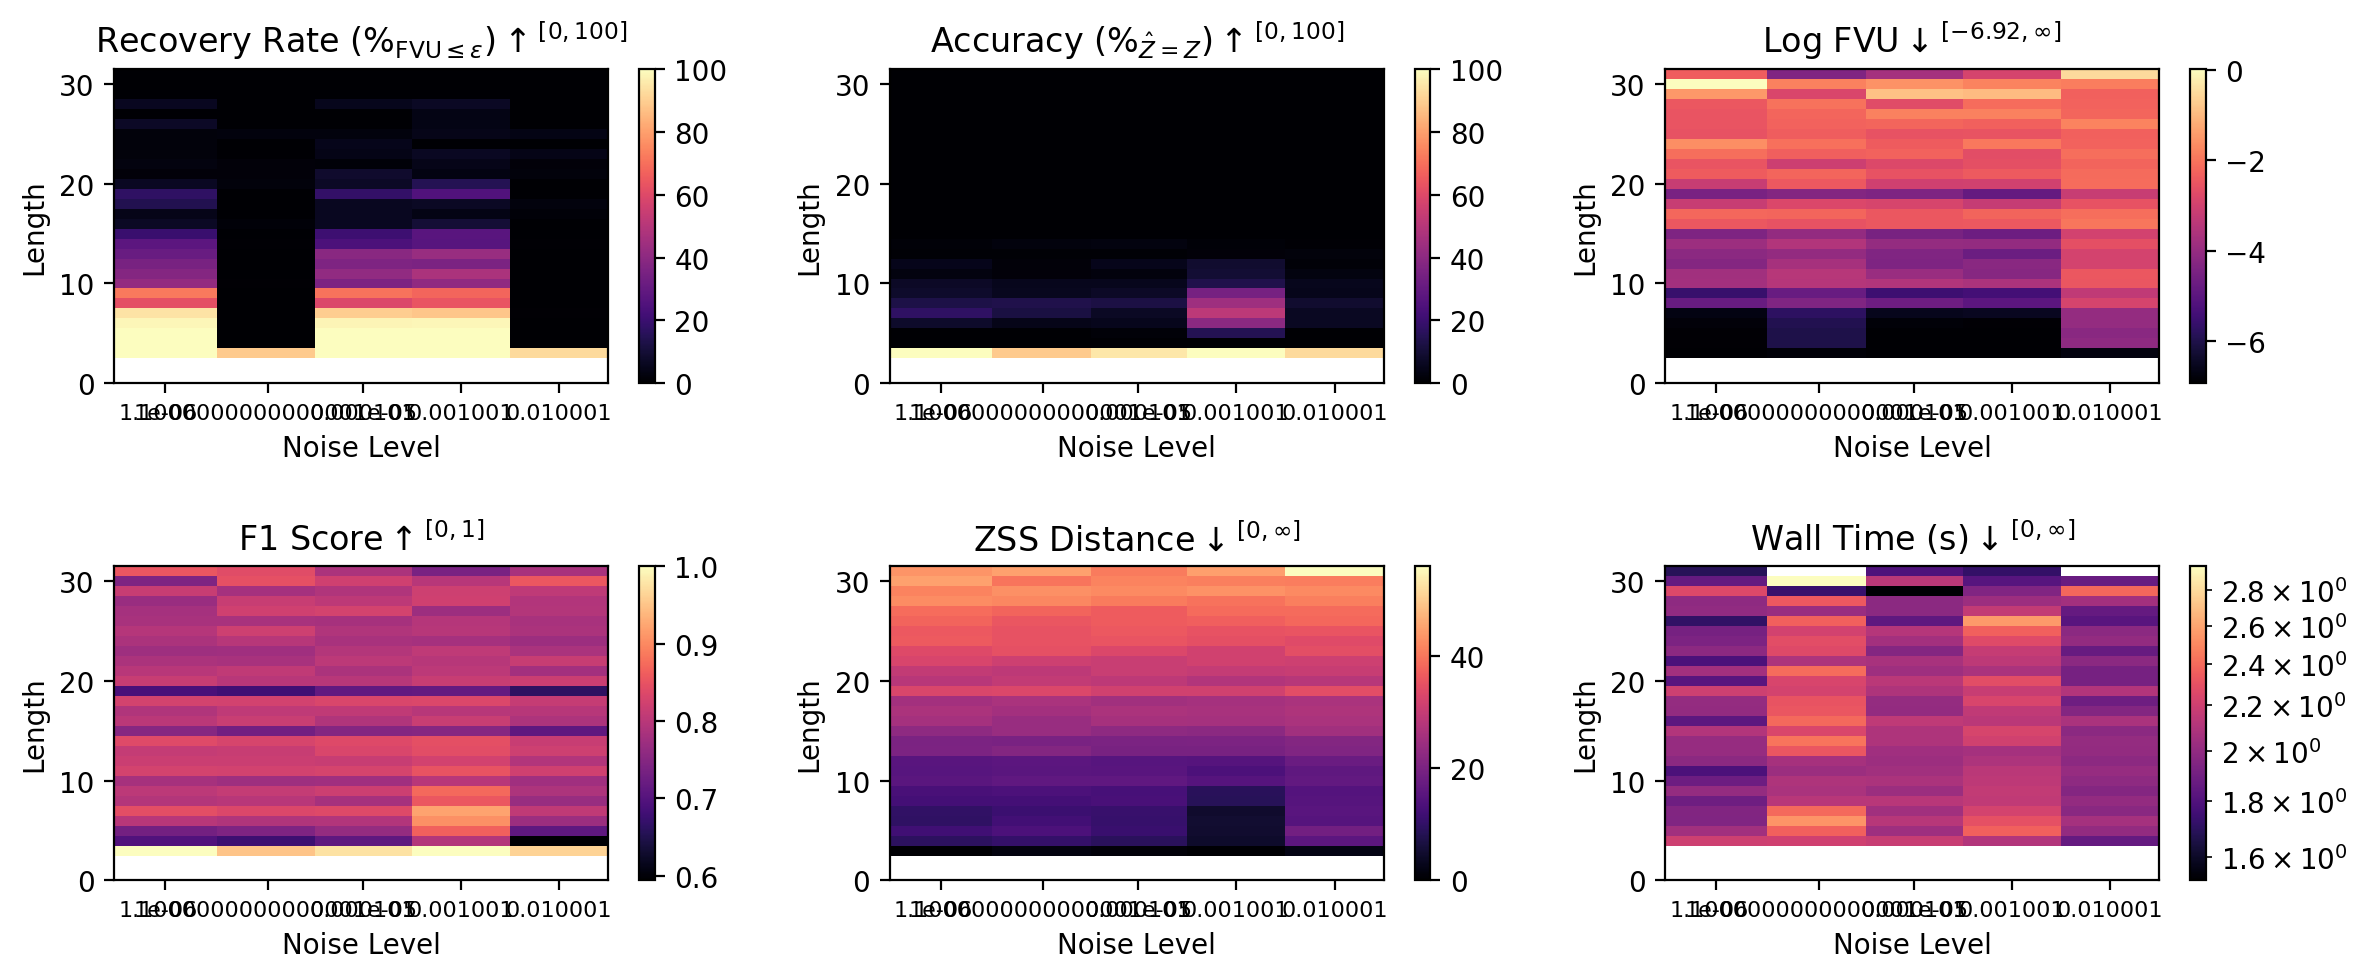

In [86]:
show_metric_list = ['FVU-eps_accuracy', 'accuracy_best_beam', 'log_fvu', 'f1_score_best_beam', 'tree_edit_distance_best_beam', 'wall_time']
objective_list = ['max', 'max', 'min', 'max', 'min', 'min']
y_label_list = ['Recovery Rate ($\%_{\\text{FVU} \leq \\epsilon}$)', 'Accuracy ($\%_{\hat{Z} = Z}$)', 'Log FVU', 'F1 Score', 'ZSS Distance', 'Wall Time (s)']
bounds_list = [(0, 100), (0, 100), (np.log10(np.finfo(np.float32).eps).round(2), None), (0, 1), (0, None), (0, None)]
sub_metric_list = ['mean', 'mean', 'mean', 'mean', 'mean', 'mean']
factor_list = [100, 100, 1, 1, 1, 1]
log_norm_list = [False, False, False, False, False, True]
# ylim_list = [(0, 100), (np.log10(np.finfo(np.float32).eps), None), (0, None), (0, 1), (0, None)]
ylim_list = [(0, 31.5)] * len(show_metric_list)

x = np.array([configs[model]['noise_level'] for model in MODELS]) + 1e-6
sorted_indices = np.argsort(x)

COLS = min(3, len(show_metric_list))
ROWS = np.ceil(len(show_metric_list) / COLS).astype(int)

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 4, ROWS * 2.5), dpi=200)

for i, (show_metric, sub_metric, ax, y_label, factor, ylim, log_norm, bounds, objective) in enumerate(
    zip(show_metric_list, sub_metric_list, axes.flatten(), y_label_list, factor_list, ylim_list, log_norm_list, bounds_list, objective_list)):
    y = np.array([s[sub_metric]['median'].T.loc[show_metric] for s in total_summary_tables_length.values()]) * factor

    mesh = np.meshgrid(np.log2(x[sorted_indices]), np.arange(32))
    colormesh = ax.pcolormesh(mesh[0], mesh[1], y[:, sorted_indices], shading='auto', cmap='magma', norm=LogNorm() if log_norm else None, linewidth=0, rasterized=True)
    # colormesh.set_edgecolor('face')


    ax.set_xticks(np.log2(x))
    ax.set_xticklabels(x, fontsize=8)

    ax.set_ylabel('Length')
    ax.set_xlabel('Noise Level')
    arrow = ('$\\uparrow' if objective == 'max' else '$\\downarrow') + '^{[' + str(bounds[0]) + ', ' + (str(bounds[1]) if bounds[1] is not None else '\\infty') + ']}$'
    ax.set_title(y_label + f'{arrow}')
    
    # Add a little colorbar to each plot
    cb = plt.colorbar(colormesh, ax=ax)

    ax.set_ylim(ylim)

# hist_x = np.arange(32)
# hist_y = [len(aggregated_data_lengths[length]) for length in range(32)]

# hist_plot_x = np.empty(2 * len(hist_x))
# hist_plot_x[0::2] = hist_x - 0.5
# hist_plot_x[1::2] = hist_x + 0.5
# hist_plot_y = np.empty(2 * len(hist_y))
# hist_plot_y[0::2] = hist_y
# hist_plot_y[1::2] = hist_y

# axes.flatten()[-1].fill_betweenx(hist_plot_x, hist_plot_y, color='k', alpha=0.2)
# axes.flatten()[-1].set_xlim(0, None)
# axes.flatten()[-1].set_xlabel('Number of Test Equations')
# axes.flatten()[-1].set_ylabel('Length')
# axes.flatten()[-1].grid(alpha=0.5)
# axes.flatten()[-1].set_ylim(0, 32)
# axes.flatten()[-1].set_title('Aggregated Test Set Distribution')

# Add a phantom colorbar
# cb = plt.colorbar(colormesh, ax=axes.flatten()[-1])
# Hide the colorbar
# cb.ax.set_visible(False)

fig.tight_layout(w_pad=2, h_pad=2)

plt.savefig(get_path('results', 'analysis_beams', create=True, filename='analysis_beams_length_heatmap.svg'))

In [49]:
def int_to_10(i, theshold=100):
    if i > theshold:
        return '$10^{' + f'{np.log10(i):.0f}' + '}$'
    elif i < 1 / theshold:
        return '$10^{-' + f'{np.log10(1/i):.0f}' + '}$'
    return str(i)

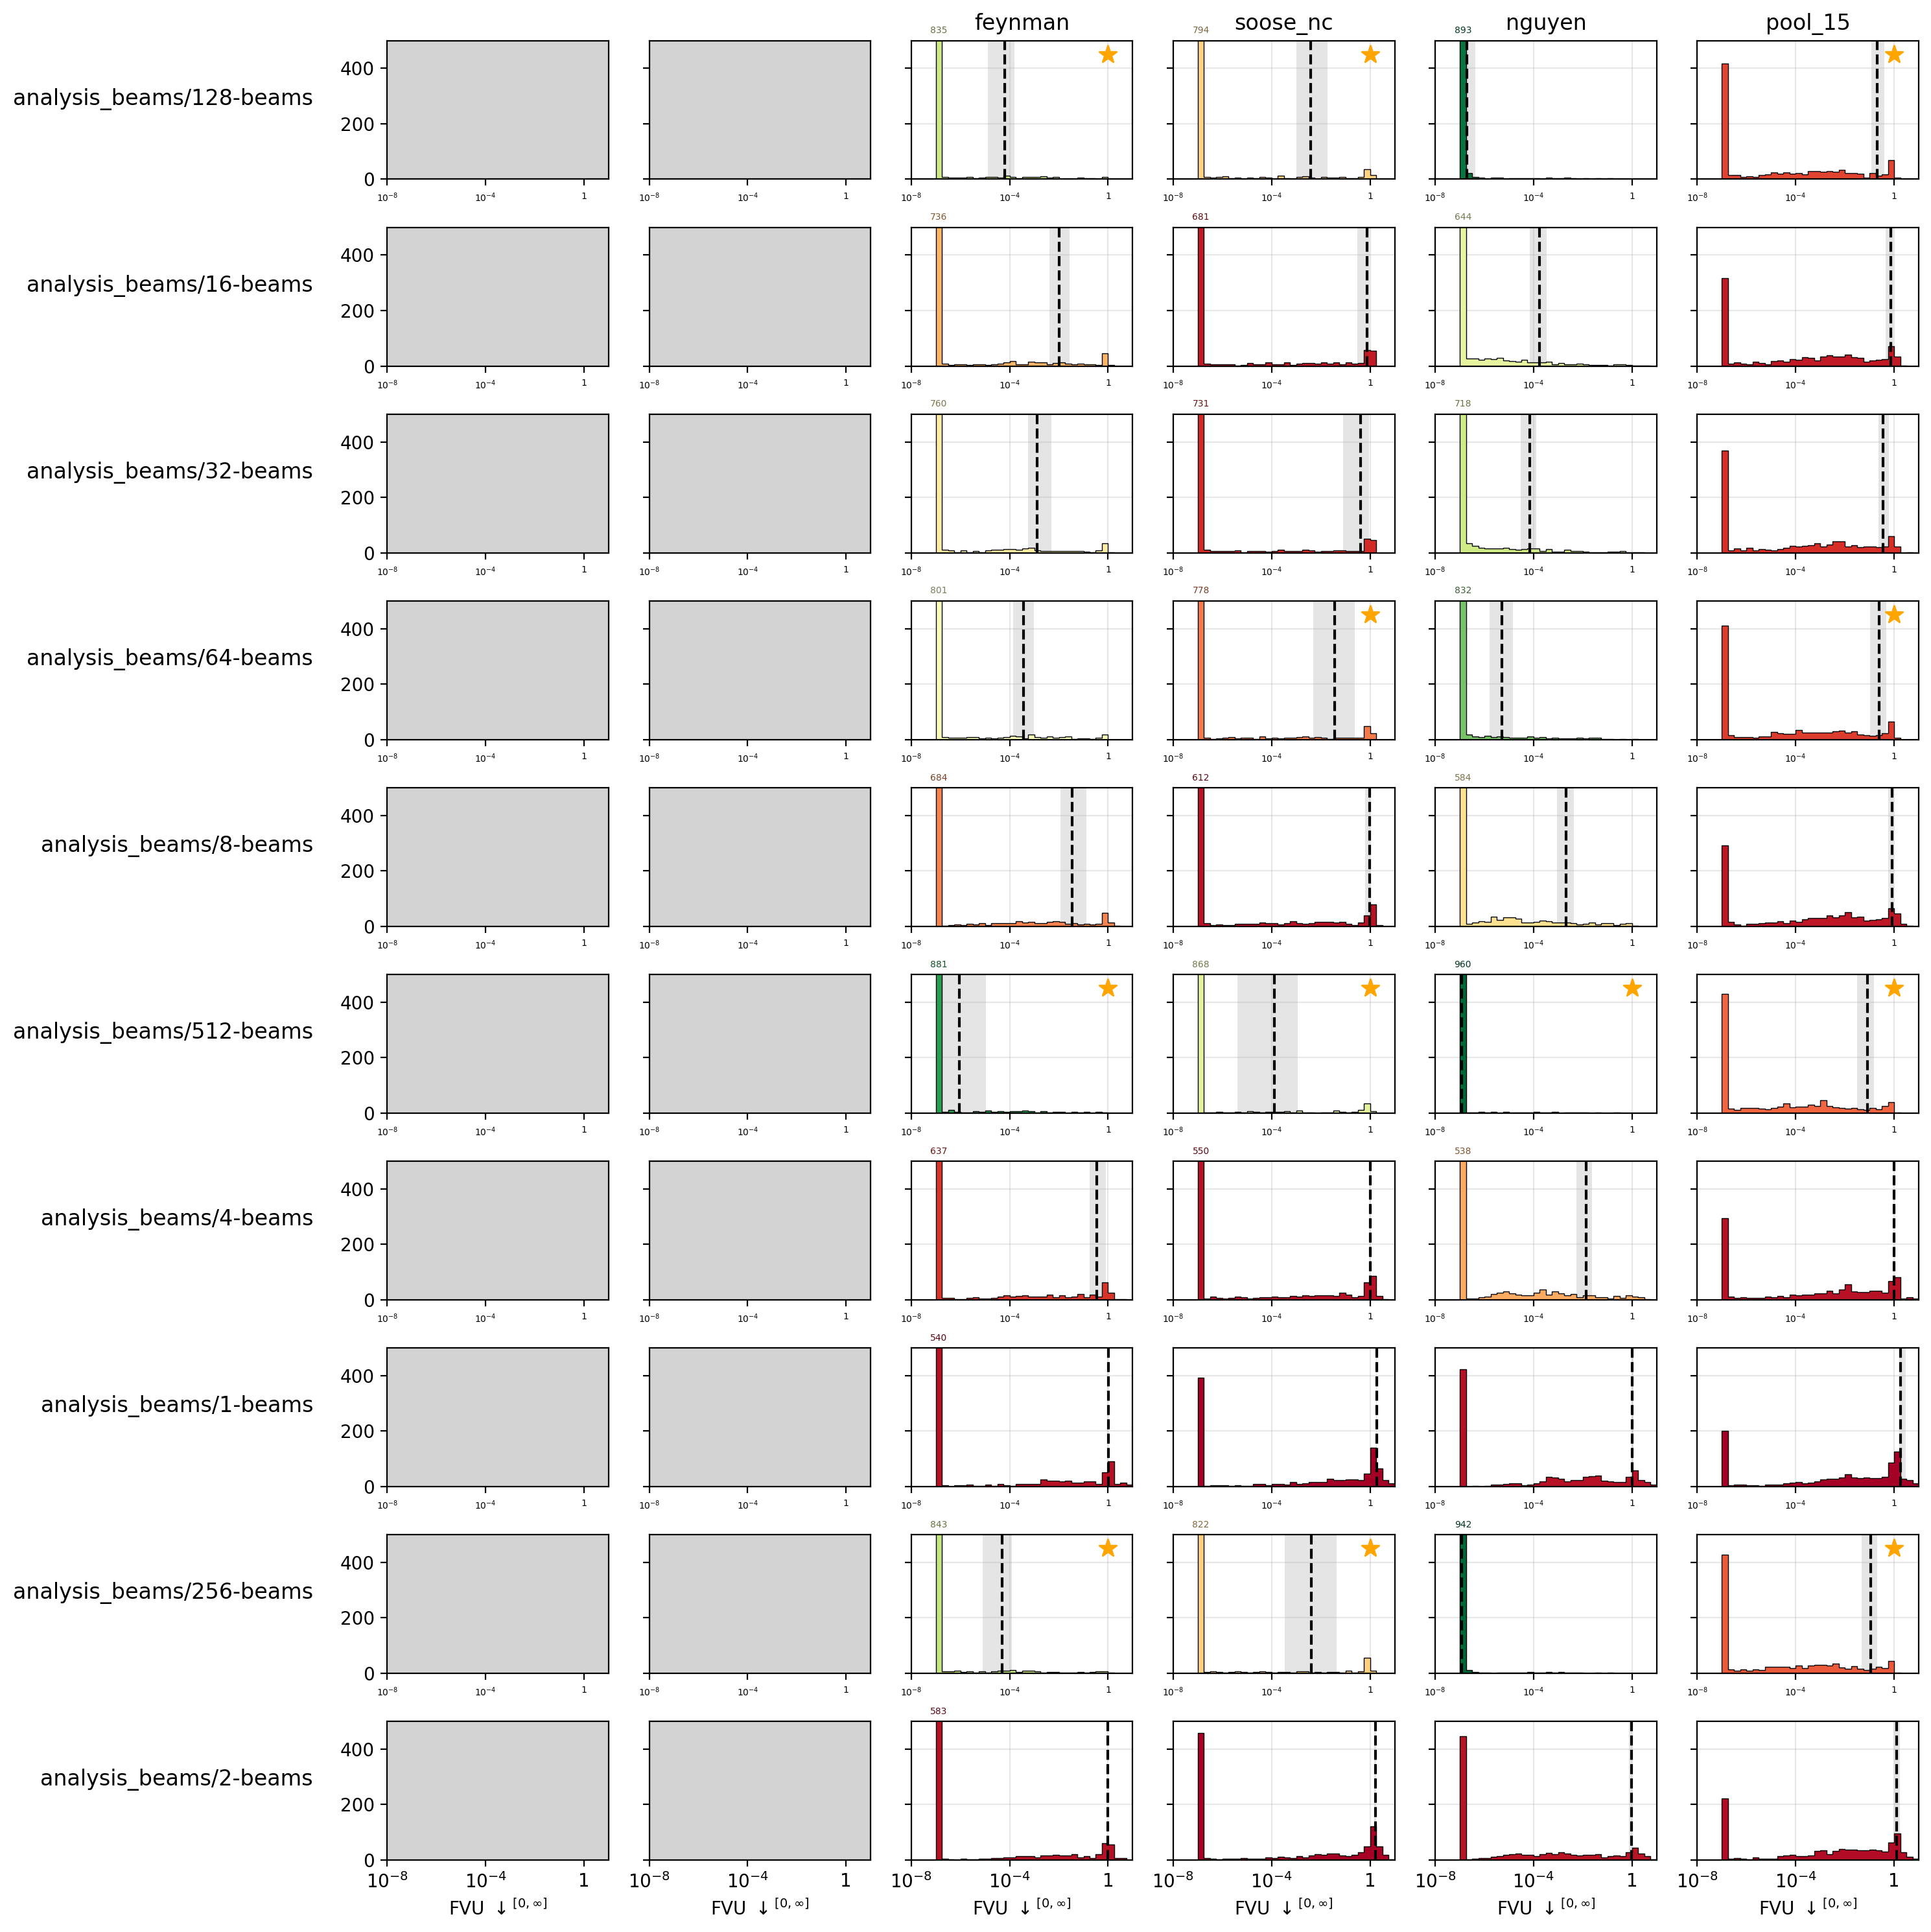

In [50]:
ROWS = len(MODELS)
# COLS = max(len(model_test_sets) for model_test_sets in test_sets.values())
COLS = len(TEST_SETS)
N_BOOTSTRAPS = 1_000

fig, axes = plt.subplots(ROWS, COLS, figsize=(2.5 * COLS, 1.5 * ROWS), sharey=True, dpi=200)

axes = np.atleast_2d(axes)

xlim = (-8, 1)
bins = np.linspace(*xlim, (xlim[1] - xlim[0]) * 4 + 1)
# ylim = (0, 1.05 * max([max(np.histogram(array_dfs[model][test_set]['log_fvu'], bins=bins)[0]) for model in MODELS for test_set in test_sets[model]]))
ylim = (0, 500)

# Plot the distributions of a given metric for each model and test set
metric_name = 'log_fvu'

def stats_from_log_values(statistic):
    return lambda x: np.log(statistic(np.power(10, x)) + np.finfo(float).eps)

color_metric = lambda x: np.percentile(x[~np.isnan(x)], 90)

min_color_metric = np.min([np.min([color_metric(array_dfs[model][test_set][metric_name].replace(np.nan, 0).replace(np.inf, np.nan)) for test_set in test_sets[model] if test_set in array_dfs[model].keys()]) for model in MODELS])
max_color_metric = np.max([np.max([color_metric(array_dfs[model][test_set][metric_name].replace(np.nan, 0).replace(np.inf, np.nan)) for test_set in test_sets[model] if test_set in array_dfs[model].keys()]) for model in MODELS])

highest_lower_confidence_bound = {test_set: (None, np.inf) for test_set in TEST_SETS}

for i, model in enumerate(MODELS):
    for j, test_set in enumerate(TEST_SETS):
        ax = axes[i, j]
        ax.set_xticks([-8, -4, 0])
        ax.set_xticklabels([int_to_10(10**i) for i in [ -8, -4, 0]], fontdict={'fontsize': 5 if i != len(MODELS) - 1 else 10})
        if j == 0: ax.set_ylabel(MODELS_DESCRIPTION[model], rotation=0, labelpad=15, ha='right', fontsize=12)
        if i == len(MODELS) - 1: ax.set_xlabel(r'$\text{FVU}\,\,\downarrow^{[0, \infty]}$')
        if test_set not in array_dfs[model]:
            ax.set_xlim(xlim)
            ax.set_facecolor('lightgrey')
            continue
        data = array_dfs[model][test_set][metric_name].replace(np.nan, 0).replace(np.inf, np.nan).values

        color = plt.get_cmap('RdYlGn').reversed()((color_metric(data) - min_color_metric) / (max_color_metric - min_color_metric))

        ax.hist(data, bins=bins, color=color, zorder=2)
        ax.hist(data, bins=bins, zorder=2, histtype='step', edgecolor='k', linewidth=0.5)

        hist, bin_edges = np.histogram(data, bins=bins)
        for h, mid in zip(hist, (bin_edges[1:] + bin_edges[:-1]) / 2):
            if h > ylim[1]:
                ax.annotate(f'{h}', xy=(mid, ylim[1]), xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', fontsize=5, color=tuple(np.array(color)[:3] * 0.5) + (1,))

        median_median, median_5, median_95 = bootstrapped_metric_ci(data, color_metric, n=N_BOOTSTRAPS)

        if median_5 < highest_lower_confidence_bound[test_set][1]:
            highest_lower_confidence_bound[test_set] = (model, median_95)

        ax.axvline(median_median, color='black', linestyle='--', zorder=3)
        # ax.errorbar(median_median, ylim[1], xerr=[[median_median - median_5], [median_95 - median_median]], fmt='.', color='black', zorder=4, capsize=3, markersize=0, clip_on=True)
        ax.axvspan(median_5, median_95, color='black', alpha=0.1, zorder=1, linewidth=0)
        ax.set_ylim(ylim)
        ax.grid(alpha=0.3, zorder=0)
        if i == 0: ax.set_title(test_set)
        ax.set_xlim(xlim)

within_lowest_upper_confidence_bound = {test_set: [] for test_set in TEST_SETS}
for i, model in enumerate(MODELS):
    for j, test_set in enumerate(TEST_SETS):
        if test_set not in array_dfs[model]:
            continue
        data = array_dfs[model][test_set][metric_name].replace(np.nan, 0).replace(np.inf, np.nan).values
        median_median, median_5, median_95 = bootstrapped_metric_ci(data, color_metric, n=N_BOOTSTRAPS)

        if median_5 < highest_lower_confidence_bound[test_set][1]:
            within_lowest_upper_confidence_bound[test_set].append(model)

# For each test set, mark the model (row) with the lowest median log_fvu
for j, test_set in enumerate(TEST_SETS):
    if test_set in ['train', 'val']:
        continue
    models = within_lowest_upper_confidence_bound[test_set]
    for i, model in enumerate(MODELS):
        if model in models:
            axes[MODELS.index(model), j].scatter([0], [ylim[1] * 0.9], color='orange', marker='*', s=100, zorder=5)

fig.tight_layout(h_pad=0.5)

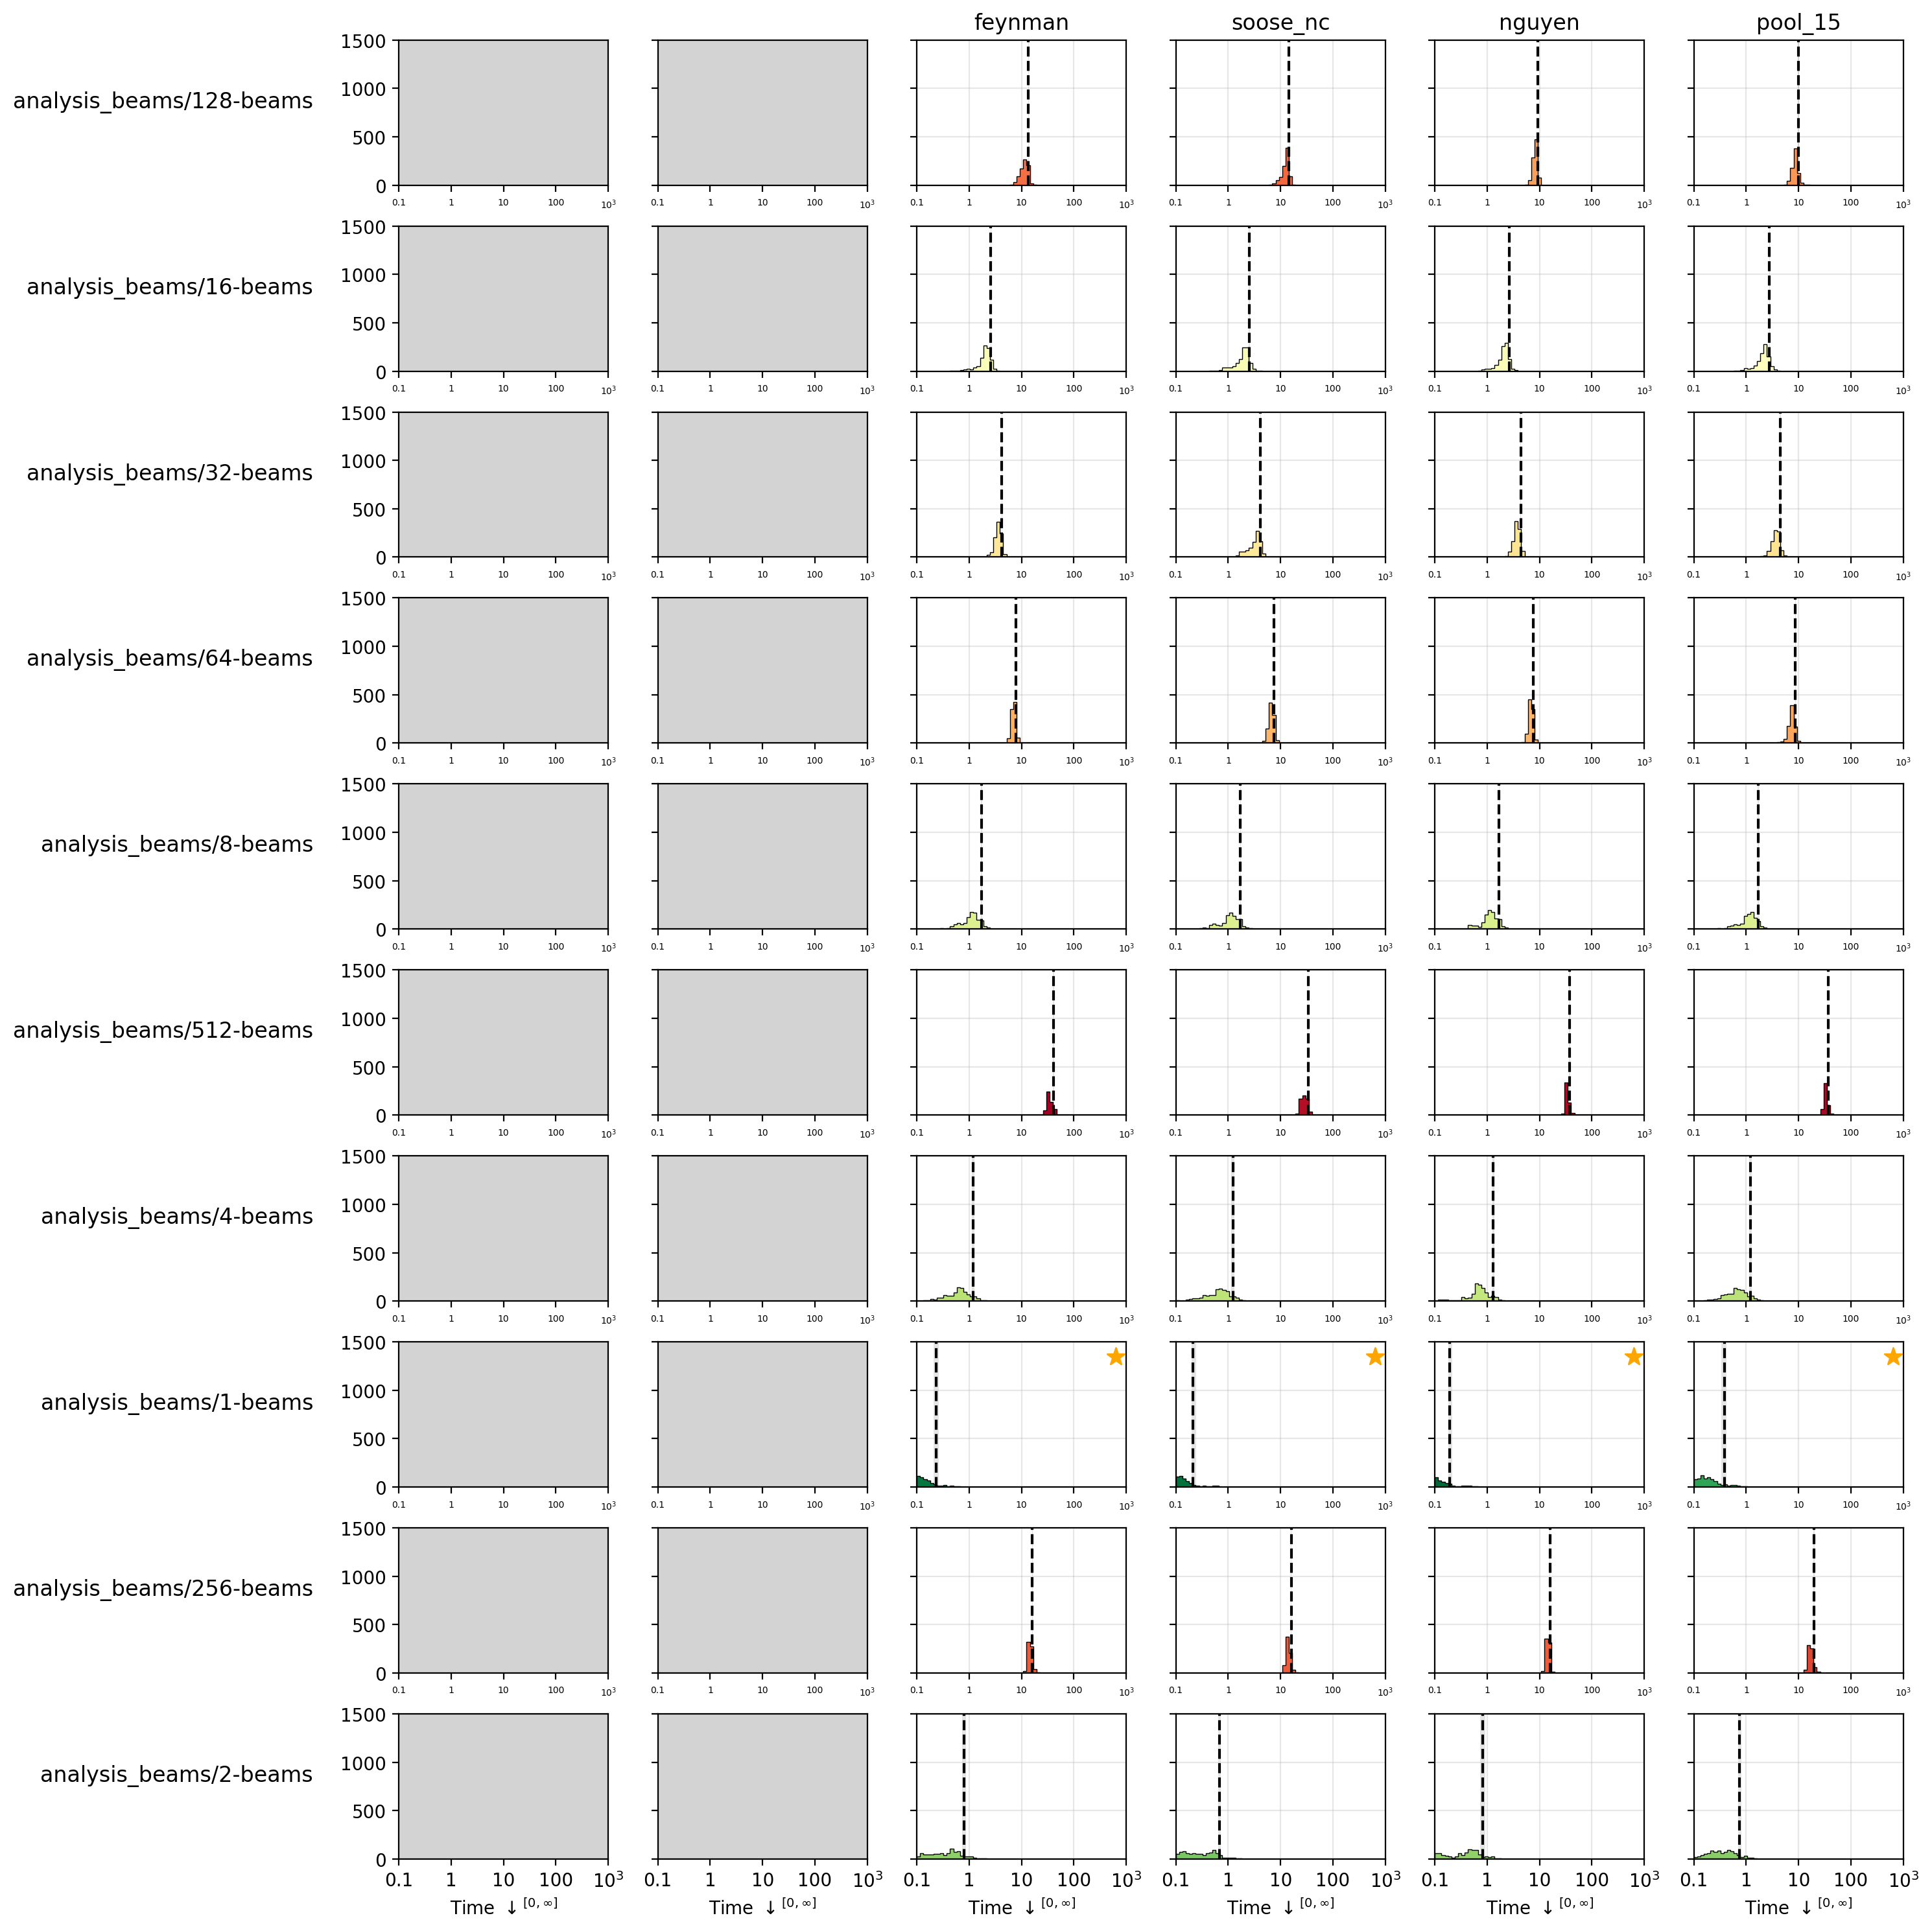

In [51]:
ROWS = len(MODELS)
# COLS = max(len(model_test_sets) for model_test_sets in test_sets.values())
COLS = len(TEST_SETS)
N_BOOTSTRAPS = 1_000

fig, axes = plt.subplots(ROWS, COLS, figsize=(2.5 * COLS, 1.5 * ROWS), sharey=True, dpi=200)

axes = np.atleast_2d(axes)

xlim = (-1, 3)
bins = np.linspace(*xlim, 64)
# ylim = (0, 1.05 * max([max(np.histogram(array_dfs[model][test_set]['log_fvu'], bins=bins)[0]) for model in MODELS for test_set in test_sets[model]]))
ylim = (0, 1500)

# Plot the distributions of a given metric for each model and test set
metric_name = 'sys_time'

color_metric = lambda x: np.percentile(x[~np.isnan(x) & ~np.isinf(x)], 90)

min_color_metric = np.min([np.min([color_metric(np.log10(array_dfs[model][test_set][metric_name].replace(np.inf, np.nan))) for test_set in test_sets[model] if test_set in array_dfs[model].keys()]) for model in MODELS])
max_color_metric = np.max([np.max([color_metric(np.log10(array_dfs[model][test_set][metric_name].replace(np.inf, np.nan))) for test_set in test_sets[model] if test_set in array_dfs[model].keys()]) for model in MODELS])

highest_lower_confidence_bound = {test_set: (None, np.inf) for test_set in TEST_SETS}

for i, model in enumerate(MODELS):
    for j, test_set in enumerate(TEST_SETS):
        ax = axes[i, j]
        ax.set_xticks([-1, 0, 1, 2, 3])
        ax.set_xticklabels([int_to_10(10**i) for i in [-1, 0, 1, 2, 3]], fontdict={'fontsize': 5 if i != len(MODELS) - 1 else 10})
        if j == 0: ax.set_ylabel(MODELS_DESCRIPTION[model], rotation=0, labelpad=15, ha='right', fontsize=12)
        if i == len(MODELS) - 1: ax.set_xlabel(r'$\text{Time}\,\,\downarrow^{[0, \infty]}$')
        if test_set not in array_dfs[model]:
            ax.set_xlim(xlim)
            ax.set_facecolor('lightgrey')
            continue
        data = np.log10(array_dfs[model][test_set][metric_name].replace(np.inf, np.nan).values)

        color = plt.get_cmap('RdYlGn').reversed()((color_metric(data) - min_color_metric) / (max_color_metric - min_color_metric))

        ax.hist(data, bins=bins, color=color, zorder=2)
        ax.hist(data, bins=bins, zorder=2, histtype='step', edgecolor='k', linewidth=0.5)

        hist, bin_edges = np.histogram(data, bins=bins)
        for h, mid in zip(hist, (bin_edges[1:] + bin_edges[:-1]) / 2):
            if h > ylim[1]:
                ax.annotate(f'{h}', xy=(mid, ylim[1]), xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', fontsize=5, color=tuple(np.array(color)[:3] * 0.5) + (1,))

        median_median, median_5, median_95 = bootstrapped_metric_ci(data, color_metric, n=N_BOOTSTRAPS)

        if median_5 < highest_lower_confidence_bound[test_set][1]:
            highest_lower_confidence_bound[test_set] = (model, median_95)

        ax.axvline(median_median, color='black', linestyle='--', zorder=3)
        # ax.errorbar(median_median, ylim[1], xerr=[[median_median - median_5], [median_95 - median_median]], fmt='.', color='black', zorder=4, capsize=3, markersize=0, clip_on=True)
        ax.axvspan(median_5, median_95, color='black', alpha=0.1, zorder=1, linewidth=0)
        ax.set_ylim(ylim)
        ax.grid(alpha=0.3, zorder=0)
        if i == 0: ax.set_title(test_set)
        ax.set_xlim(xlim)

within_lowest_upper_confidence_bound = {test_set: [] for test_set in TEST_SETS}
for i, model in enumerate(MODELS):
    for j, test_set in enumerate(TEST_SETS):
        if test_set not in array_dfs[model]:
            continue
        data = np.log10(array_dfs[model][test_set][metric_name].replace(np.inf, np.nan).values)
        median_median, median_5, median_95 = bootstrapped_metric_ci(data, color_metric, n=N_BOOTSTRAPS)

        if median_5 < highest_lower_confidence_bound[test_set][1]:
            within_lowest_upper_confidence_bound[test_set].append(model)

# For each test set, mark the model (row) with the lowest median log_fvu
for j, test_set in enumerate(TEST_SETS):
    if test_set in ['train', 'val']:
        continue
    models = within_lowest_upper_confidence_bound[test_set]
    for i, model in enumerate(MODELS):
        if model in models:
            axes[MODELS.index(model), j].scatter([2.8], [ylim[1] * 0.9], color='orange', marker='*', s=100, zorder=5)

fig.tight_layout(h_pad=0.5)

In [52]:
# from nsr import ExpressionSpace, get_path
# space = ExpressionSpace.from_config(get_path('configs/v4.2/expression_space.yaml'))
# from itertools import groupby
# from collections import Counter

In [53]:
# lists = {model: {model_test_set: space.tokenizer.decode(results[model][model_test_set]['data']['labels']) for model_test_set in results[model].keys()} for model in MODELS for test_set in TEST_SETS}
# splits = {model: {model_test_set: [tuple(y) for x, y in groupby(lst, lambda z: z == '<eos>') if not x] for model_test_set, lst in v.items()} for model, v in lists.items()}

In [54]:
# test_set_labels_union = {test_set: set.union(*[set([tuple(x) for x in splits[model].get(test_set, [])]) for model in MODELS]) for test_set in TEST_SETS}

# for k, v in test_set_labels_union.items():
#     print(k, len(v))

In [55]:
# eq_data = {model: {test_set: {k: [array_dfs[model][test_set]['log_fvu'][i] for i in range(len(array_dfs[model][test_set]['log_fvu'])) if splits[model][test_set][i] == k] for k in test_set_labels_union[test_set]} for test_set in TEST_SETS if test_set in array_dfs[model].keys()} for model in MODELS}

In [56]:
# # For each unique sequence, plot how often it appears in the test set
# fig, axes = plt.subplots(1, 2, figsize=(7, 3.2), dpi=200)

# compare_models = ['v4.2', 'v4.10']
# compare_test_set = 'soose_nc'

# max_count = max([max(Counter(splits[model][compare_test_set]).values()) for model in compare_models])

# counter_1 = Counter(splits[compare_models[0]][compare_test_set])
# counter_2 = Counter(splits[compare_models[1]][compare_test_set])

# axes[0].hist2d([counter_1.get(k, 0) for k in test_set_labels_union[compare_test_set]], [counter_2.get(k, 0) for k in test_set_labels_union[compare_test_set]], bins=range(0, max_count + 1), cmap='viridis')
# axes[0].set_xticks(0.5 + np.linspace(0, max_count + 1, 5)[:-1])
# axes[0].set_yticks(0.5 + np.linspace(0, max_count + 1, 5)[:-1])
# axes[0].set_xticklabels(np.linspace(0, max_count, 5, dtype=int)[:-1])
# axes[0].set_yticklabels(np.linspace(0, max_count, 5, dtype=int)[:-1])
# axes[0].set_xlabel(f'{compare_models[0]} count')
# axes[0].set_ylabel(f'{compare_models[1]} count')

# data = pd.DataFrame({
#     compare_models[0]: [np.nanmedian(eq_data[compare_models[0]][compare_test_set][k]) for k in test_set_labels_union[compare_test_set]],
#     compare_models[1]: [np.nanmedian(eq_data[compare_models[1]][compare_test_set][k]) for k in test_set_labels_union[compare_test_set]],
#     'count': [len(eq_data[compare_models[0]][compare_test_set][k]) for k in test_set_labels_union[compare_test_set]],
# })

# axes[1].scatter(data[compare_models[0]], data[compare_models[1]], alpha=0.5, s=data['count'] * 2)
# axes[1].set_xlim(-17, 1)
# axes[1].set_ylim(-17, 1)
# axes[1].set_xticks([-16, -12, -8, -4, 0])
# axes[1].set_yticks([-16, -12, -8, -4, 0])
# axes[1].set_xlabel(f'{compare_models[0]} log FVU')
# axes[1].set_ylabel(f'{compare_models[1]} log FVU')

# fig.tight_layout(w_pad=3)

In [57]:
# sorted(results['v4.2']['soose_nc']['data']['log_fvu'])[:10]

In [58]:
# sorted(results['v4.10']['soose_nc']['data']['log_fvu'])[:10]

In [59]:
# # Show the 10 easiest equations of 'v4.2' measured by log FVU
# easy2 = sorted([(k, np.nanmean(v), len(v)) for k, v in eq_data['v4.2']['soose_nc'].items()], key=lambda x: x[1] if not np.isnan(x[1]) else np.inf)[:20]

# for k, v, l in easy2:
#     print(f'{space.prefix_to_infix(k):<50} {v:>6.2f} ({l}) {np.nanmean(eq_data["v4.10"]["soose_nc"].get(k, [])):>6.2f} ({len(eq_data["v4.10"]["soose_nc"].get(k, []))})')

In [60]:
UNIQUE_MODELS_NO_NESYMRES = [m for m in UNIQUE_MODELS if m != 'nesymres-100M']

NameError: name 'UNIQUE_MODELS' is not defined

/tmp/ipykernel_27333/3817520256.py:15: RuntimeWarning: Mean of empty slice
  min_color_metric = np.nanmin([np.nanmin([color_metric(array_dfs[model][test_set].get(metric_name, pd.Series([np.nan]))) for test_set in test_sets[model]]) for model in UNIQUE_MODELS_NO_NESYMRES])
/tmp/ipykernel_27333/3817520256.py:15: RuntimeWarning: All-NaN axis encountered
  min_color_metric = np.nanmin([np.nanmin([color_metric(array_dfs[model][test_set].get(metric_name, pd.Series([np.nan]))) for test_set in test_sets[model]]) for model in UNIQUE_MODELS_NO_NESYMRES])
/tmp/ipykernel_27333/3817520256.py:16: RuntimeWarning: Mean of empty slice
  max_color_metric = np.nanmax([np.nanmax([color_metric(array_dfs[model][test_set].get(metric_name, pd.Series([np.nan]))) for test_set in test_sets[model]]) for model in UNIQUE_MODELS_NO_NESYMRES])
/tmp/ipykernel_27333/3817520256.py:16: RuntimeWarning: All-NaN axis encountered
  max_color_metric = np.nanmax([np.nanmax([color_metric(array_dfs[model][test_set].get(metric_na

ValueError: Cannot index with multidimensional key

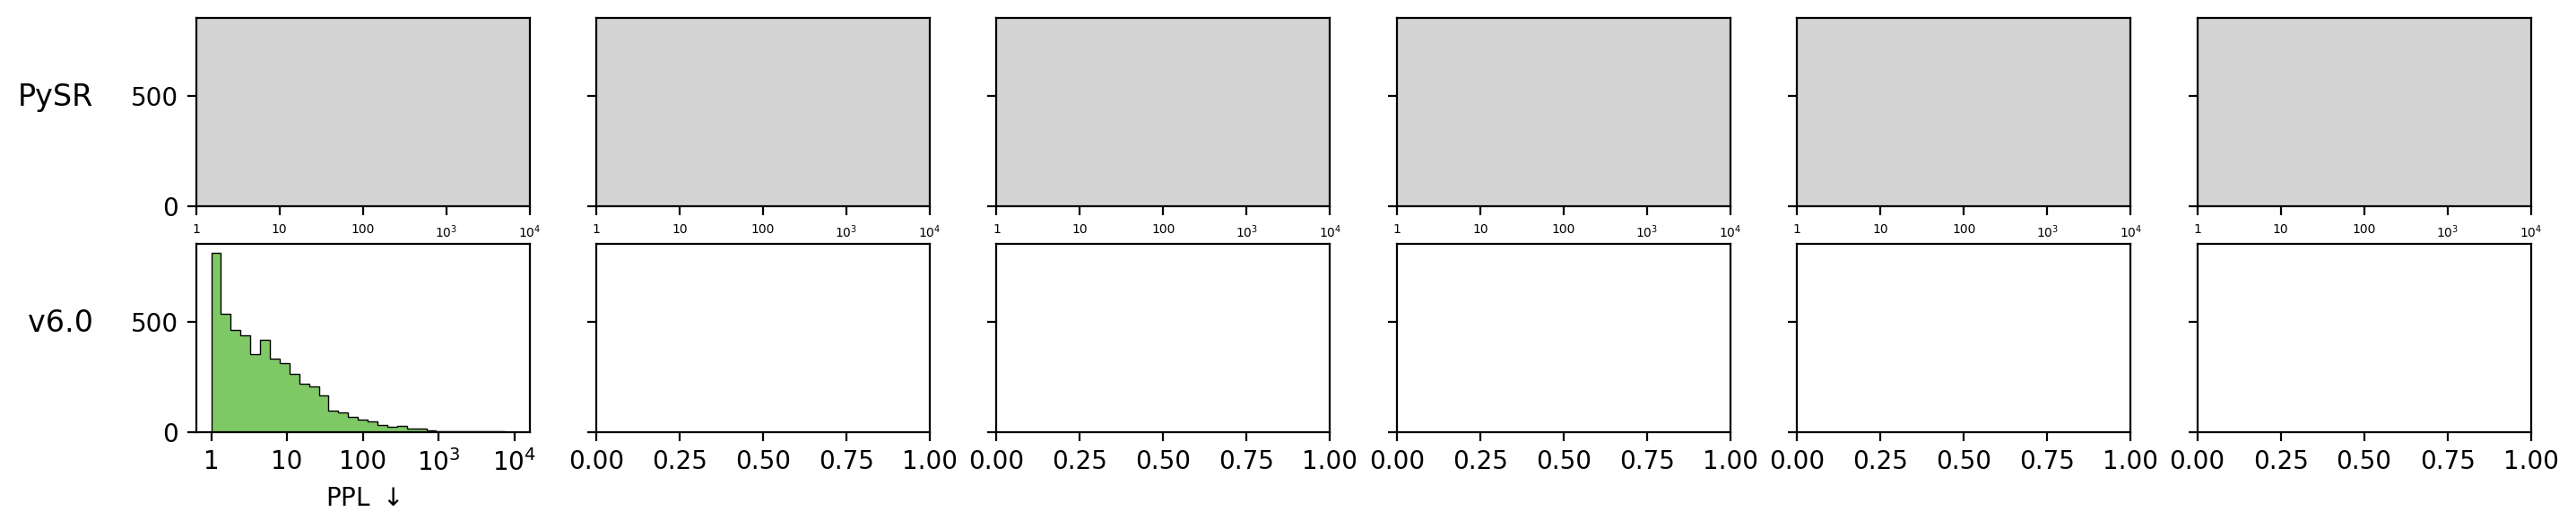

In [ ]:
ROWS = len(UNIQUE_MODELS_NO_NESYMRES)
# COLS = max(len(model_test_sets) for model_test_sets in test_sets.values())
COLS = len(TEST_SETS)
fig, axes = plt.subplots(ROWS, COLS, figsize=(2.8 * COLS, 1.5 * ROWS), sharey=True, dpi=200)

metric_name = 'log_ppl'

xlim = (0, 4)
bins = np.linspace(*xlim, 32)
ylim = (0, 1.05 * max([max(np.histogram(array_dfs[model][test_set].get(metric_name, np.array([np.nan])), bins=bins)[0]) for model in UNIQUE_MODELS_NO_NESYMRES for test_set in test_sets[model]]))

# Plot the distributions of a given metric for each model and test set
color_metric = np.nanmean

min_color_metric = np.nanmin([np.nanmin([color_metric(array_dfs[model][test_set].get(metric_name, pd.Series([np.nan]))) for test_set in test_sets[model]]) for model in UNIQUE_MODELS_NO_NESYMRES])
max_color_metric = np.nanmax([np.nanmax([color_metric(array_dfs[model][test_set].get(metric_name, pd.Series([np.nan]))) for test_set in test_sets[model]]) for model in UNIQUE_MODELS_NO_NESYMRES])

highest_lower_confidence_bound = {test_set: (None, np.inf) for test_set in TEST_SETS}

for i, model in enumerate(UNIQUE_MODELS_NO_NESYMRES):
    for j, test_set in enumerate(TEST_SETS):
        ax = axes[i, j]
        ax.set_xticks(range(xlim[0], xlim[1] + 1))
        ax.set_xticklabels([int_to_10(10**i) for i in range(xlim[0], xlim[1] + 1)], fontdict={'fontsize': 5 if i != len(UNIQUE_MODELS_NO_NESYMRES) - 1 else 10})
        if j == 0: ax.set_ylabel(MODELS_DESCRIPTION[model], rotation=0, labelpad=15, ha='right', fontsize=12)
        if i == len(UNIQUE_MODELS_NO_NESYMRES) - 1: ax.set_xlabel(r'$\text{PPL}\,\,\downarrow$')
        if test_set not in array_dfs[model] or metric_name not in array_dfs[model][test_set] or array_dfs[model][test_set][metric_name].isnull().all():
            ax.set_xlim(xlim)
            ax.set_facecolor('lightgrey')
            continue
        data = array_dfs[model][test_set].get(metric_name, pd.Series([np.nan])).replace(np.nan, np.inf)
        ax.hist(data, bins=bins, color=plt.get_cmap('RdYlGn').reversed()((color_metric(data) - min_color_metric) / (max_color_metric - min_color_metric)), zorder=2)
        ax.hist(data, bins=bins, zorder=2, histtype='step', edgecolor='k', linewidth=0.5)

        median_median, median_5, median_95 = bootstrapped_metric_ci(data, np.nanmean)

        if median_5 < highest_lower_confidence_bound[test_set][1]:
            highest_lower_confidence_bound[test_set] = (model, median_95)

        ax.axvline(median_median, color='black', linestyle='--', zorder=3)
        # ax.errorbar(median_median, ylim[1], xerr=[[median_median - median_5], [median_95 - median_median]], fmt='.', color='black', zorder=4, capsize=3, markersize=0, clip_on=True)
        ax.axvspan(median_5, median_95, color='black', alpha=0.1, zorder=1, linewidth=0)
        ax.set_ylim(ylim)
        ax.grid(alpha=0.3, zorder=0)
        if i == 0: ax.set_title(test_set)
        ax.set_xlim(xlim)


within_lowest_upper_confidence_bound = {test_set: [] for test_set in TEST_SETS}
for i, model in enumerate(UNIQUE_MODELS_NO_NESYMRES):
    for j, test_set in enumerate(TEST_SETS):
        if test_set not in array_dfs[model]:
            continue
        data = array_dfs[model][test_set].get(metric_name, pd.Series([np.nan])).replace(np.nan, np.inf)
        median_median, median_5, median_95 = bootstrapped_metric_ci(data, np.nanmean)

        if median_5 < highest_lower_confidence_bound[test_set][1]:
            within_lowest_upper_confidence_bound[test_set].append(model)

# For each test set, mark the model (row) with the lowest median log_fvu
for j, test_set in enumerate(TEST_SETS):
    if test_set in ['train', 'val']:
        continue
    models = within_lowest_upper_confidence_bound[test_set]
    for i, model in enumerate(UNIQUE_MODELS_NO_NESYMRES):
        if model in models:
            axes[UNIQUE_MODELS_NO_NESYMRES.index(model), j].scatter([xlim[1] * 0.95], [ylim[1] * 0.9], color='orange', marker='*', s=100, zorder=5)

fig.tight_layout(h_pad=0)

In [ ]:
MODELS_WITH_BEAMS = [model for model in MODELS if any('beam_2' in k for k in results[model]['feynman']['data'].keys())]

KeyError: 'feynman'

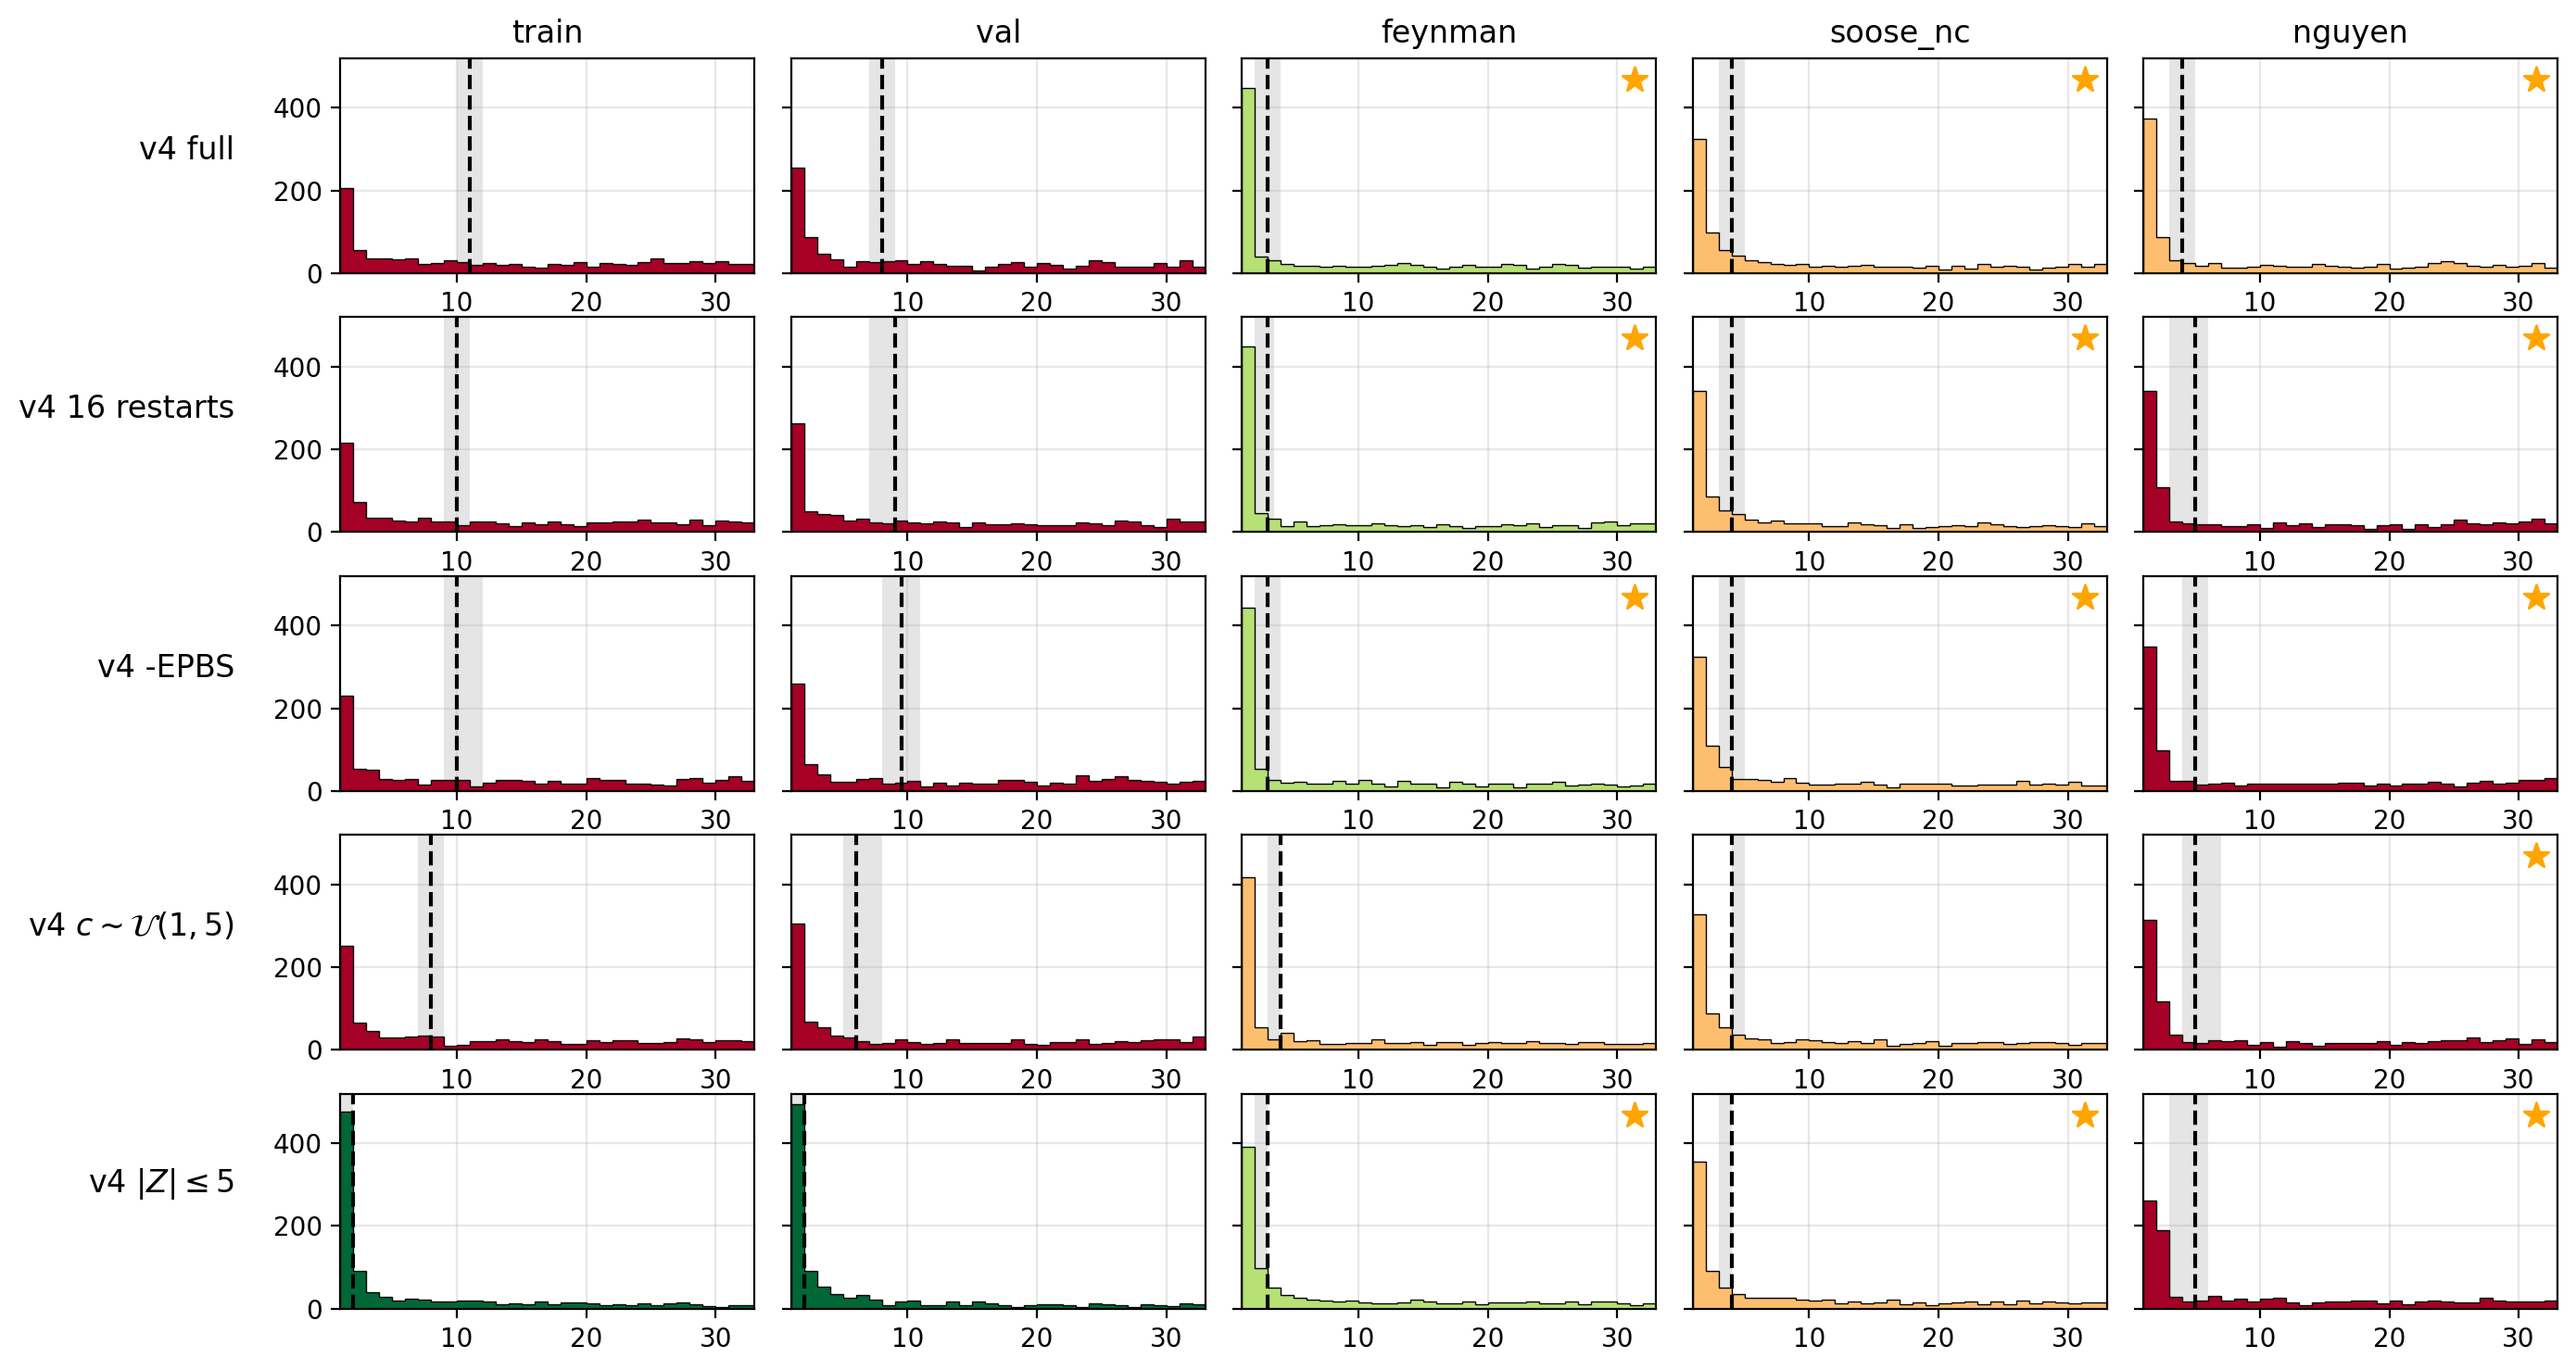

In [ ]:
ROWS = len(MODELS_WITH_BEAMS)
COLS = max(len(model_test_sets) for model_test_sets in test_sets.values())
fig, axes = plt.subplots(ROWS, COLS, figsize=(2.8 * COLS, 1.5 * ROWS), sharey=True, dpi=200)
N_BOOTSTRAPS = 1000
metric_name = 'best_beam'

xlim = (1, 33)
bins = np.linspace(*xlim, 33)
ylim = (0, 1.05 * max([max(np.histogram(array_dfs[model][test_set].get(metric_name, np.array([np.nan])), bins=bins)[0]) for model in MODELS_WITH_BEAMS for test_set in test_sets[model]]))

# Plot the distributions of a given metric for each model and test set
color_metric = np.median

min_color_metric = np.nanmin([np.nanmin([color_metric(array_dfs[model][test_set].get(metric_name, pd.Series([np.nan]))) for test_set in test_sets[model]]) for model in MODELS_WITH_BEAMS])
max_color_metric = np.nanmax([np.nanmax([color_metric(array_dfs[model][test_set].get(metric_name, pd.Series([np.nan]))) for test_set in test_sets[model]]) for model in MODELS_WITH_BEAMS])

highest_lower_confidence_bound = {test_set: (None, np.inf) for test_set in TEST_SETS}

for i, model in enumerate(MODELS_WITH_BEAMS):
    for j, test_set in enumerate(TEST_SETS):
        ax = axes[i, j]
        # ax.set_xticks(range(xlim[0], xlim[1] + 1))
        # ax.set_xticklabels([int_to_10(10**i) for i in range(xlim[0], xlim[1] + 1)], fontdict={'fontsize': 5 if i != len(MODELS) - 1 else 12})
        if j == 0: ax.set_ylabel(MODELS_DESCRIPTION[model], rotation=0, labelpad=15, ha='right', fontsize=12)
        if i == len(MODELS) - 1: ax.set_xlabel(r'$\text{PPL}\,\,\downarrow$')
        if test_set not in array_dfs[model] or metric_name not in array_dfs[model][test_set] or array_dfs[model][test_set][metric_name].isnull().all():
            ax.set_xlim(xlim)
            ax.set_facecolor('lightgrey')
            continue
        data = array_dfs[model][test_set].get(metric_name, pd.Series([np.nan])).replace(np.nan, np.inf)
        ax.hist(data, bins=bins, color=plt.get_cmap('RdYlGn').reversed()((color_metric(data) - min_color_metric) / (max_color_metric - min_color_metric)), zorder=2)
        ax.hist(data, bins=bins, zorder=2, histtype='step', edgecolor='k', linewidth=0.5)

        median_median, median_5, median_95 = bootstrapped_metric_ci(data, np.median, n=N_BOOTSTRAPS)

        if median_5 < highest_lower_confidence_bound[test_set][1]:
            highest_lower_confidence_bound[test_set] = (model, median_95)

        ax.axvline(median_median, color='black', linestyle='--', zorder=3)
        # ax.errorbar(median_median, ylim[1], xerr=[[median_median - median_5], [median_95 - median_median]], fmt='.', color='black', zorder=4, capsize=3, markersize=0, clip_on=True)
        ax.axvspan(median_5, median_95, color='black', alpha=0.1, zorder=1, linewidth=0)
        ax.set_ylim(ylim)
        ax.grid(alpha=0.3, zorder=0)
        if i == 0: ax.set_title(test_set)
        ax.set_xlim(xlim)

within_lowest_upper_confidence_bound = {test_set: [] for test_set in TEST_SETS}
for i, model in enumerate(MODELS):
    for j, test_set in enumerate(TEST_SETS):
        if test_set not in array_dfs[model]:
            continue
        data = array_dfs[model][test_set].get(metric_name, pd.Series([np.nan])).replace(np.nan, np.inf)
        median_median, median_5, median_95 = bootstrapped_metric_ci(data, np.median, n=N_BOOTSTRAPS)

        if median_5 < highest_lower_confidence_bound[test_set][1]:
            within_lowest_upper_confidence_bound[test_set].append(model)

# For each test set, mark the model (row) with the lowest median log_fvu
for j, test_set in enumerate(TEST_SETS):
    if test_set in ['train', 'val']:
        continue
    models = within_lowest_upper_confidence_bound[test_set]
    for i, model in enumerate(MODELS_WITH_BEAMS):
        if model in models:
            axes[MODELS.index(model), j].scatter([xlim[1] * 0.95], [ylim[1] * 0.9], color='orange', marker='*', s=100, zorder=5)

fig.tight_layout(h_pad=0)

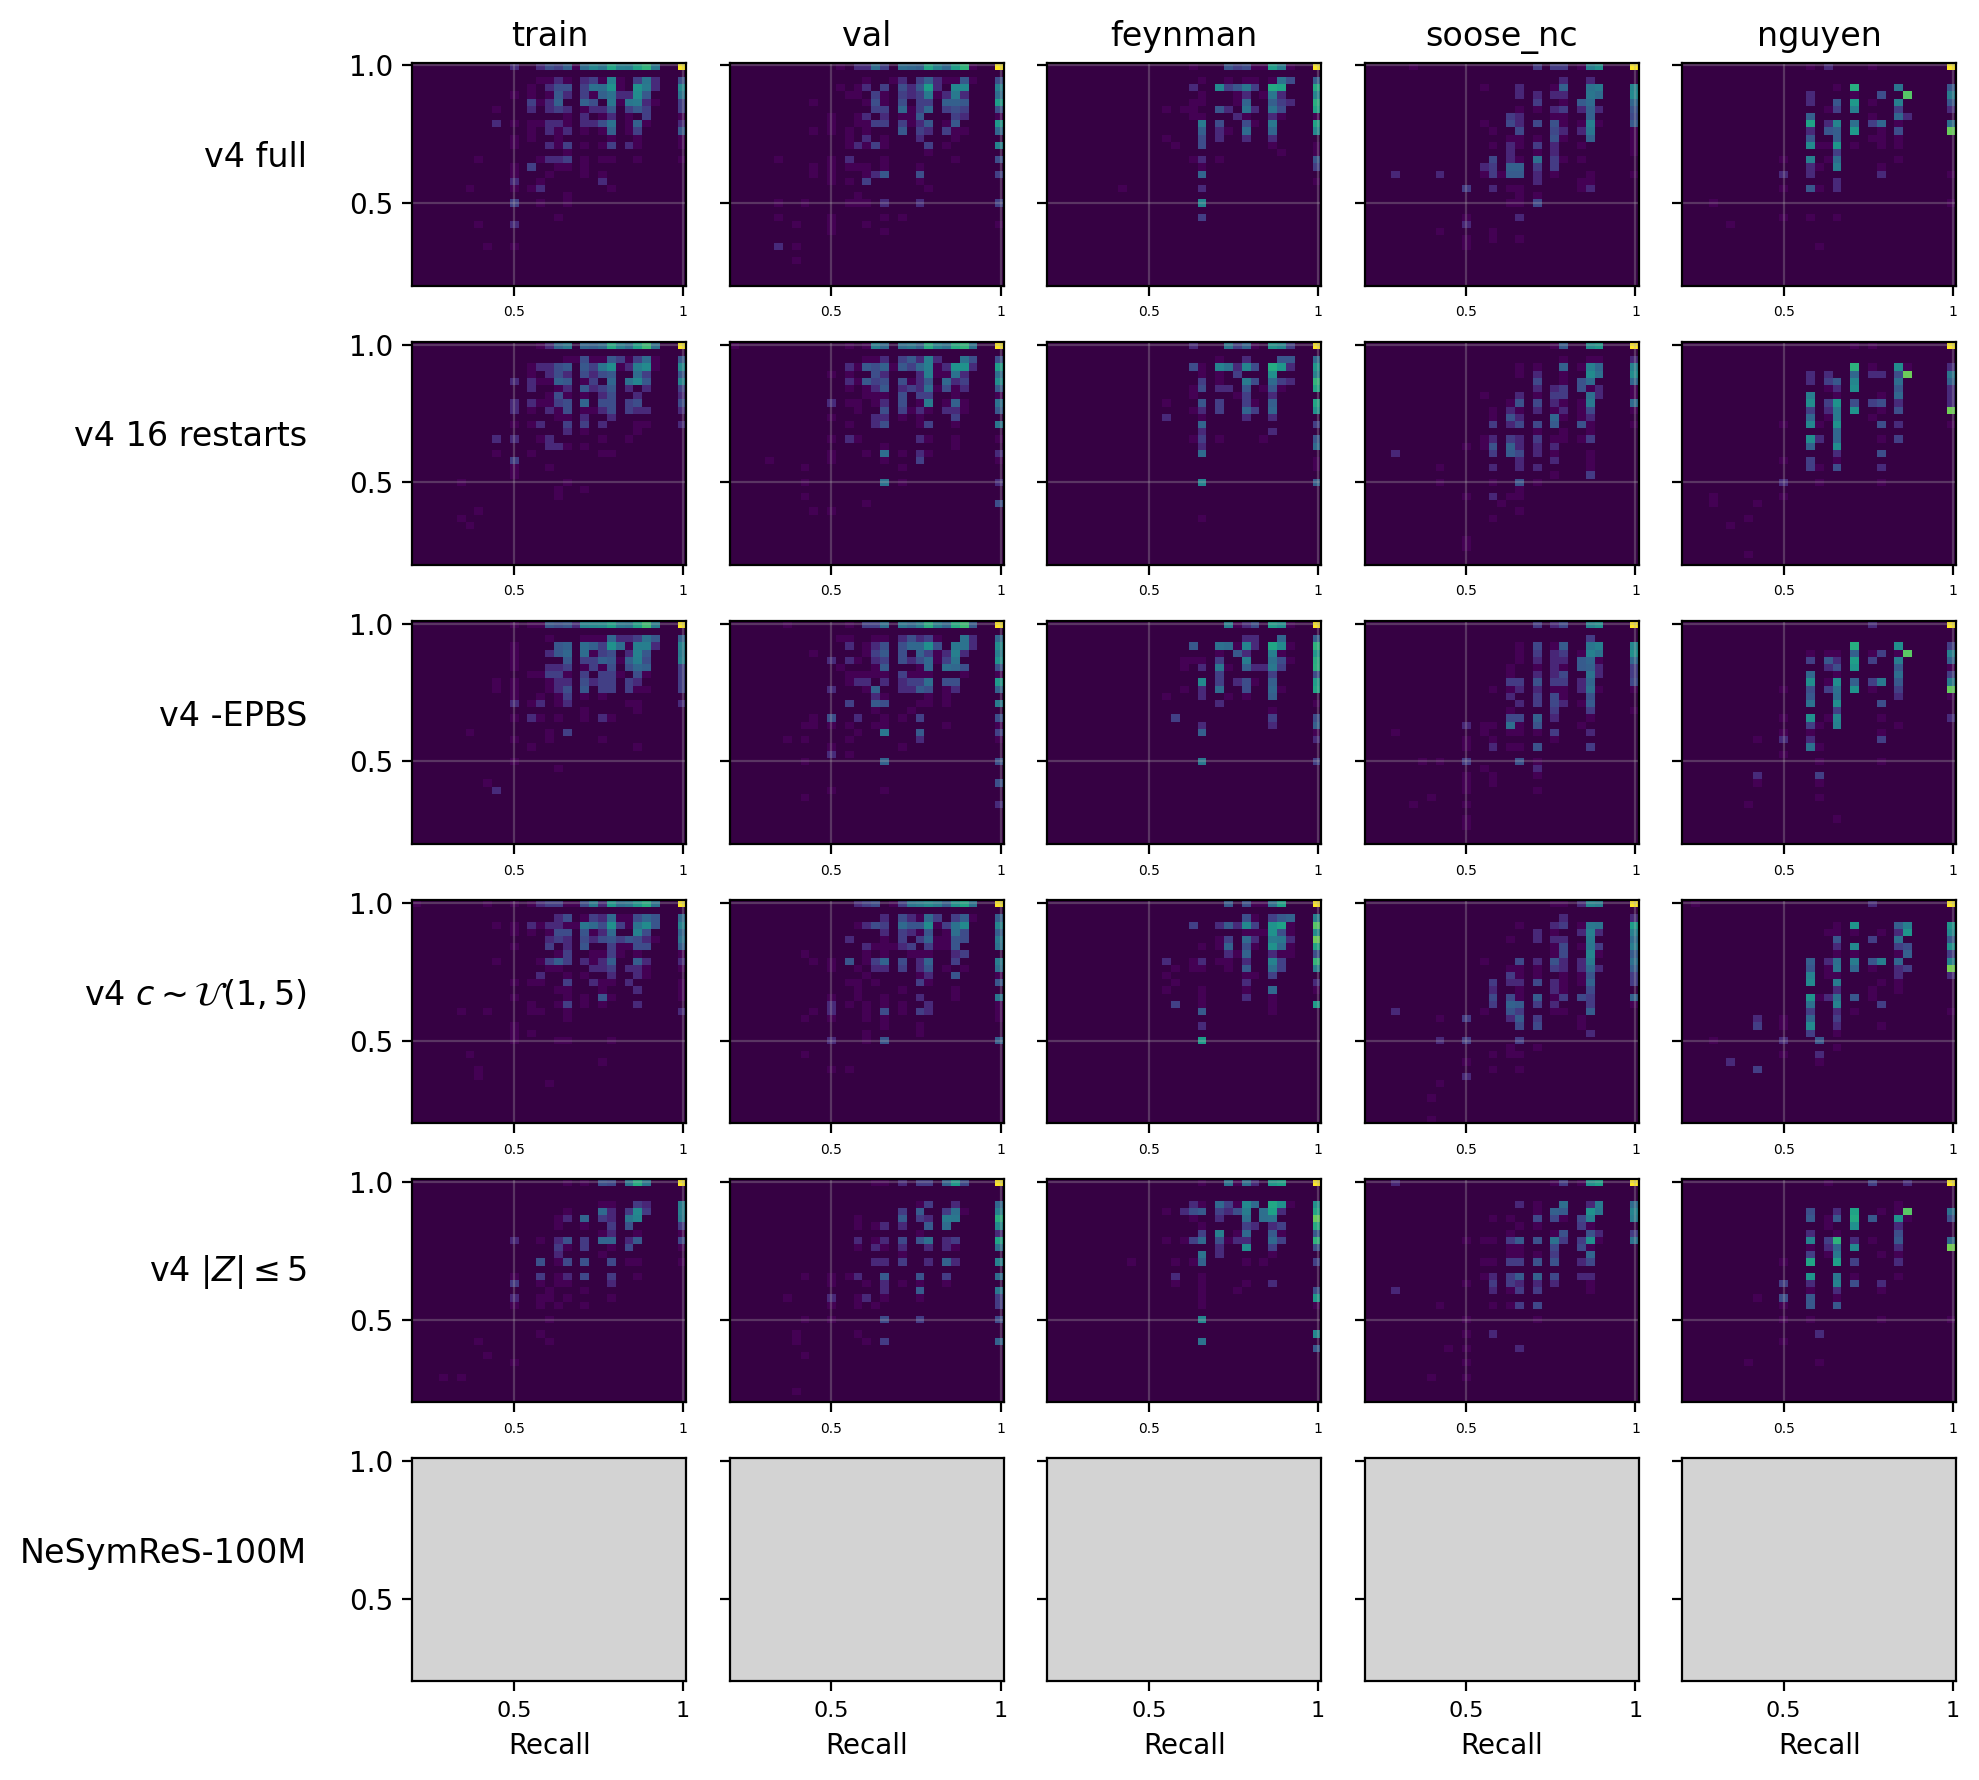

In [ ]:
# For each model and test set, scatter plot the recall-precision curve
ROWS = len(MODELS)
COLS = max(len(model_test_sets) for model_test_sets in test_sets.values())
fig, axes = plt.subplots(ROWS, COLS, figsize=(2 * COLS, 1.5 * ROWS), sharey=True, dpi=200)

metric_name_x = 'recall_best_beam'
metric_name_y = 'precision_best_beam'

xlim = (0.2, 1.01)
ylim = xlim

bins = np.linspace(*xlim, 32)

for i, model in enumerate(MODELS):
    for j, test_set in enumerate(TEST_SETS):
        ax = axes[i, j]
        ax.set_xticks([0.5, 1])
        ax.set_yticks([0.5, 1])
        ax.set_xticklabels([0.5, 1], fontdict={'fontsize': 5 if i != len(MODELS) - 1 else 8})
        if j == 0: ax.set_ylabel(MODELS_DESCRIPTION[model], rotation=0, labelpad=15, ha='right', fontsize=12)
        if i == len(MODELS) - 1: ax.set_xlabel('Recall')
        if test_set not in array_dfs[model] or metric_name_x not in array_dfs[model][test_set] or metric_name_y not in array_dfs[model][test_set]:
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            ax.set_facecolor('lightgrey')
            continue
        data_x = array_dfs[model][test_set].get(metric_name_x, pd.Series([np.nan])).replace(np.nan, 0)
        data_y = array_dfs[model][test_set].get(metric_name_y, pd.Series([np.nan])).replace(np.nan, 0)
        ax.hist2d(data_x, data_y, bins=bins, cmap='viridis', norm=plt.cm.colors.LogNorm())
        ax.set_facecolor(tuple(np.array(plt.get_cmap('viridis')(0)[:3]) * 0.8) + (1, ))
        # ax.scatter(data_x, data_y, s=1, zorder=2, alpha=0.5)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.grid(alpha=0.3, zorder=0)
        if i == 0: ax.set_title(test_set)

fig.tight_layout(h_pad=0.5)